# Preparation
## Imports

In [1]:
%config IPCompleter.greedy=True
from IPython.display import display, HTML

In [4]:
import os
import warnings
import logging
import pickle
import sys
import time
import collections
from itertools import groupby

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn
import seaborn as sns

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import make_column_transformer

from sklearn.svm import SVC, LinearSVC
from sklearn.utils import resample
from sklearn.metrics import make_scorer, get_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report   
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics

from sklearn.dummy import DummyClassifier


from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, SMOTENC
from imblearn.over_sampling import ADASYN


try:
    del sys.modules['feutils']
    del sys.modules['config']
except:
    pass
import config
from feutils import DataHandler
from feutils import JNCC2Wrapper
from feutils import FEUtils

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

feu = FEUtils()


## Data loading

In [5]:
# new features angles speeds means/stds
matrix_subject_nophase = os.path.join('..', 'features', 'angles', 'matrix-2019-0607_00-25-49Features-nophase.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'angles', 'matrix-2019-0608_12-31-38Features-agent-157015.xlsx')
matrix_subject_phases = os.path.join('..', 'features', 'angles', 'matrix-2019-0608_08-46-42Features-157015.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'angles', 'matrix-2019-0608_15-03-58Features-agent-nophase.xlsx')


# new feature 'answerDelay'
"""matrix_agent_phases = os.path.join('..', 'features', 'answersDelays', matrix-2019-0529_13-58-51Features-agent-157015.xlsx')
matrix_subject_phases = os.path.join('..', 'features', 'answersDelays', 'matrix-2019-0529_11-20-12Features-157015.xlsx')
trix_subject_nophase = os.path.join('..', 'features', 'answersDelays', 'matrix-2019-0602_22-16-02Features-nophase.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'answersDelays', 'matrix-2019-0602_21-45-19Features-agent-nophase.xlsx')"""

# 'cleaned' dataset
"""matrix_subject_phases = os.path.join('..', 'features', 'cleaned', 'matrix-2019-0409_14-52-24Features-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'cleaned', 'matrix-2019-0410_17-50-48Features-agent-157015.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'cleaned', 'matrix-2019-0411_14-05-24Features-nophase.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'cleaned','matrix-2019-0411_15-30-16Features-agent-nophase.xlsx') """

# old dataset
"""matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0226_15-16-44Features-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0226_17-18-28Features-agent-157015.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0227_20-11-53Features-nophase.xlsx')
matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0227_22-43-15Features-agent-nophase.xlsx') """

def prepare_df(df):
    # Replace 3 classes (low, medium, high) by 5 classes (ie, score rounded)
    #df['Presence Class'] = df['Presence Score'].round()
    #df['Co-presence Class'] = df['Co-presence Score'].round()
    #df = df.drop(['Presence Score', 'Co-presence Score'], axis=1)
    df = df.rename(index=str,
                   columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})
    return df

def prepare_agent_df(df):
    df = prepare_df(df)
    df = df.drop(['PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score', 'Duration', 'Expert'], axis=1)
    agent_cols_rename = {}
    for col in df.columns:
        if col not in ['Candidate', 'Environment']:
            agent_cols_rename[col] = col + '_agent'
    df = df.rename(index=str, columns=agent_cols_rename)
    return df
    
def dfval(df, candidate, environment, column):
    return df.query("Candidate == '%s' & Environment == '%s'" % (candidate, environment))[column].values

print("Loading data - phases split ...")

subject_p_df = pd.read_excel(matrix_subject_phases).set_index('Candidate').drop('E6F', axis=0).reset_index()
subject_p_df = prepare_df(subject_p_df)
print("   Subject(phases): %d samples" % len(subject_p_df))
agent_p_df = pd.read_excel(matrix_agent_phases).set_index('Candidate').drop('E6F', axis=0).reset_index()
agent_p_df = prepare_agent_df(agent_p_df)
print("   Agent(phases): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_p_df = pd.merge(agent_p_df, subject_p_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(phases-merged): %d samples" % len(agent_p_df))

# no phase

subject_np_df = pd.read_excel(matrix_subject_nophase).set_index('Candidate').drop('E6F', axis=0).reset_index()
subject_np_df = prepare_df(subject_np_df)
print("   Subject(no phase): %d samples" % len(subject_np_df))
agent_np_df = pd.read_excel(matrix_agent_nophase).set_index('Candidate').drop('E6F', axis=0).reset_index()
agent_np_df = prepare_agent_df(agent_np_df)
print("   Agent(no phase): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_np_df = pd.merge(agent_np_df, subject_np_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(no phase-merged): %d samples" % len(agent_np_df))

subject_p_df.index = [subject_p_df['Candidate'], subject_p_df['Environment']]
agent_p_df.index = [agent_p_df['Candidate'], agent_p_df['Environment']]
subject_np_df.index = [subject_np_df['Candidate'], subject_np_df['Environment']]
agent_np_df.index = [agent_np_df['Candidate'], agent_np_df['Environment']]

intersect = set(subject_p_df.index) & set(agent_p_df.index) & set(subject_np_df.index) & set(agent_np_df.index)
print("  samples intersection %d" % len(intersect))

rejected_from_subject_p_df = set(subject_p_df.index) - intersect
rejected_from_subject_np_df = set(subject_np_df.index) - intersect
rejected_from_agent_p_df = set(agent_p_df.index) - intersect
rejected_from_agent_np_df = set(agent_np_df.index) - intersect

# restrict each dataset to the common samples
subject_p_df = subject_p_df.loc[list(intersect)].reset_index(drop=True)
subject_np_df = subject_np_df.loc[list(intersect)].reset_index(drop=True)
agent_p_df = agent_p_df.loc[list(intersect)].reset_index(drop=True)
agent_np_df = agent_np_df.loc[list(intersect)].reset_index(drop=True)

all_p_df = pd.merge(subject_p_df, agent_p_df.drop(['Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score'], axis=1), on=['Candidate', 'Environment'], 
                    how='inner', suffixes=(False, False))
#all_p_df = all_p_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(phases): %d samples " % len(all_p_df))

all_np_df = pd.merge(subject_np_df, agent_np_df.drop(['Duration', 'PresenceClass', 'CopresenceClass', 'Presence Score', 'Co-presence Score'], axis=1), on=['Candidate', 'Environment'], 
                     how='inner', suffixes=(False, False))
#all_np_df = all_np_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(no phase): %d samples " % len(all_np_df))

print("")
print("Additional info:")
print("   samples rejected from subject / phases   %d" % len(rejected_from_subject_p_df))
for item in sorted(list(rejected_from_subject_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from subject / no phase %d" % len(rejected_from_subject_np_df))
for item in sorted(list(rejected_from_subject_np_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / phases     %d" % len(rejected_from_agent_p_df))
for item in sorted(list(rejected_from_agent_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / no phase   %d" % len(rejected_from_agent_np_df))
for item in sorted(list(rejected_from_agent_np_df)) : print("     %s / %s" % (item[0], item[1]))


Loading data - phases split ...
   Subject(phases): 95 samples
   Agent(phases): 96 samples
   Agent(phases-merged): 94 samples
   Subject(no phase): 96 samples
   Agent(no phase): 94 samples
   Agent(no phase-merged): 94 samples
  samples intersection 92
   Merge(phases): 92 samples 
   Merge(no phase): 92 samples 

Additional info:
   samples rejected from subject / phases   3
     E11E / Cave
     E3C / Cave
     N22D / Casque
   samples rejected from subject / no phase 4
     E11E / Cave
     E3C / Cave
     N1A / Cave
     N22D / Casque
   samples rejected from agent / phases     2
     E11E / Cave
     E3C / Cave
   samples rejected from agent / no phase   2
     N1A / Cave
     N22D / Casque


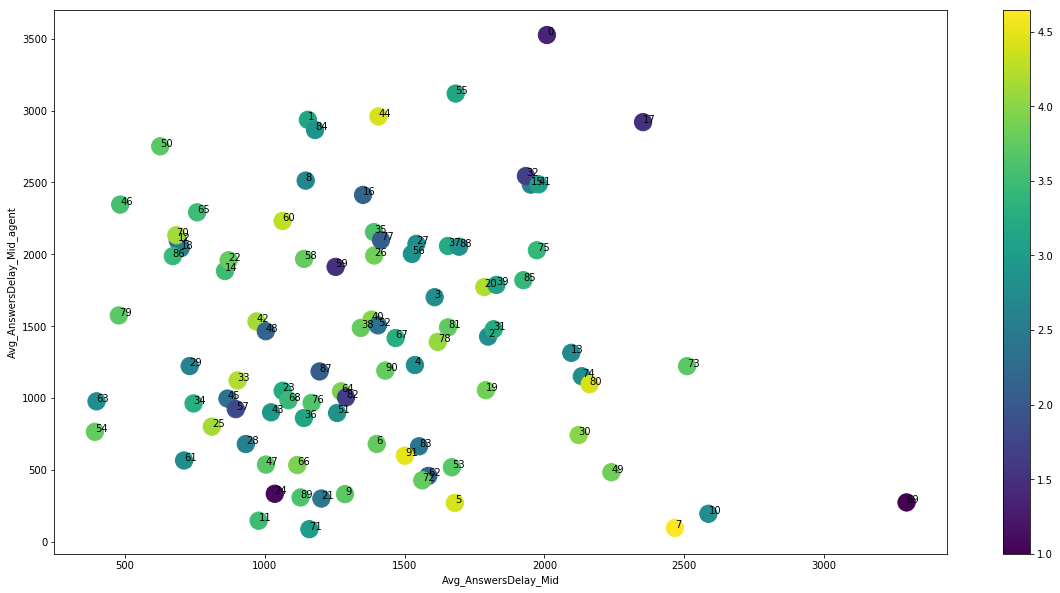

In [6]:

#Avg_SentenceLength_Mid_agent
def plot_variables(samples, idx_1, idx_2, target_column):
    plt.figure(figsize=(20,10))
    plt.scatter(samples.iloc[:, idx_1], samples.iloc[:, idx_2], c=samples[target_column], s=300)
    for idx in np.arange(len(samples)):
        plt.annotate(str(idx), (samples.iloc[idx, idx_1], samples.iloc[idx, idx_2]))
    plt.xlabel(samples.columns[idx_1])
    plt.ylabel(samples.columns[idx_2])
    plt.colorbar()
    plt.show()

col1 = 'Avg_AnswersDelay_Mid'
col2 = 'Avg_AnswersDelay_Mid_agent'    

plot_variables(all_np_df, list(all_np_df.columns).index(col1), list(all_np_df.columns).index(col2), 'Presence Score')

In [ ]:
plt.hist(all_p_df['Presence Score'], bins=20, range=(1,5), edgecolor='black')
plt.ylabel("Number of samples")
plt.xlabel("Presence score")
plt.axvline(x=all_p_df['Presence Score'].mean(), c='red', label='mean (%.02f)'%all_p_df['Presence Score'].mean())
plt.axvline(x=all_p_df['Presence Score'].median(), c='green', label='median (%.02f)'%all_p_df['Presence Score'].median())
plt.legend()
plt.show()
plt.hist(all_p_df['Co-presence Score'], bins=20, range=(1,5), edgecolor='black')
plt.axvline(x=all_p_df['Co-presence Score'].mean(), c='red', label='mean (%.02f)'%all_p_df['Co-presence Score'].mean())
plt.axvline(x=all_p_df['Co-presence Score'].median(), c='green', label='median (%.02f)'%all_p_df['Co-presence Score'].median())
plt.legend()
plt.ylabel("Number of samples")
plt.xlabel("Co-Presence score")

## Discretization of presence and co-presence scores

92
92
(0, {'n_bins': 2, 'strategy': 'uniform'})


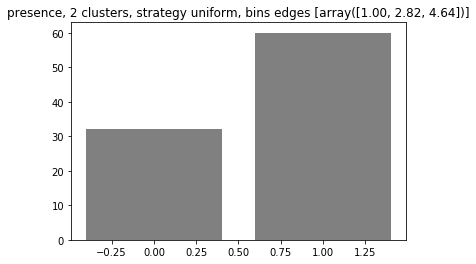

(1, {'n_bins': 2, 'strategy': 'quantile'})


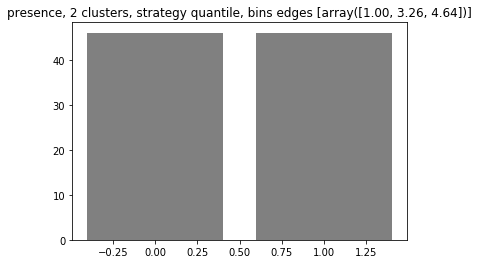

(2, {'n_bins': 2, 'strategy': 'kmeans'})


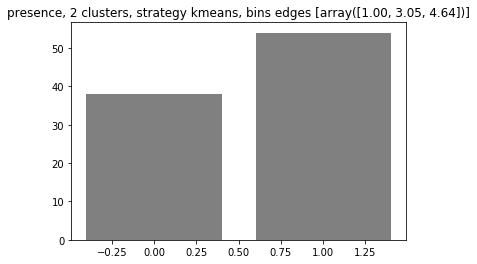

(3, {'n_bins': 3, 'strategy': 'uniform'})


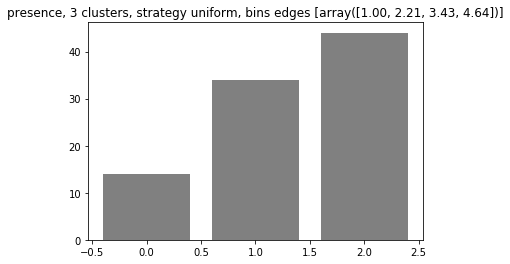

(4, {'n_bins': 3, 'strategy': 'quantile'})


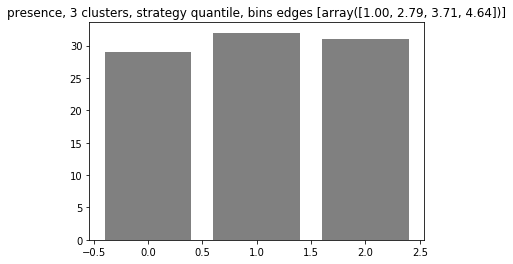

(5, {'n_bins': 3, 'strategy': 'kmeans'})


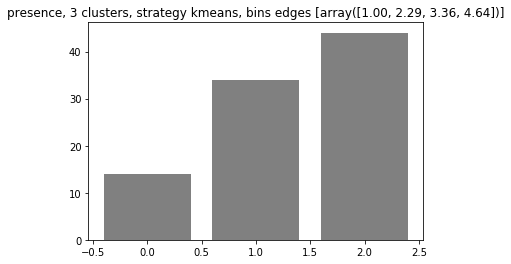

(6, {'n_bins': 4, 'strategy': 'uniform'})


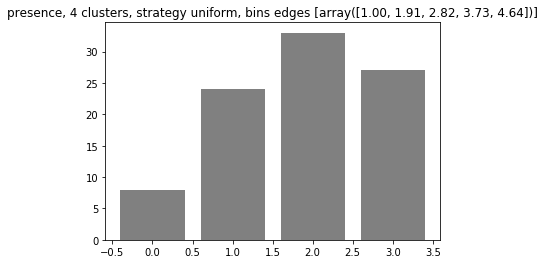

(7, {'n_bins': 4, 'strategy': 'quantile'})


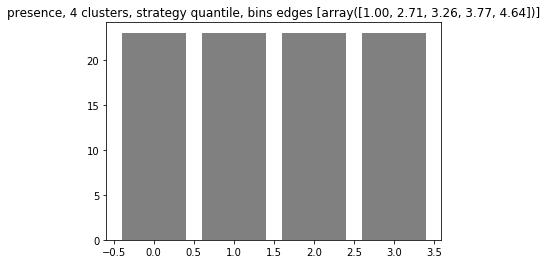

(8, {'n_bins': 4, 'strategy': 'kmeans'})


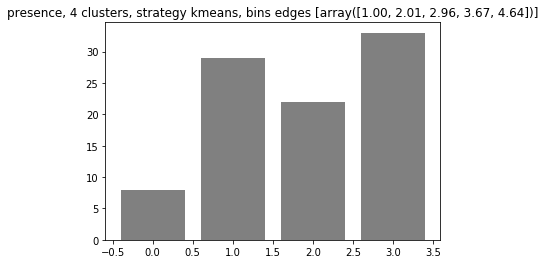

(9, {'n_bins': 5, 'strategy': 'uniform'})


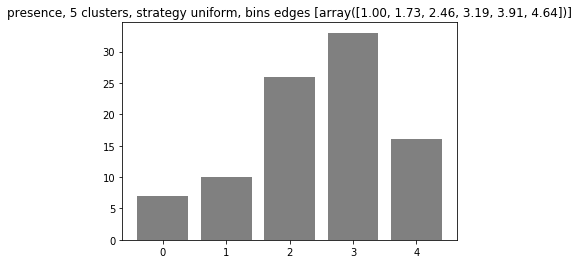

(10, {'n_bins': 5, 'strategy': 'quantile'})


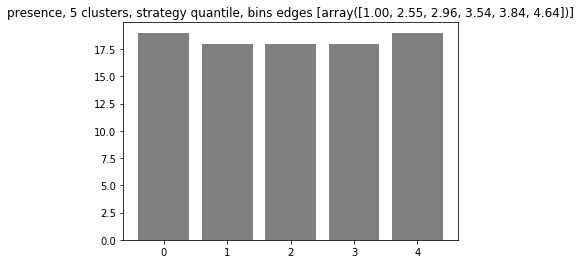

(11, {'n_bins': 5, 'strategy': 'kmeans'})


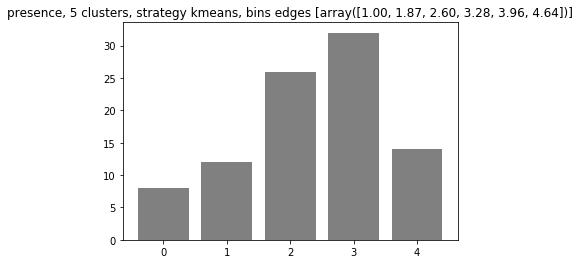

(12, {'n_bins': 6, 'strategy': 'uniform'})


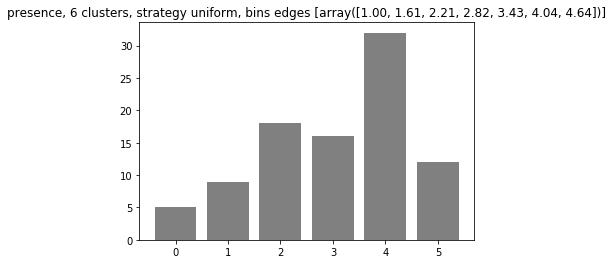

(13, {'n_bins': 6, 'strategy': 'quantile'})


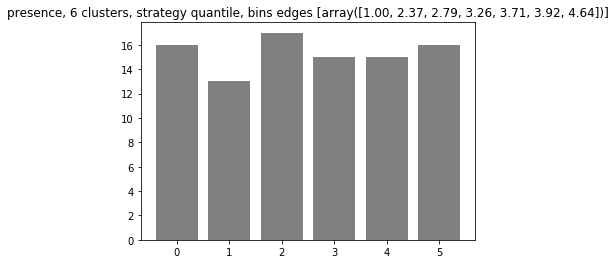

(14, {'n_bins': 6, 'strategy': 'kmeans'})


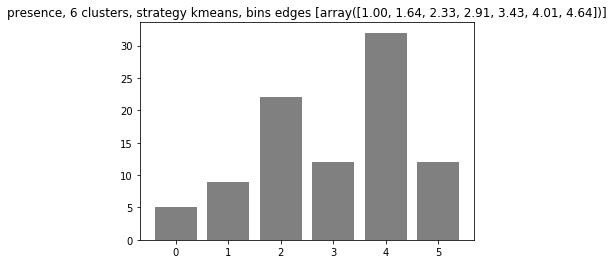

(15, {'n_bins': 7, 'strategy': 'uniform'})


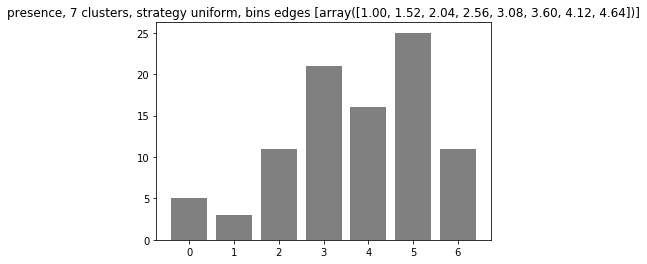

(16, {'n_bins': 7, 'strategy': 'quantile'})


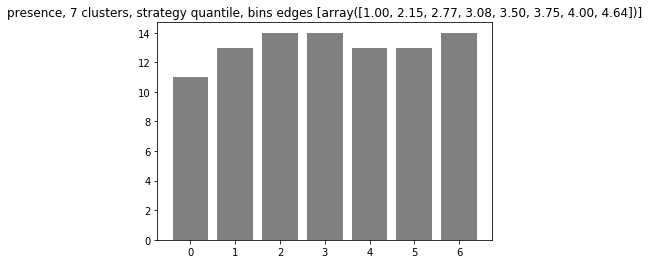

(17, {'n_bins': 7, 'strategy': 'kmeans'})


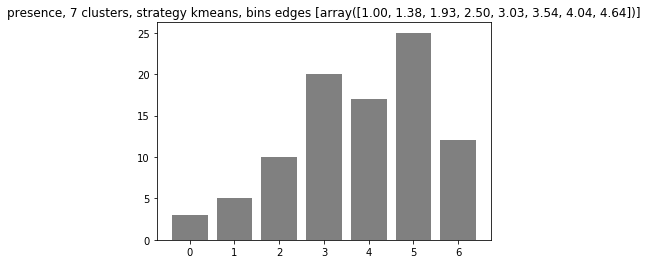

(18, {'n_bins': 8, 'strategy': 'uniform'})


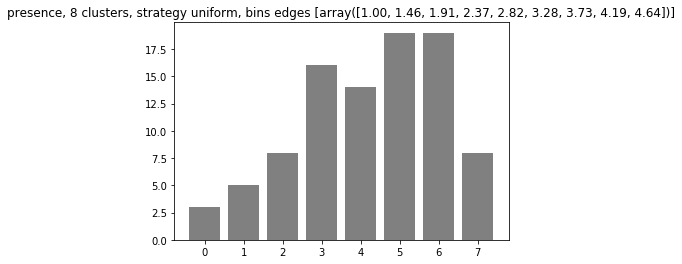

(19, {'n_bins': 8, 'strategy': 'quantile'})


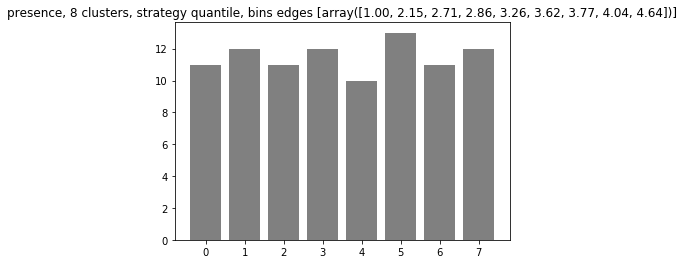

(20, {'n_bins': 8, 'strategy': 'kmeans'})


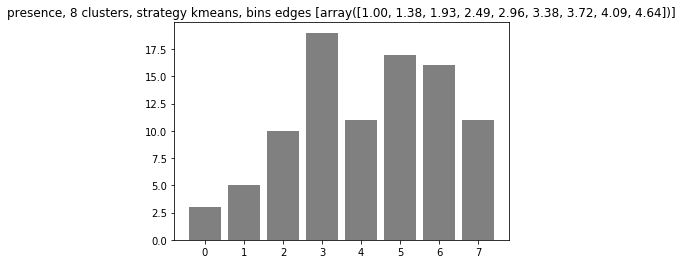

(21, {'n_bins': 9, 'strategy': 'uniform'})


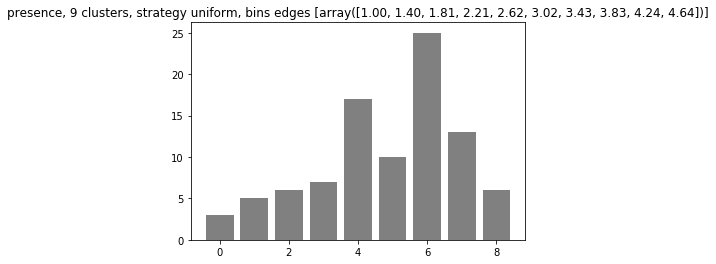

(22, {'n_bins': 9, 'strategy': 'quantile'})


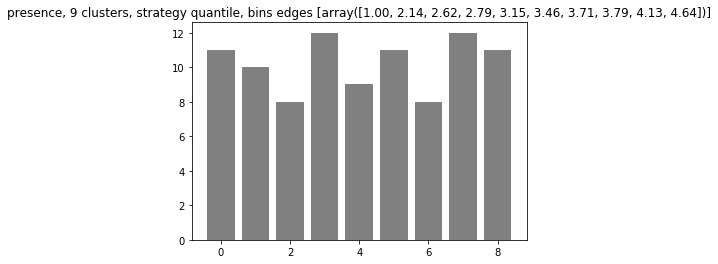

(23, {'n_bins': 9, 'strategy': 'kmeans'})


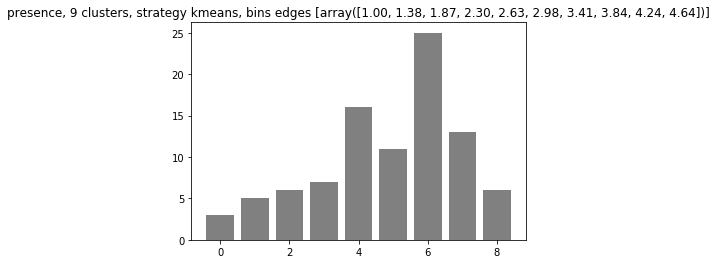

(24, {'n_bins': 10, 'strategy': 'uniform'})


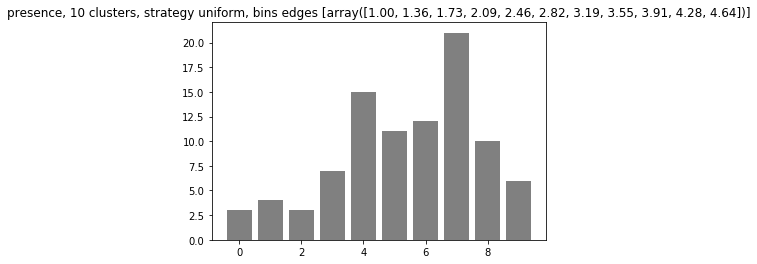

(25, {'n_bins': 10, 'strategy': 'quantile'})


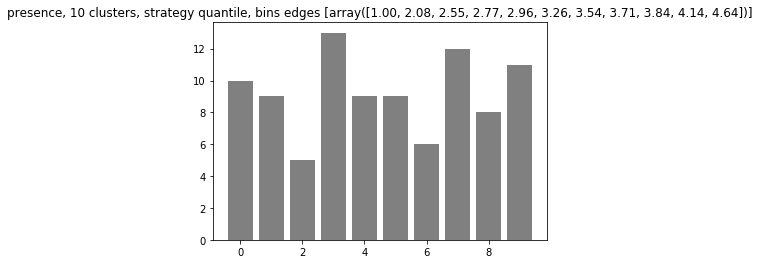

(26, {'n_bins': 10, 'strategy': 'kmeans'})


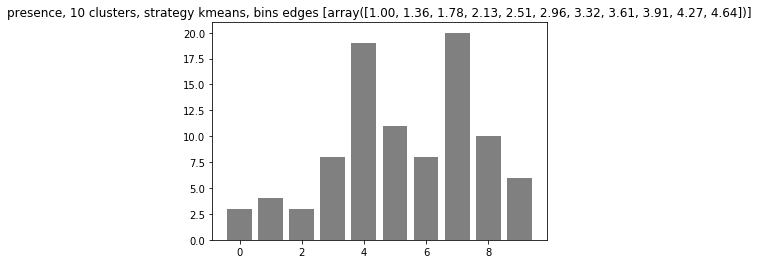

(0, {'n_bins': 2, 'strategy': 'uniform'})


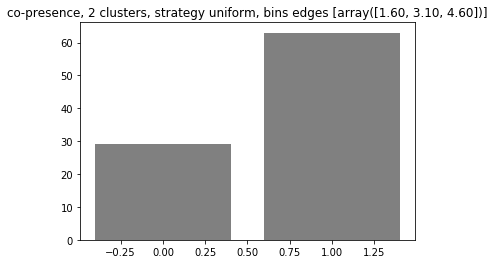

(1, {'n_bins': 2, 'strategy': 'quantile'})


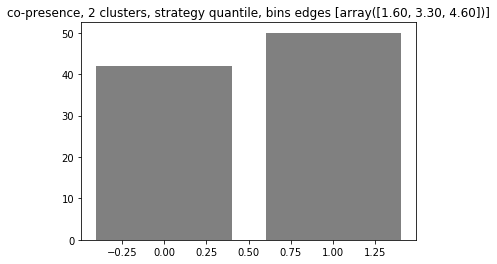

(2, {'n_bins': 2, 'strategy': 'kmeans'})


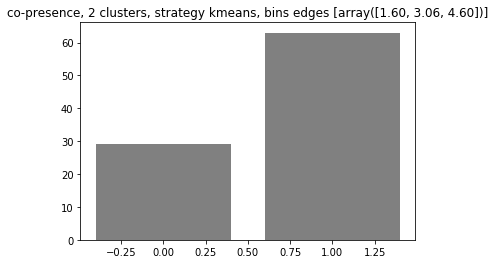

(3, {'n_bins': 3, 'strategy': 'uniform'})


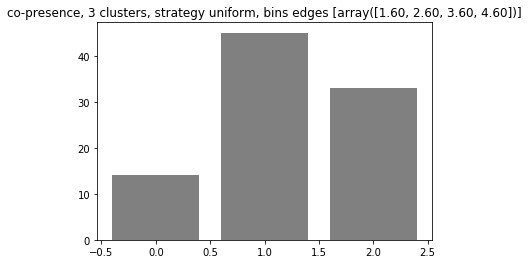

(4, {'n_bins': 3, 'strategy': 'quantile'})


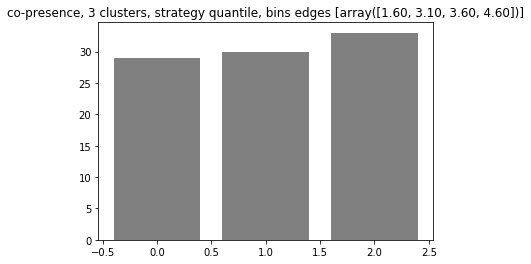

(5, {'n_bins': 3, 'strategy': 'kmeans'})


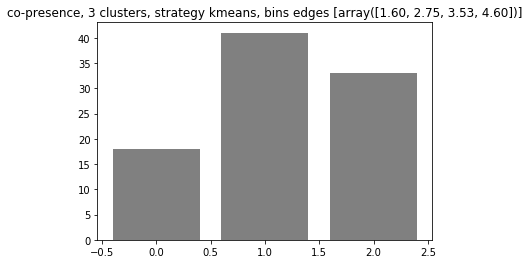

(6, {'n_bins': 4, 'strategy': 'uniform'})


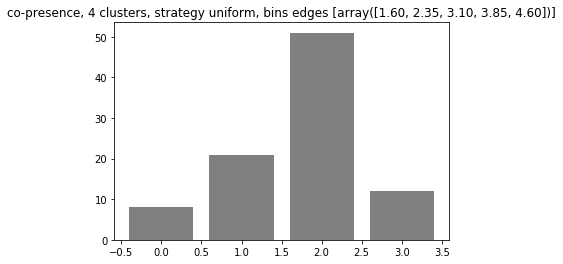

(7, {'n_bins': 4, 'strategy': 'quantile'})


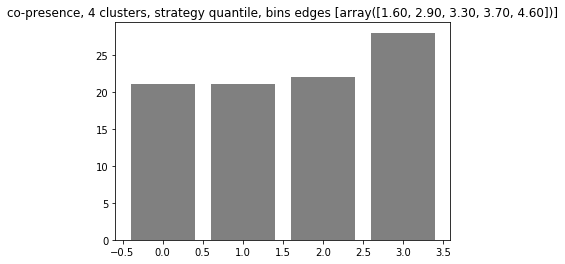

(8, {'n_bins': 4, 'strategy': 'kmeans'})


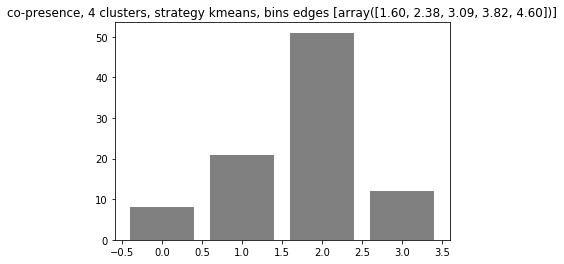

(9, {'n_bins': 5, 'strategy': 'uniform'})


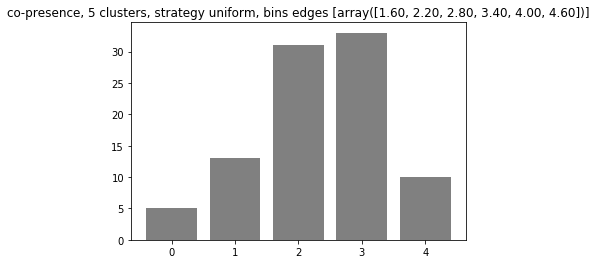

(10, {'n_bins': 5, 'strategy': 'quantile'})


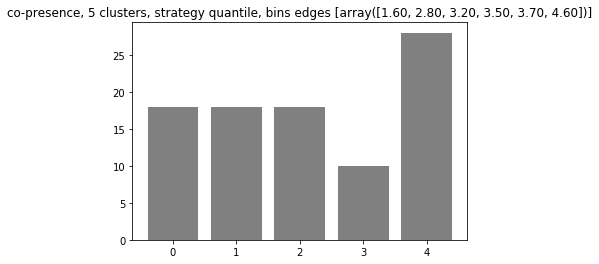

(11, {'n_bins': 5, 'strategy': 'kmeans'})


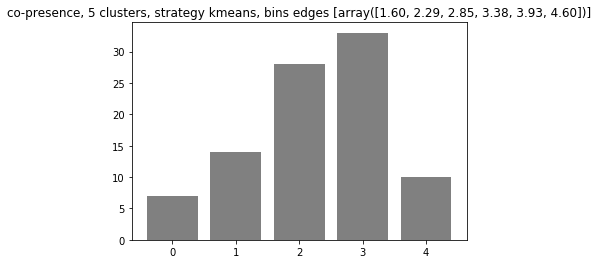

(12, {'n_bins': 6, 'strategy': 'uniform'})


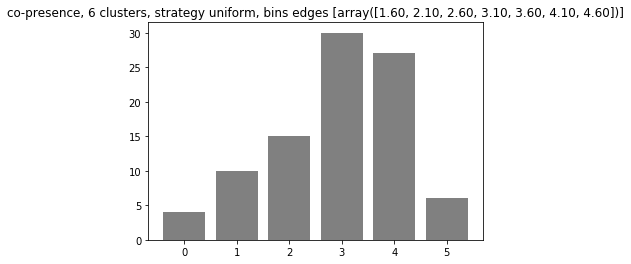

(13, {'n_bins': 6, 'strategy': 'quantile'})


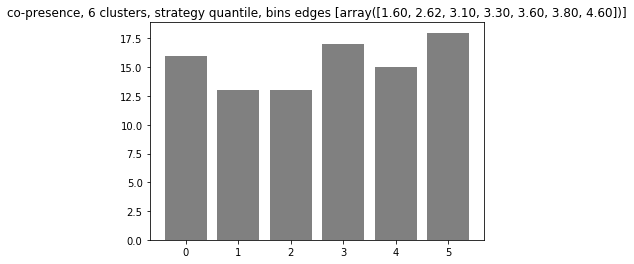

(14, {'n_bins': 6, 'strategy': 'kmeans'})


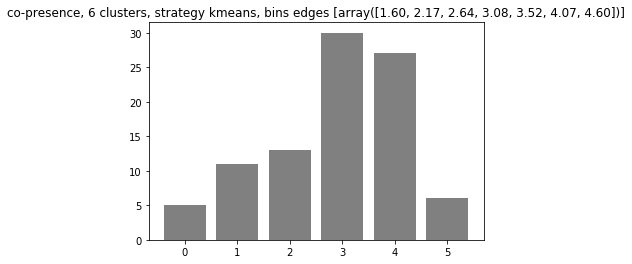

(15, {'n_bins': 7, 'strategy': 'uniform'})


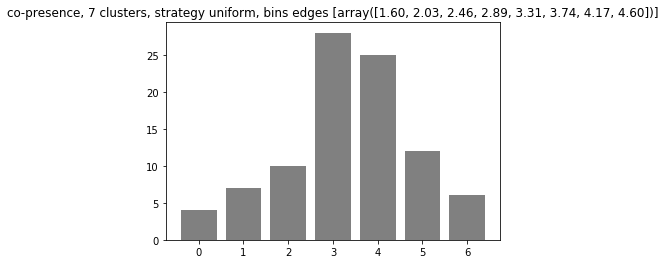

(16, {'n_bins': 7, 'strategy': 'quantile'})


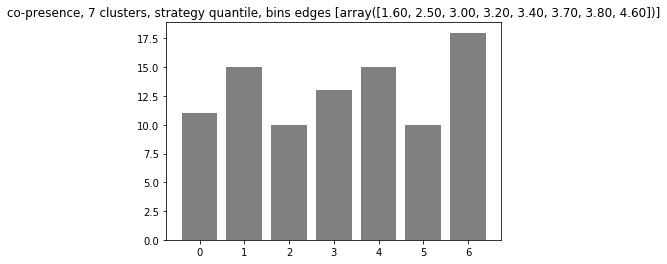

(17, {'n_bins': 7, 'strategy': 'kmeans'})


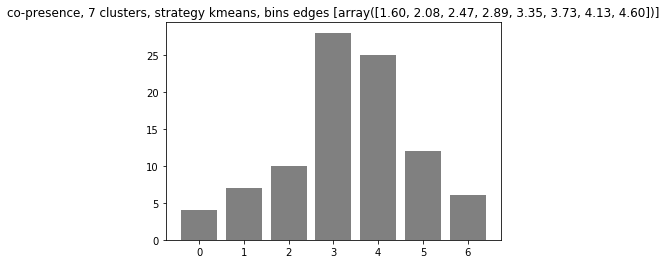

(18, {'n_bins': 8, 'strategy': 'uniform'})


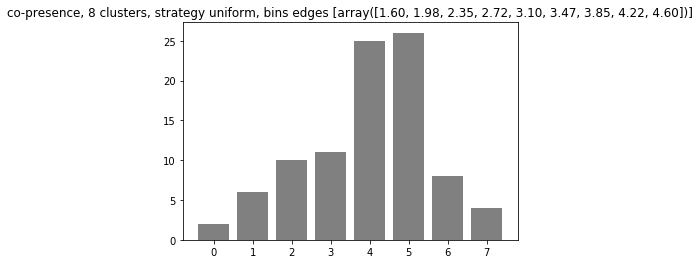

(19, {'n_bins': 8, 'strategy': 'quantile'})


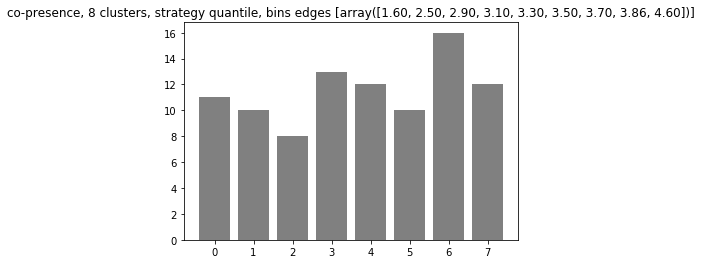

(20, {'n_bins': 8, 'strategy': 'kmeans'})


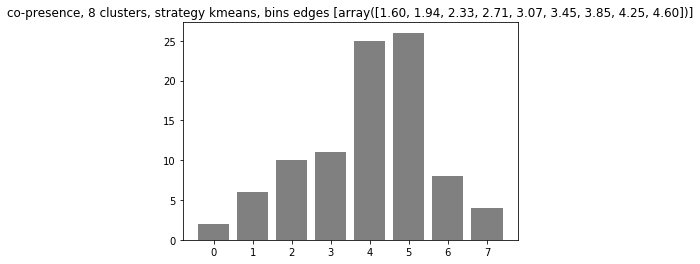

(21, {'n_bins': 9, 'strategy': 'uniform'})


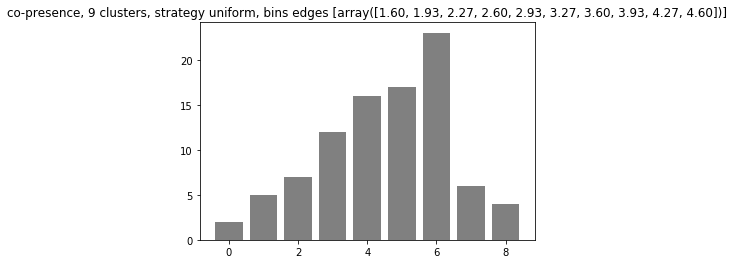

(22, {'n_bins': 9, 'strategy': 'quantile'})


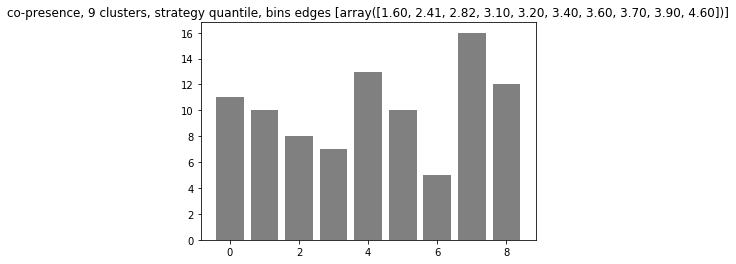

(23, {'n_bins': 9, 'strategy': 'kmeans'})


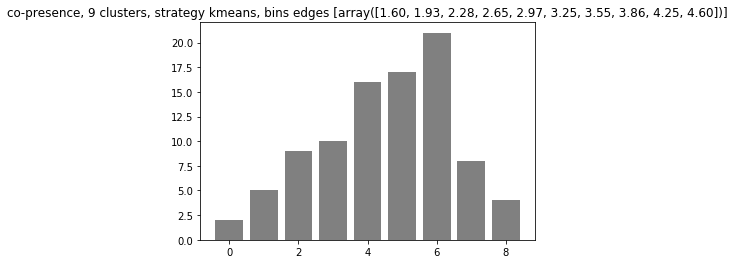

(24, {'n_bins': 10, 'strategy': 'uniform'})


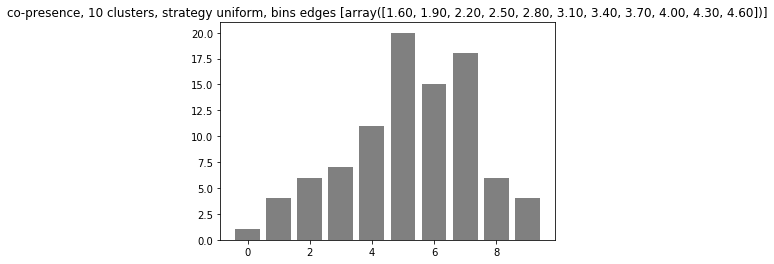

(25, {'n_bins': 10, 'strategy': 'quantile'})


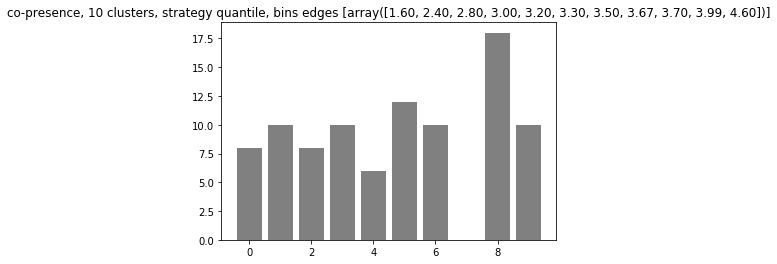

(26, {'n_bins': 10, 'strategy': 'kmeans'})


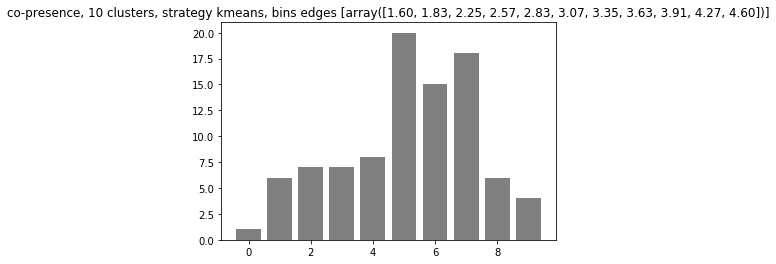

In [7]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics


discretization_params = {
    'n_bins' : [2,3,4,5,6,7,8,9,10],
    'strategy' : ['uniform', 'quantile', 'kmeans']
}

def discretize(data, n_bins, strategy):
    enc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    pres_arr = np.array(data).reshape(-1,1)
    pres_kmeans = enc.fit_transform(pres_arr).astype(int)
    return pres_kmeans, enc

def compute_discretization_scores(data, labels):
    calinski = metrics.calinski_harabaz_score(data, labels)
    silhouette = metrics.silhouette_score(data, labels, metric='euclidean')
    db = metrics.davies_bouldin_score(data, labels)
    min_cluster = np.unique(labels, return_counts=True)[1].min()
    max_cluster = np.unique(labels, return_counts=True)[1].max()  
    return [calinski, silhouette, db, min_cluster, max_cluster]

def discretization_gridsearch(data, discretization_params, orig_discretization=None, title_prefix='presence, '):
    data = np.array(data).reshape(-1, 1)
    discretization_params_grid = ParameterGrid(discretization_params)
    results = np.zeros(shape=(len(discretization_params_grid)+1, 5))
    for idx, param_set in enumerate(discretization_params_grid):
        print(idx, param_set)
        pres_kmeans, enc = discretize(data, n_bins=param_set['n_bins'], strategy=param_set['strategy'])
        bins = np.bincount(pres_kmeans.astype(int).flatten())
        plt.bar(range(len(bins)), bins, color='grey')
        #plt.hist(pres_kmeans.astype(int))
        plt.title('%s%d clusters, strategy %s, bins edges %s' % (title_prefix, param_set['n_bins'], param_set['strategy'], enc.bin_edges_))
        plt.show()

        results[idx] = compute_discretization_scores(data, pres_kmeans)
    if orig_discretization is not None:
        results[-1] = compute_discretization_scores(data, orig_discretization)
    myindex = ["%s (%s)" % (p['n_bins'], p['strategy']) for p in discretization_params_grid]
    myindex.append("3 (orig)")
    cluster_results = pd.DataFrame(data=results, index=myindex, columns=['Calinski-Harabaz', 'Silhouette', 'Davies-Bouldin',
                                                                        'min cluster nb', 'max cluster nb'])
    cluster_results['C-H'] = (cluster_results['Calinski-Harabaz'] - cluster_results['Calinski-Harabaz'].mean()) / cluster_results['Calinski-Harabaz'].std()
    cluster_results['S'] = (cluster_results['Silhouette'] - cluster_results['Silhouette'].mean()) / cluster_results['Silhouette'].std()
    cluster_results['D-B'] = (cluster_results['Davies-Bouldin'] - cluster_results['Davies-Bouldin'].mean()) / cluster_results['Davies-Bouldin'].std()
    cluster_results['Weighted'] = cluster_results['D-B'] - cluster_results['C-H'] - cluster_results['S']
    return cluster_results

def highlight_max(x):
    return ['color: red' if v == x.max() else 'color: green' if v == x.min() else '' for v in x]

presence = all_p_df.sort_values(by=['Presence Score'])['Presence Score']
copresence = all_p_df.sort_values(by=['Co-presence Score'])['Co-presence Score']
orig_pres = all_p_df.sort_values(by=['Presence Score'])['PresenceClass']
orig_copres = all_p_df.sort_values(by=['Co-presence Score'])['CopresenceClass']
print(len(presence))
print(len(orig_pres))

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
pres_clusters_results = discretization_gridsearch(presence, discretization_params, orig_pres, 'presence, ')
copres_clusters_results = discretization_gridsearch(copresence, discretization_params, orig_copres, 'co-presence, ')
np.set_printoptions()

In [ ]:
#pres_clusters_results.style.apply(highlight_max).to_excel(os.path.join(config.OUT_PATH, 'presence_discretization.xlsx'))
#copres_clusters_results.style.apply(highlight_max).to_excel(os.path.join(config.OUT_PATH, 'copresence_discretization.xlsx'))

def highlight_low_clusters(s):
    if s['min cluster nb'] < 7.0: # because upsampling algorithms consider 6 neighbors
        return ['color: red']*9
    else:
        return ['background-color: white']*9

pres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1).to_excel(os.path.join(config.OUT_PATH, 'presence_discretization.xlsx'))
copres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1).to_excel(os.path.join(config.OUT_PATH, 'copresence_discretization.xlsx'))
pres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1)

In [ ]:
copres_clusters_results.sort_values(by=['Weighted']).style.apply(highlight_low_clusters, axis=1)

Best discretization corresponds to highest values for Calinsky-Harabaz and Silouhette, and lowest values for Davies-Bouldin indices.
Columns C-H, S and D-B are centered / reduced values of each index, weighted is D-B minus S and C-H. By looking at lowest values in 'Weighted' we hope to maximize C-H and S while minimizing D-B.
(lines in red are suppressed because they have too small cluster(s))

## Features definition
### Features

In [8]:
# features including phases

feats_df_index = ['type']
feats_df_columns = all_p_df.columns

feats_df = pd.DataFrame(index=feats_df_index, columns=feats_df_columns)
feats_df

,Candidate,Environment,Expert,Head_Entropy_Start,Head_Entropy_Mid,Head_Entropy_End,LeftWrist_Entropy_Start,LeftWrist_Entropy_Mid,LeftWrist_Entropy_End,RightWrist_Entropy_Start,...,Avg_MeanRollAngularSpeed_Hand_Mid_agent,Avg_StdRollAngularSpeed_Hand_Mid_agent,Avg_MeanRollAngularSpeed_Hand_End_agent,Avg_StdRollAngularSpeed_Hand_End_agent,Ratio1_Begin_agent,Ratio1_Mid_agent,Ratio1_End_agent,Ratio2_Begin_agent,Ratio2_Mid_agent,Ratio2_End_agent
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Features sets

In [9]:
# features including phases

features_df_index = [
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015', 'Verbal', 'Non-Verbal', 'Multimodal', 'Non-Verbal-A', 'Multimodal-A', 'No Phase-A', '157015-A']   #, 'Multimodal+Duration']
            ]
features_df_columns = ['precision', 'f1', 'recall', 'params']
features_df_multiindex = pd.MultiIndex.from_product(features_df_index, 
                                                  names=['Subject', 'Feature Set'])

features_df = pd.DataFrame(index=features_df_multiindex)
features_df

Empty DataFrame
Columns: []
Index: [(Doctor, No Phase), (Doctor, 157015), (Doctor, Verbal), (Doctor, Non-Verbal), (Doctor, Multimodal), (Doctor, Non-Verbal-A), (Doctor, Multimodal-A), (Doctor, No Phase-A), (Doctor, 157015-A), (Agent, No Phase), (Agent, 157015), (Agent, Verbal), (Agent, Non-Verbal), (Agent, Multimodal), (Agent, Non-Verbal-A), (Agent, Multimodal-A), (Agent, No Phase-A), (Agent, 157015-A), (Doctor+Agent, No Phase), (Doctor+Agent, 157015), (Doctor+Agent, Verbal), (Doctor+Agent, Non-Verbal), (Doctor+Agent, Multimodal), (Doctor+Agent, Non-Verbal-A), (Doctor+Agent, Multimodal-A), (Doctor+Agent, No Phase-A), (Doctor+Agent, 157015-A)]

In [10]:
def get_features_set(subject_name, set_name):
    row = features_df.loc[(subject_name, set_name)]
    return features_df.columns[row == True]

# Load features sets definition
features_df = pd.read_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))
features_df.index = features_df_multiindex
features_df = features_df.drop(['Subject', 'Feature Set'], axis=1)
features_df

IOError: [Errno 2] No such file or directory: 'C:\\Users\\bousquet\\DEV\\TER\\_output\\features_sets.xlsx'

In [11]:
### Optional - (re)initialize features sets if necessary

# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
#__features = ["Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
#             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
#             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
#                    "Ratio2_End", "Duration"]
mean_angular_features = [
    "MeanYawAngularSpeed_Head_Start", "MeanYawAngularSpeed_Head_Mid", "MeanYawAngularSpeed_Head_End",
    "MeanPitchAngularSpeed_Head_Start", "MeanPitchAngularSpeed_Head_Mid", "MeanPitchAngularSpeed_Head_End",
    "MeanRollAngularSpeed_Head_Start", "MeanRollAngularSpeed_Head_Mid", "MeanRollAngularSpeed_Head_End",
    "Avg_MeanYawAngularSpeed_Hand_Start", "Avg_MeanYawAngularSpeed_Hand_Mid", "Avg_MeanYawAngularSpeed_Hand_End",
    "Avg_MeanPitchAngularSpeed_Hand_Start", "Avg_MeanPitchAngularSpeed_Hand_Mid", "Avg_MeanPitchAngularSpeed_Hand_End",
    "Avg_MeanRollAngularSpeed_Hand_Start", "Avg_MeanRollAngularSpeed_Hand_Mid", "Avg_MeanRollAngularSpeed_Hand_End"
]
std_angular_features = [
    "StdYawAngularSpeed_Head_Start", "StdYawAngularSpeed_Head_Mid", "StdYawAngularSpeed_Head_End",
    "StdPitchAngularSpeed_Head_Start", "StdPitchAngularSpeed_Head_Mid", "StdPitchAngularSpeed_Head_End",
    "StdRollAngularSpeed_Head_Start", "StdRollAngularSpeed_Head_Mid", "StdRollAngularSpeed_Head_End",                    
    "Avg_StdYawAngularSpeed_Hand_Start", "Avg_StdYawAngularSpeed_Hand_Mid", "Avg_StdYawAngularSpeed_Hand_End",
    "Avg_StdPitchAngularSpeed_Hand_Start", "Avg_StdPitchAngularSpeed_Hand_Mid", "Avg_StdPitchAngularSpeed_Hand_End",
    "Avg_StdRollAngularSpeed_Hand_Start", "Avg_StdRollAngularSpeed_Hand_Mid", "Avg_StdRollAngularSpeed_Hand_End"
]
subject_features = [
    'Expert', "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
    "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
    "Avg_SentenceLength_End",  "Avg_AnswersDelay_Begin", "Avg_AnswersDelay_Mid", "Avg_AnswersDelay_End",
    "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
    "Ratio2_End", "Duration"] 

agent_features = [feat+'_agent' for feat in subject_features if feat not in ['Expert', 'Duration'] and 'Angular' not in feat] + ['Duration']
# not using "Expert" feature for agent features
#agent_features = subject_features - {"Expert"}
all_features = subject_features + agent_features[:-1]

subject_features_a = [feat for feat in subject_features if not 'Entropy' in feat] + mean_angular_features + std_angular_features
agent_features_a = [feat+'_agent' for feat in subject_features_a if feat not in ['Expert', 'Duration'] and 'Angular' not in feat] + ['Duration']
# not using "Expert" feature for agent features
#agent_features = subject_features - {"Expert"}
all_features_a = subject_features_a + agent_features_a[:-1]


features_df = pd.DataFrame(index=features_df_multiindex, columns=sorted(list(set(all_features+all_features_a))))


# features - no phase

subject_features_nophase = [feat for feat in subject_features if not (feat.endswith('_Begin') 
                            or feat.endswith('_End') or feat.endswith('_Start') or 'Angular' in feat)]
#["Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
#                            "Ratio2_Mid", "Duration"]
agent_features_nophase = [feat for feat in agent_features if not (feat.endswith('_Begin_agent') 
                            or feat.endswith('_End_agent') or feat.endswith('_Start_agent') or 'Angular' in feat)]
print(agent_features)
print(agent_features_nophase)
all_features_nophase = subject_features_nophase + agent_features_nophase[:-1]


subject_features_nophase_a = [feat for feat in subject_features_a if not (feat.endswith('_Begin') 
                            or feat.endswith('_End') or feat.endswith('_Start'))]
#["Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
#                            "Ratio2_Mid", "Duration"]
agent_features_nophase_a = [feat for feat in agent_features_a if not (feat.endswith('_Begin_agent') 
                            or feat.endswith('_End_agent') or feat.endswith('_Start_agent'))]
print(agent_features)
print(agent_features_nophase)
all_features_nophase_a = subject_features_nophase_a + agent_features_nophase_a[:-1]

# for modalities verbal, non-verbal etc, we do not consider phases
# verbal features

subject_features_verbal = ['Avg_AnswersDelay_Mid', "Avg_SentenceLength_Mid", "Ratio1_Mid", "Ratio2_Mid"]
agent_features_verbal = [feat+'_agent' for feat in subject_features_verbal]
all_features_verbal = subject_features_verbal + agent_features_verbal

# non-verbal features

subject_features_nonverbal = ["Head_Entropy_Mid", "Avg_HandEntropy_Mid"]
agent_features_nonverbal = [feat+'_agent' for feat in subject_features_nonverbal]
all_features_nonverbal = subject_features_nonverbal + agent_features_nonverbal

subject_features_nonverbal_a =  [f for f in mean_angular_features if '_Mid' in f and ('_Head' in f or 'Avg_' in f)] + [f for f in std_angular_features if '_Mid' in f and ('_Head' in f or 'Avg_' in f)]
agent_features_nonverbal_a = [feat+'_agent' for feat in subject_features_nonverbal_a]
all_features_nonverbal_a = subject_features_nonverbal_a + agent_features_nonverbal_a

# multimodal features

subject_features_multimodal = subject_features_verbal + subject_features_nonverbal
agent_features_multimodal = [feat+'_agent' for feat in subject_features_multimodal]
all_features_multimodal = subject_features_multimodal + agent_features_multimodal

subject_features_multimodal_a = subject_features_verbal + subject_features_nonverbal_a
agent_features_multimodal_a = [feat+'_agent' for feat in subject_features_multimodal_a]
all_features_multimodal_a = subject_features_multimodal_a + agent_features_multimodal_a

# multimodal + duration features

#subject_features_multimodal_duration = subject_features_multimodal + ['Duration']
#agent_features_multimodal_duration = agent_features_multimodal + ['Duration']
#all_features_multimodal_duration = subject_features_multimodal_duration + agent_features_multimodal

for feat in features_df.columns:
    features_df.loc[('Doctor', 'No Phase'), feat] = True if feat in subject_features_nophase else False
    features_df.loc[('Doctor', '157015'), feat] = True if feat in subject_features else False
    features_df.loc[('Doctor', 'No Phase-A'), feat] = True if feat in subject_features_nophase_a else False
    features_df.loc[('Doctor', '157015-A'), feat] = True if feat in subject_features_a else False    
    features_df.loc[('Doctor', 'Verbal'), feat] = True if feat in subject_features_verbal else False
    features_df.loc[('Doctor', 'Non-Verbal'), feat] = True if feat in subject_features_nonverbal else False
    features_df.loc[('Doctor', 'Non-Verbal-A'), feat] = True if feat in subject_features_nonverbal_a else False    
    features_df.loc[('Doctor', 'Multimodal'), feat] = True if feat in subject_features_multimodal else False
    features_df.loc[('Doctor', 'Multimodal-A'), feat] = True if feat in subject_features_multimodal_a else False    
    #features_df.loc[('Doctor', 'Multimodal+Duration'), feat] = True if feat in subject_features_multimodal_duration else False
    features_df.loc[('Agent', 'No Phase'), feat] = True if feat in agent_features_nophase else False
    features_df.loc[('Agent', '157015'), feat] = True if feat in agent_features else False
    features_df.loc[('Agent', 'No Phase-A'), feat] = True if feat in agent_features_nophase_a else False
    features_df.loc[('Agent', '157015-A'), feat] = True if feat in agent_features_a else False    
    features_df.loc[('Agent', 'Verbal'), feat] = True if feat in agent_features_verbal else False
    features_df.loc[('Agent', 'Non-Verbal'), feat] = True if feat in agent_features_nonverbal else False
    features_df.loc[('Agent', 'Non-Verbal-A'), feat] = True if feat in agent_features_nonverbal_a else False    
    features_df.loc[('Agent', 'Multimodal'), feat] = True if feat in agent_features_multimodal else False
    features_df.loc[('Agent', 'Multimodal-A'), feat] = True if feat in agent_features_multimodal_a else False
    #features_df.loc[('Agent', 'Multimodal+Duration'), feat] = True if feat in agent_features_multimodal_duration else False
    features_df.loc[('Doctor+Agent', 'No Phase'), feat] = True if feat in all_features_nophase else False
    features_df.loc[('Doctor+Agent', '157015'), feat] = True if feat in all_features else False
    features_df.loc[('Doctor+Agent', 'No Phase-A'), feat] = True if feat in all_features_nophase_a else False
    features_df.loc[('Doctor+Agent', '157015-A'), feat] = True if feat in all_features_a else False    
    features_df.loc[('Doctor+Agent', 'Verbal'), feat] = True if feat in all_features_verbal else False
    features_df.loc[('Doctor+Agent', 'Non-Verbal'), feat] = True if feat in all_features_nonverbal else False
    features_df.loc[('Doctor+Agent', 'Non-Verbal-A'), feat] = True if feat in all_features_nonverbal_a else False    
    features_df.loc[('Doctor+Agent', 'Multimodal'), feat] = True if feat in all_features_multimodal else False
    features_df.loc[('Doctor+Agent', 'Multimodal-A'), feat] = True if feat in all_features_multimodal_a else False
    #features_df.loc[('Doctor+Agent', 'Multimodal+Duration'), feat] = True if feat in all_features_multimodal_duration else False

features_df.to_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))

['Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Avg_AnswersDelay_Begin_agent', 'Avg_AnswersDelay_Mid_agent', 'Avg_AnswersDelay_End_agent', 'Ratio1_Begin_agent', 'Ratio1_Mid_agent', 'Ratio1_End_agent', 'Ratio2_Begin_agent', 'Ratio2_Mid_agent', 'Ratio2_End_agent', 'Duration']
['Head_Entropy_Mid_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_AnswersDelay_Mid_agent', 'Ratio1_Mid_agent', 'Ratio2_Mid_agent', 'Duration']
['Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Avg_AnswersDelay_Begin_agent', 'Avg_AnswersDelay_Mid_agent', 'Avg

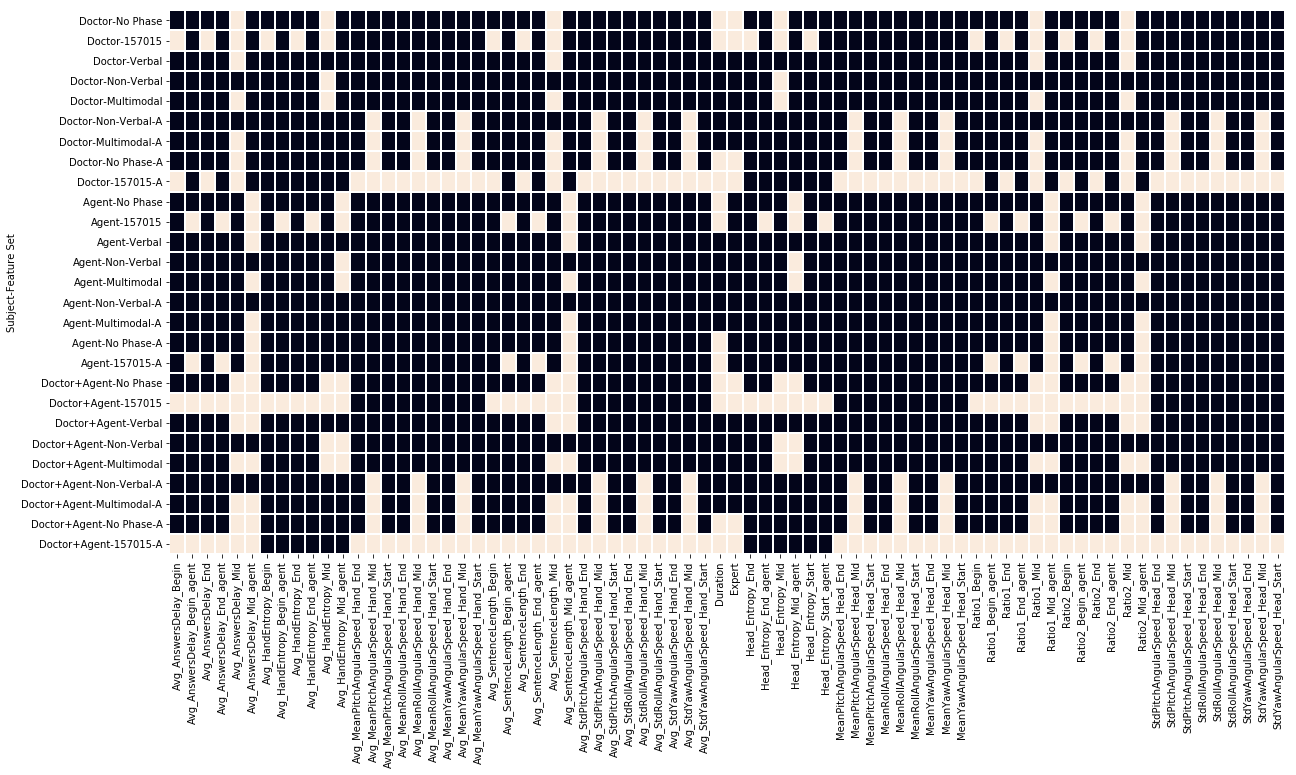

In [12]:

plt.figure(figsize=(20,10))
sns.heatmap(features_df.fillna(0).astype('int'), linecolor='white', linewidth=1, annot=False, cbar=False)
plt.savefig(os.path.join(config.OUT_PATH, 'features_sets.png'), bbox_inches = "tight")
plt.show()

# to avoid updating everything below for now

subject_features = get_features_set('Doctor', '157015')
agent_features = get_features_set('Agent', '157015')
all_features = get_features_set('Doctor+Agent', '157015')
subject_features_nophase = get_features_set('Doctor', 'No Phase')
agent_features_nophase = get_features_set('Agent', 'No Phase')
all_features_nophase = get_features_set('Doctor+Agent', 'No Phase')
subject_features_verbal = get_features_set('Doctor', 'Verbal')
agent_features_verbal = get_features_set('Agent', 'Verbal')
all_features_verbal = get_features_set('Doctor+Agent', 'Verbal')
subject_features_nonverbal = get_features_set('Doctor', 'Non-Verbal')
agent_features_nonverbal = get_features_set('Agent', 'Non-Verbal')
all_features_nonverbal = get_features_set('Doctor+Agent', 'Non-Verbal')
subject_features_multimodal = get_features_set('Doctor', 'Multimodal')
agent_features_multimodal = get_features_set('Agent', 'Multimodal')
all_features_multimodal = get_features_set('Doctor+Agent', 'Multimodal')
#subject_features_multimodal_duration = get_features_set('Doctor', 'Multimodal+Duration')
#agent_features_multimodal_duration = get_features_set('Agent', 'Multimodal+Duration')
#all_features_multimodal_duration = get_features_set('Doctor+Agent', 'Multimodal+Duration')


## Dataset preparation

In [13]:


out_path = os.path.join(config.OUT_PATH, 'gridsearchcv')
if not os.path.exists(out_path): os.makedirs(out_path)
    
OUT_PATH=os.path.join(config.OUT_PATH, 'cleaned-20190422')

def discretize_class(samples, prediction_type='classification', prediction_task='presence', bins=None, strategy=None, test_set=0.1):
    """
    Discretizes presence or co-presence score and put result in a new column (if not already existing).
    
    Returns: the name of the new column, or None if one of discretized groups only has 2 samples or less, or if discretization
    failed for any reason.
    """
    
    if prediction_type == 'regression':
        if prediction_task == 'presence':
            return 'Presence Score'
        else:
            return 'Co-presence Score'
    
    cols = []
    for col in samples.columns:
        if 'core' in col:
            cols.append(col)
    print('discretize_class columns %s' % str(cols))
    if bins is None or strategy is None:
        if prediction_task == 'presence':
            class_column='PresenceClass'
        else:
            class_column='CopresenceClass'
        return class_column
    else:
        if prediction_task == 'presence':
            score_column = 'Presence Score'
            class_column = 'PresenceClass_%d_%s' % (bins, strategy)
        else:
            score_column = 'Co-presence Score'
            class_column = 'CopresenceClass_%d_%s' % (bins, strategy)      
    
    if class_column not in samples.columns:
        samples[class_column], enc = discretize(samples[score_column], bins, strategy)
        samples[class_column] = samples[class_column].astype(int)
        #TODO: transform test data with discretizer fit on train data
    
    if any(samples[class_column] == -1) or any(samples[class_column].value_counts() < 3):
        return None
    else:
        return class_column

def prepare_train_data(samples, features, prediction_task, bins=None, strategy=None, upsample=None, test_set=0.1, n_splits=1, clf=None, verbose=0):
    """
    Prepares a dataset for ML.
    
    Parameters
    ----------
    
    samples: DataFrame
    
    features: list
    
    prediction_task: str
        'presence' or 'copresence'
        
    bins: None or int, default None.
        Number of classes to create when discretizing presence and co-presence.
        If 0 there no discretization is applied and returned y is for a regression task.
    
    strategy: None, 'kmeans', 'uniform' or 'quantile', default None.
        See sklearn, if None defaults to original strategy.
        
    upsample: None or str, default None
        None: no oversampling
        For description of other oversampling method see https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
        imb_random
        imb_smote
        imb_adasyn
        imb_smotenc
        imb_borderlinesmote1
        imb_borderlinesmote2
        imb_svmsmote
        
    test_set: None or float, default 0.1
        If not None or 0, a test set will produced with specified float as test ratio
        
    n_splits: int, default 1
        Will produce this number of train/test splits.
    
    arff: str
        If str, arff files will be generated using provided path/name. Default is None.
        
    clf: object
        Depending on classifier some specific preparation may occur (for JNCC2Wrapper, .arff files are generated)
        
    Returns
    -------
    An array of tuples (X, y, X_test, y_test).
    
    """
    if verbose > 0:
        print('prepare_train_data(samples nb=%d, features=%s, prediction_task=%s, bins=%s, strategy=%s, upsample=%s, test_set=%f, n_splits=%d, clf=%s)' 
              % (len(samples), str(features), prediction_task, str(bins), str(strategy), str(upsample), test_set, n_splits, clf.__class__.__name__))
        #print('prepare_train_data: unique %d' %  len(np.unique(samples.loc[:, features], return_counts=True, axis=0)[1]))
    
    return_tuples = []
    
    # TODO: should fit discretizer on train then transform train and test
    if bins == 0:
        class_column = 'Presence Score'
    else:
        class_column = discretize_class(samples, 'classification', prediction_task, bins, strategy)
    print('class_column: %s' % class_column)
    if test_set is not None and test_set > 0:
        if bins == 0:
            sss = ShuffleSplit(n_splits=n_splits, test_size=test_set, random_state=RANDOM_STATE)
            splits = [[split[0], split[1]] for split in sss.split(np.zeros(len(samples)), samples[class_column])]
        else:
            sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_set, random_state=RANDOM_STATE)
            splits = [[split[0], split[1]] for split in sss.split(np.zeros(len(samples)), samples[class_column])]
    else:
        splits = [[None, None]]
    print("splits " + str(splits))
    for idx, split in enumerate(splits):
        train_idx = split[0]
        test_idx = split[1]
        print("train " + str(train_idx) + ", test " + str(test_idx))
        if train_idx is None or test_idx is None:
            X = samples.loc[:, features].fillna(0)
            y = samples[class_column]
            X_test = None
            y_test = None
        else:
            X = samples.loc[train_idx, features].fillna(0)
            X_test = samples.loc[test_idx, features].fillna(0)
            y = samples.loc[train_idx, class_column]
            y_test = samples.loc[test_idx, class_column]        
        
        ros = None
        if upsample == 'imb_random':
            ros = RandomOverSampler(random_state=RANDOM_STATE)
        elif upsample == 'imb_smote':
            ros = SMOTE(random_state=RANDOM_STATE) 
        elif upsample == 'imb_adasyn':
            ros = ADASYN(random_state=RANDOM_STATE)
        elif upsample == 'imb_smotenc':
            if 'Expert' in features:        
                # SMOTENC is the only one dealing specifically with categorical data (ie 'Expert' feature)
                categorical_vars_indices = [list(features).index('Expert')]
                ros = SMOTENC(random_state=RANDOM_STATE, categorical_features=categorical_vars_indices)
            else:
                ros = SMOTE(random_state=RANDOM_STATE)

        elif upsample == 'imb_borderlinesmote1':
            ros = BorderlineSMOTE(kind='borderline-1', random_state=RANDOM_STATE)      
        elif upsample == 'imb_borderlinesmote2':
            ros = BorderlineSMOTE(kind='borderline-2', random_state=RANDOM_STATE)     
        elif upsample == 'imb_svmsmote':
            ros = SVMSMOTE(random_state=RANDOM_STATE)

        if ros is not None:
            # test set is never oversampled
            print("prepare_train_data: Applying %s oversampling to data %d / %s / unique %d" 
                  % (ros.__class__.__name__, len(X), collections.Counter(y), 
                     len(np.unique(X, return_counts=True, axis=0)[1]))) 
            X, y = ros.fit_resample(X, y)     
            X = pd.DataFrame(X, columns=features)
            print("prepare_train_data: Resampled data %d / %s / unique %d" 
                  % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))

        # special treatment for JNCC2, generate .arff files
        if isinstance(clf, JNCC2Wrapper):
            if bins == 0:
                print("ERROR: arff can only be generated for classification task")
                return None
            else:
                arff_path = os.path.join(clf.arff_root_path_, str(idx))
                clf.generate_arff(os.path.join(arff_path, 'train'), features, prediction_task, X, y)
                if test_set is not None and test_set > 0:
                    clf.generate_arff(os.path.join(arff_path, 'test'), features, prediction_task, X_test, y_test)                
                
        return_tuples.append( (X, y, X_test, y_test) )
        
    return return_tuples

def gridsearch(clf, X, y, prediction_task, param_grid, features, cv=10, verbose=0):
    if verbose > 0:
        print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s)" 
              % (type(clf), prediction_task, param_grid, features))

    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))
    print(np.unique(y, return_counts=True))
    grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='f1_macro',
                        cv=cv,
                        return_train_score=True,
                        n_jobs=-1,
                        verbose=verbose)
    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

# prepare results
def update_results_from_gridsearch(rdf, cv_results_, p1, p2, p3, p4, p5):
    df = pd.DataFrame(cv_results_)
    best_precision = df.mean_test_precision_macro.max()
    df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
    if p5 == 'score':
        cols = [col for col in df_best.columns if ('mean_test_' in col)]
    elif p5 == 'err':
        cols = [col for col in df_best.columns if ('mean_std_' in col)]
    print('update_results_from_gridsearch: cols %s' % cols)
    update_results(rdf, df_best[cols], p1, p2, p3, p4, p5)
    return rdf

def update_results(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.iloc[0].loc[col]
    return rdf


def update_results_single(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.loc[col]
    return rdf

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

if 'PresenceClass_5_kmeans' in all_p_df.columns:
    all_np_df = all_np_df.drop(['PresenceClass_5_kmeans'], axis=1)
    
dataset = all_p_df
featureset = get_features_set('Doctor+Agent', '157015-A')
print(featureset)
nb = 100
ds_splits = prepare_train_data(dataset, featureset,
                                          'presence', bins=2, strategy='uniform', upsample=None, test_set=0.1, n_splits=nb,  verbose=0)
#print('Generated %d splits' % len(ds_splits))
scores = np.zeros((nb, 7))

for idx, (X, y, X_test, y_test) in enumerate(ds_splits):
    #print(np.unique(y, return_counts=True))
    print('X ' + str(X.shape))
    sc = StandardScaler()
    X = sc.fit_transform(X)
    X_test = sc.transform(X_test)
    print("y : %s" % str(np.unique(y, return_counts=True)))
    
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel

    lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    print('LSVC feature selection from %s to %s' % (str(X.shape), str(X_new.shape)))
    
    from sklearn.model_selection import StratifiedKFold
    from sklearn.feature_selection import RFECV
    
    lsvc = LinearSVC(C=0.1, penalty="l1", dual=False)
    rfecv = RFECV(estimator=lsvc, step=1, cv=StratifiedKFold(10), scoring='f1')
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', n_components=5)
    lda.fit(X, y)
    y_pred = lda.predict(X_test)
    scores[idx, 0] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    scores[idx, 1] = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    print('X ' + str(X.shape) + ', coef_ ' + str(lda.coef_))
    
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X, y)
    y_pred = qda.predict(X_test)
    scores[idx, 2] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    scores[idx, 3] = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    print(str(scores[idx]))
    #trans = lda.transform(X)
    #trans_test = lda.transform(X_test)
    #plt.scatter(trans[:, 0], trans[:, 1], c=y, marker='o')
    #plt.scatter(trans_test[:, 0], trans_test[:, 1], c=y_test, marker='x')
    #plt.show()
    
    dummy = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
    dummy.fit(X,y)
    y_pred = dummy.predict(X_test)
    scores[idx, 4] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    
    dummy = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
    dummy.fit(X,y)
    y_pred = dummy.predict(X_test)
    scores[idx, 5] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    
    dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
    dummy.fit(X,y)
    y_pred = dummy.predict(X_test)
    scores[idx, 6] = balanced_accuracy_score(y_test, y_pred, adjusted=False)    
means = np.mean(scores, axis=0)
print('mean ' + str(means))
best_rnd = np.max(means[4:-1])
print('best random' + str(best_rnd))
print('adjusted with best rnd ' + str(means[0] - best_rnd))

print('std ' + str(np.std(scores, axis=0) / nb))


In [ ]:
print(lsvc.coef_)
print(lsvc.score(X_test, y_test))

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
dummy.fit(X,y)
y_pred = dummy.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred, adjusted=False))
print(balanced_accuracy_score(y_test, y_pred, adjusted=True))

In [ ]:
try:
    del sys.modules['feutils']
    del sys.modules['config']
except:
    pass
from feutils import DataHandler
from feutils import JNCC2Wrapper
import config

if 'PresenceClass_5_kmeans' in all_p_df.columns:
    all_np_df = all_np_df.drop(['PresenceClass_5_kmeans'], axis=1)
    
dataset = all_np_df
featureset = get_features_set('Doctor', 'Multimodal-A')
dh = DataHandler('__tests', 'jncc2', 0)
print(featureset)
nb = 100
jncc = JNCC2Wrapper(dh)
ds_splits = prepare_train_data(dataset, featureset,
                                          'presence', bins=5, strategy='kmeans', upsample='imb_smotenc', test_set=0.1, n_splits=nb, clf=jncc, verbose=0)
#print('Generated %d splits' % len(ds_splits))
scores = np.zeros((nb, 2))

for idx, (X, y, X_test, y_test) in enumerate(ds_splits):
    #print(np.unique(y, return_counts=True))
    #print('X ' + str(X.shape))
    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    #X_test = sc.transform(X_test)
    
    #print(dataset['Presence Score'])
    #print(dataset['Presence Score'].iloc[y.index])

    jncc_cv, y_trues_cv = jncc.cv('train.arff', 0)
    
    jncc_result, y_true_predict = jncc.predict('train.arff', 'test.arff', 0)
    
    # make it regression
    y_train, enc = discretize(dataset['Presence Score'], 3, 'kmeans')
    idx_train = y.index
    idx_test = y_test.index
    y = y_train[idx_train]
    y_test = y_train[idx_test]
    y_reg = dataset['Presence Score'].iloc[idx_train]
    y_reg_test = dataset['Presence Score'].iloc[idx_test]
    
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.feature_selection import RFE
    
    #reg = linear_model.Lasso(alpha=0.1)
    reg = RandomForestRegressor(n_estimators=500)
    rfe = RFE(estimator=reg, n_features_to_select=2, step=1)
    
    #reg = LogisticRegression()
    rfe.fit(X, y_reg)
    print(zip(featureset.to_numpy(), rfe.support_))
    print("Regression score %f" % reg.score(X_test, y_reg_test))
    y_reg_pred = reg.predict(X_test)
    print(zip(featureset.to_numpy(), reg.feature_importances_))
    
    #print(enc.inverse_transform(y_train))
    #print("shape " + str(y_train.shape))
    #print("shape pred " + str(np.array(y_reg_pred).reshape(-1, 1).shape))
    y_pred = enc.transform(np.array(y_reg_pred).reshape(-1, 1))
    
    scores[idx, 0] = balanced_accuracy_score(y_test, y_pred, adjusted=False)
    scores[idx, 1] = balanced_accuracy_score(y_test, y_pred, adjusted=True)
    
print('mean ' + str(np.mean(scores, axis=0)))
print('std ' + str(np.std(scores, axis=0) / nb))

In [ ]:
print('CV %d results' % len(jncc_cv))
print('CV #0 %s' % str(jncc_cv[0]))
print(y_trues_cv[0])
display(HTML(jncc_result.to_html()))

In [ ]:
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.preprocessing import LabelBinarizer

def compute_lrap(y_true, y_pred, labels):
    if type(y_true) is np.ndarray:
        y_true = pd.DataFrame(y_true)
    if type(y_pred) is np.ndarray:
        y_pred = pd.DataFrame(y_pred)
    lb = LabelBinarizer()
    lb.fit(labels)
    y_score = np.zeros(y_pred.values.shape)
    for i in np.arange(y_score.shape[1]):
        col = y_pred.iloc[:, i]
        binarized = lb.transform(col)
        y_score = y_score + (binarized.astype(float) / (i+1))
    y_true_bin = lb.transform(y_true.values.reshape(-1,1))
    return label_ranking_average_precision_score(y_true_bin, y_score)

print(compute_lrap(y_test, jncc_result, [0,1,2,3,4]))
cv_lraps = [compute_lrap(y_trues_cv[i], jncc_cv[i], [0,1,2,3,4]) for i in np.arange(len(jncc_cv))]
cv_lraps = np.array(cv_lraps)
print(cv_lraps)
print(cv_lraps.mean())
print(cv_lraps.std())
print(balanced_accuracy_score(y_true_predict, jncc_result.iloc(axis=1)[0], adjusted=True))

## Feature importance

In [14]:
# from rfpimp

def dropcol_importances_sklearn(model, X_train, y_train, X_valid=None, y_valid=None, metric=None, sample_weights=None):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.
    return: A data frame with Feature, Importance columns

    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """

    if X_valid is None: X_valid = X_train
    if y_valid is None: y_valid = y_train
    model_ = clone(model)
    #model_.random_state = RANDOM_STATE
    model_.fit(X_train, y_train)

    if callable(metric):
        baseline = metric(model_, X_valid, y_valid)
    else:
        baseline = model_.score(X_valid, y_valid)
    print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        print("column " + col)
        model__ = clone(model)
        #model__.random_state = RANDOM_STATE
        X_tr = X_train.drop(col, axis=1)
        X_va = X_valid.drop(col, axis=1)
        model__.fit(X_tr, y_train)
        if callable(metric):
            s = metric(model__, X_va, y_valid)
        else:
            s = model__.score(X_va, y_valid)
        print("new score " + str(s))
        drop_in_score = baseline - s
        imp.append(drop_in_score)

    imp = np.array(imp)

    #I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=False)
    
    return imp #I

def dropcol_importances(rf, X_train, y_train, random_state):
    rf_ = clone(rf)
    rf_.random_state = random_state
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    #print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = random_state
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    #I = pd.DataFrame(
    #        data={'Feature':X_train.columns,
    #              'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=True)
    return imp #I

## GridSearch

In [27]:
def score_forest(estimator, X_, y_):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    #all_feature_importances.append(estimator.feature_importances_) # global variable - ugly trick
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def svm_fi(estimator, X_, y_):
    # for SVM dropcol feature importances computation, we use validation data (X_, y_) and train data (X, y) are global.
    #X_train_df = pd.DataFrame(X, columns=feats)
    #y_train_df = pd.DataFrame(y)
    #X_valid_df = pd.DataFrame(X_, columns=feats)
    #y_valid_df = pd.DataFrame(y_)
    #dcs = dropcol_importances_sklearn(clf, X_train_df, y_train_df, X_valid_df, y_valid_df)
    #all_dropcol_feature_importances.append(dcs)
    #print(dcs)
    return 0

def build_scoring(clf, y):
    labels = sorted(np.unique(y).astype(int))
    
    scoring = {}
    scoring['f1_macro'] = 'f1_macro'
    for idx, label in enumerate(labels):
        scoring['f1_macro_class_%d' % label] = make_scorer(f1_score, labels=[label], average='weighted')
    scoring['precision_macro'] = 'precision_macro'
    for idx, label in enumerate(labels):
        scoring['precision_macro_class_%d' % label] = make_scorer(precision_score, labels=[label], average='weighted')    
    scoring['recall_macro'] = 'recall_macro'
    for idx, label in enumerate(labels):
        scoring['recall_macro_class_%d' % label] = make_scorer(recall_score, labels=[label], average='weighted')     
    
    if type(clf) == RandomForestClassifier:
        scoring ['oob'] = score_forest
    else:
        scoring['fi'] = svm_fi    
        
    return scoring

def run_cross_val_score(clf, X, y, idx=None, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = build_scoring(clf, y)
    
    if not isinstance(clf, JNCC2Wrapper):
        cross_val_scores = cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)
        
    else:
        labels = sorted(np.unique(y).astype(int))        
        cross_val_scores = {}
        cross_val_scores['val_f1_weighted'] = []
        for idx, label in enumerate(labels):
            cross_val_scores['val_f1_weighted_class_%d' % label] = []
        cross_val_scores['val_precision_weighted'] = []
        for idx, label in enumerate(labels):
            cross_val_scores['val_precision_weighted_class_%d' % label] = []   
        cross_val_scores['val_recall_weighted'] = []
        for idx, label in enumerate(labels):
            cross_val_scores['val_recall_weighted_class_%d' % label] = []     
        cross_val_scores['val_mrr'] = []
        
            
        jncc_cv, y_trues_cv = clf.cv('train.arff', idx)
        
        cross_val_scores['score_time'] = [0]*len(jncc_cv)
        
        for i in np.arange(len(jncc_cv)):
            y_true = y_trues_cv[i]
            y_pred = jncc_cv[i][:, 0]
            cross_val_scores['val_f1_weighted'].append(f1_score(y_true, y_pred, average='weighted'))
            for idx, label in enumerate(labels):
                cross_val_scores['val_f1_weighted_class_%d' % label].append(f1_score(y_true, y_pred, labels=[label], average='weighted'))
            cross_val_scores['val_precision_weighted'].append(precision_score(y_true, y_pred, average='weighted'))
            for idx, label in enumerate(labels):
                cross_val_scores['val_precision_weighted_class_%d' % label].append(precision_score(y_true, y_pred, labels=[label], average='weighted'))    
            cross_val_scores['val_recall_weighted'].append(recall_score(y_true, y_pred, average='weighted'))
            for idx, label in enumerate(labels):
                cross_val_scores['val_recall_weighted_class_%d' % label].append(recall_score(y_true, y_pred, labels=[label], average='weighted'))    
            print('y_true %s y_pred %s' % (y_true.shape, jncc_cv[i].shape))
            cross_val_scores['val_mrr'].append(feu.compute_mrr(y_true, jncc_cv[i], labels))

            
    print('run_cross_val_score: return %s' % str(cross_val_scores))

    return cross_val_scores

def run_gridsearch(clf, param_grid, data, features, prediction_task, repeat=10, repeat_dc=300, test_set=0.1, n_splits=1, upsample=None, fi=False, bins=None, strategy=None, force_gs=True, 
                   verbose=0):
    print('run_gridsearch(clf=%s, param_grid=%s, bins=%d, strategy=%s)' % (clf.__class__.__name__, str(param_grid), bins, strategy))
    X_test = None
    y_test = None
    create_test_set = test_set is not None and test_set > 0
    best_params = None
    grid = None
    is_jncc = isinstance(clf, JNCC2Wrapper)
    print('is_jncc: %s' % str(is_jncc))
    print(clf)
    print(type(clf))
    
    all_scores = []
    all_test_scores = []    
    all_supports = []
    all_test_supports = []
    fi_method = []
    fi_fs = pd.DataFrame(np.zeros((1, len(features_df.columns))), columns=features_df.columns)
    
    splits = prepare_train_data(samples=data, features=features, prediction_task=prediction_task, test_set=test_set, n_splits=n_splits,
                                upsample=upsample, bins=bins, strategy=strategy, clf=clf, verbose=verbose)

    for idx, (X, y, X_test, y_test) in enumerate(splits):
        print("*** Train/Test Split #%d" % idx)
        y = y.astype(int)
        support = np.unique(y, return_counts=True)
        support_test = None
        if y_test is not None:
            y_test = y_test.astype(int)
            support_test = np.unique(y_test, return_counts=True)
        all_supports.append(str(support))
        all_test_supports.append(str(support_test))
        
        # first evaluate best params through grid search for this particular dataset/featureset
        # !!! important, see http://www.jmlr.org/papers/volume11/cawley10a/cawley10a.pdf
        # use 'force_gs' so hyper-parameters search is performed independently on each train split before evaluation on test, which would be unbiased protocol
        if best_params is None or force_gs :
            if len(ParameterGrid(param_grid)) > 1:
                grid = gridsearch(clf, 
                                  X, y, 
                                  prediction_task, 
                                  param_grid=param_grid, 
                                  features=features, 
                                  verbose=verbose)
                best_params = grid.best_params_
                single_best_score = grid.best_score_

                print('  Gridsearch evaluated best score %s' % (single_best_score))
                print('  Gridsearch best params : %s' % str(best_params))

            else:
                print('run_gridsearch: only 1 set of parameters, gridsearch not required')
                best_params = ParameterGrid(param_grid)

        if create_test_set:

            # compute cv scores (redundant with gridsearch ?)
            
            if not is_jncc:

                if grid is not None:
                    best_clf = sklearn.base.clone(grid.best_estimator_)
                else:
                    best_clf= clf
                val_scores = run_cross_val_score(best_clf, X, y, verbose=verbose)
                            
            else:
                
                val_scores = run_cross_val_score(clf, X, y, idx=idx, verbose=verbose)
                
                
    
            #jncc_result, y_true_predict = jncc.predict('train.arff', 'test.arff', 0)
                
            val_scores = pd.DataFrame(val_scores)
            all_scores.append(val_scores)

            # compute test scores
            
            labels = sorted(support[0])
            print("LABELS " + str(labels))            

            if not is_jncc:
            
                if grid is not None:
                    best_clf = sklearn.base.clone(grid.best_estimator_)
                else:
                    best_clf = clf
                best_clf.fit(X, y)
                y_pred = best_clf.predict(X_test)
                
                # retrieve feature selection information, if any was performed
                if type(best_clf) == Pipeline:
                    if 'rfecv' in best_clf.named_steps:
                        fi_method = 'RFECV(%s)'
                        masked_features = best_clf.named_steps['rfecv'].support_
                        print('  Selected features %s' % str(features[masked_features]))
                        for ifeat in features[masked_features]:
                            fi_fs[ifeat] += 1
                    elif 'selectfrommodel' in best_clf.named_steps:
                        masked_features = best_clf.named_steps['selectfrommodel'].get_support()
                        print('  Selected features %s' % str(features[masked_features]))
                        for ifeat in features[masked_features]:
                            fi_fs[ifeat] += 1      
                    elif 'selectkbest' in best_clf.named_steps:
                        masked_features = best_clf.named_steps['selectkbest'].get_support()
                        print('  Selected features %s' % str(features[masked_features]))
                        for ifeat in features[masked_features]:
                            fi_fs[ifeat] += 1   
                
            else:
                # for JNCC (multilabel result), usual scores are computed thanks to first prediction, and MRR is computed based on ranked predictions
                jncc_result, y_true = clf.predict('train.arff', 'test.arff', idx)
                y_pred = jncc_result.iloc(axis=1)[0]
            
            
            test_scores_row = {
                'test_balanced_acc': balanced_accuracy_score(y_test, y_pred),
                #'test_balanced_acc_adjusted': balanced_accuracy_score(y_test, y_pred, adjusted=True),
                'test_f1_macro_weighted': f1_score(y_test, y_pred, average='weighted') }
            for idx, label in enumerate(labels):
                test_scores_row['test_f1_macro_class_%d' % label] = f1_score(y_test, y_pred, labels=[label], average='weighted')
            test_scores_row['test_precision_macro_weighted'] =  precision_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores_row['test_precision_macro_class_%d' % label] = precision_score(y_test, y_pred, labels=[label], average='weighted')            
            test_scores_row['test_recall_macro_weighted'] =  recall_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores_row['test_recall_macro_class_%d' % label] = recall_score(y_test, y_pred, labels=[label], average='weighted')     
            if is_jncc:
                test_scores_row['test_mrr'] = feu.compute_mrr(y_test, jncc_result, labels)
                # TODO: add scores performed by JNCC2 ? (single accuracy etc)
                
            # Compute dummy classifier scores using different strategies, as a baseline
            for dummy_strat in ['uniform', 'stratified', 'most_frequent']:
                dummy = DummyClassifier(strategy=dummy_strat, random_state=RANDOM_STATE)
                dummy.fit(X, y)
                y_pred = dummy.predict(X_test)
                test_scores_row ['rnd_%s_balanced_acc' % dummy_strat] = balanced_accuracy_score(y_test, y_pred)
                test_scores_row['rnd_%s_f1_macro_weighted' % dummy_strat] = f1_score(y_test, y_pred, average='weighted')
                for idx, label in enumerate(labels):
                    test_scores_row['rnd_%s_f1_macro_class_%d' % (dummy_strat, label)] = f1_score(y_test, y_pred, labels=[label], average='weighted')
                test_scores_row['rnd_%s_precision_macro_weighted' % dummy_strat] =  precision_score(y_test, y_pred, average='weighted')
                for idx, label in enumerate(labels):
                    test_scores_row['rnd_%s_precision_macro_class_%d' % (dummy_strat, label)] = precision_score(y_test, y_pred, labels=[label], average='weighted')            
                test_scores_row['rnd_%s_recall_macro_weighted' % dummy_strat] =  recall_score(y_test, y_pred, average='weighted')
                for idx, label in enumerate(labels):
                    test_scores_row['rnd_%s_recall_macro_class_%d' % (dummy_strat, label)] = recall_score(y_test, y_pred, labels=[label], average='weighted')                  

            test_scores_df = pd.DataFrame([test_scores_row], index=['score'])
            all_test_scores.append(test_scores_df)

            """from sklearn.metrics import roc_curve, auc

            y_predict_proba = clf.predict_proba(X_test)

            # Compute ROC curve and ROC AUC for each class
            n_classes = 3
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            all_y_test_i = np.array([])
            all_y_predict_proba = np.array([])
            for i in range(n_classes):
                y_test_i = map(lambda x: 1 if x == i else 0, y_test)
                all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
                all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
                fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Compute micro-average ROC curve and ROC area
            fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
            roc_auc["average"] = auc(fpr["average"], tpr["average"])


            # Plot average ROC Curve
            plt.figure()
            plt.plot(fpr["average"], tpr["average"],
                     label='Average ROC curve (area = {0:0.2f})'
                           ''.format(roc_auc["average"]),
                     color='deeppink', linestyle=':', linewidth=4)

            # Plot each individual ROC curve
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], lw=2,
                         label='ROC curve of class {0} (area = {1:0.2f})'
                         ''.format(i, roc_auc[i]))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC curve %s / %s / test set ? %s / oversampling %s' % (clf.__class__.__name__, prediction_task, 
                                                                               test_set, upsample))
            plt.legend(loc="lower right")
            plt.show()"""

        if not create_test_set:
            print('    Running %d 10-folds cv iterations on best classifier %s ...' % (repeat, best_params))

            global all_feature_importances
            global all_dropcol_feature_importances
            
            if grid is not None:
                best_clf = sklearn.base.clone(grid.best_estimator_) 
            else:
                best_clf = clf
            
            for i in np.arange(repeat):
                #forest = RandomForestClassifier(oob_score=True)
                # set best params to classifier

                scores = run_cross_val_score(best_clf, 
                                  X, y,  
                                  verbose=verbose)
                print("iter # %d" % i)
                #    print(scores)
                scores_df = pd.DataFrame(scores)
                #print(scores_df)
                #print(scores_df.columns)
                all_scores.append(scores_df)



            # compute feature importance for random forest : we don't need validation data as it relies on oob score
            if type(clf) == RandomForestClassifier:
                all_feature_importances = pd.DataFrame(all_feature_importances, columns=features)        
                if fi:
                    X_ = pd.DataFrame(X, columns=features)
                    y_ = pd.DataFrame(y)        
                    for i in np.arange(repeat_dc):
                        # alternative computation for feature importance
                        all_dropcol_feature_importances.append(dropcol_importances(best_clf, X_, y_, RANDOM_STATE+i))
            else:
                all_feature_importances = None
                all_dropcol_feature_importances = None
                '''print(X, y)
                skf = StratifiedKFold(n_splits=repeat, random_state=RANDOM_STATE, shuffle=True)
                for i in np.arange(repeat_dc):
                    for train_index, test_index in skf.split(X, y):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]
                        X_train = pd.DataFrame(X_train, columns=features)
                        X_test = pd.DataFrame(X_test, columns=features)
                        y_train = pd.DataFrame(y_train)
                        y_test = pd.DataFrame(y_test)
                        # alternative computation for feature importance
                        dcs = dropcol_importances_sklearn(clf, X_train, y_train, X_test, y_test, RANDOM_STATE+i)
                        print("X_train %s X_test %s y_train %s y_test %s" % (len(X_train), len(X_test), len(y_train), len(y_test)))
                        print(dcs)
                        all_dropcol_feature_importances.append(dcs)'''

            #all_scores = pd.concat(all_scores)
            if all_dropcol_feature_importances is not None:
                all_dropcol_feature_importances = pd.DataFrame(all_dropcol_feature_importances, columns=features)

    if len(all_scores) == 1:
        all_scores = all_scores[0]
    elif len(all_scores) > 0:
        all_scores = pd.concat(all_scores)
    else:
        all_scores = pd.DataFrame()
    if len(all_test_scores) == 1:
        all_test_scores = all_test_scores[0]
    elif len(all_test_scores) > 0:
        all_test_scores = pd.concat(all_test_scores)
    else:
        all_test_scores = pd.DataFrame()
        
    result = {
        'all_scores': all_scores,
        'all_test_scores': all_test_scores,
        'dropcol_fi': all_dropcol_feature_importances,
        'fi': all_feature_importances,
        'fi_fs': fi_fs,
        'support': support,
        'support_test': support_test
    }
        
    return grid, result


## Test plan utilities

### Gridsearch hyper-parameters ranges

In [16]:
# random forests
param_grid_rf =  {
    'n_estimators' : [300],
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_leaf': [1],
    'criterion': ['gini', 'entropy']
}
# for quickly testing the loops
param_grid_rf_tests = {
    'n_estimators' : [10],
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_leaf': [1],
    'criterion': ['gini', 'entropy']
}
# SVM
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}
# Gaussian Naive Bayes
param_grid_gnb = {
    'gaussiannb__priors': [None], 
    'gaussiannb__var_smoothing': [1e-09]
}

param_grid_jncc2 = {}

### Global configuration

In [17]:
# TOTO
from sklearn.ensemble import RandomForestRegressor

def get_categorical_features(X):
    if 'Expert' in X.columns:
        return ['Expert']
    else:
        return []
    
ct = make_column_transformer(
    (FunctionTransformer(), get_categorical_features), # default FunctionTransformer implements identity
    remainder=StandardScaler()
)

configuration = {
    'subject': {
        'doctor': {
            'name': 'Doctor',
            'modes': {
                'verbal': {
                    'dataset': subject_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': subject_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': subject_np_df,
                    'name': 'Multimodal'
                },
                'nonverbal-a': {
                    'dataset': subject_np_df,
                    'name': 'Non-Verbal-A'
                },
                'multimodal-a': {
                    'dataset': subject_np_df,
                    'name': 'Multimodal-A'
                },
            },
            'phases': {
                'nophase': {
                    'dataset': subject_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': subject_p_df,
                    'name': '157015'
                },
                'nophase-a': {
                    'dataset': subject_np_df,
                    'name': 'No Phase-A'
                },
                '157015-a': {
                    'dataset': subject_p_df,
                    'name': '157015-A'
                }    
            }
        },
        'agent': {
            'name': 'Agent',
            'modes': {
                'verbal': {
                    'dataset': agent_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': agent_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': agent_np_df,
                    'name': 'Multimodal'
                },
                'nonverbal-a': {
                    'dataset': agent_np_df,
                    'name': 'Non-Verbal-A'
                },
                'multimodal-a': {
                    'dataset': agent_np_df,
                    'name': 'Multimodal-A'
                },
            },
            'phases': {
                'nophase': {
                    'dataset': agent_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': agent_p_df,
                    'name': '157015'
                },
                'nophase-a': {
                    'dataset': agent_np_df,
                    'name': 'No Phase-A'
                },
                '157015-a': {
                    'dataset': agent_p_df,
                    'name': '157015-A'
                }                
            }            
        },
        'doctor+agent': {
            'name': 'Doctor+Agent',
            'modes': {
                'verbal': {
                    'dataset': all_np_df,
                    'name': 'Verbal'
                },
                'nonverbal': {
                    'dataset': all_np_df,
                    'name': 'Non-Verbal'
                },
                'multimodal': {
                    'dataset': all_np_df,
                    'name': 'Multimodal'
                },
                'nonverbal-a': {
                    'dataset': all_np_df,
                    'name': 'Non-Verbal-A'
                },
                'multimodal-a': {
                    'dataset': all_np_df,
                    'name': 'Multimodal-A'
                },
            },
            'phases': {
                'nophase': {
                    'dataset': all_np_df,
                    'name': 'No Phase'
                },
                '157015': {
                    'dataset': all_p_df,
                    'name': '157015'
                },
                'nophase-a': {
                    'dataset': all_np_df,
                    'name': 'No Phase-A'
                },
                '157015-a': {
                    'dataset': all_p_df,
                    'name': '157015-A'
                }                
            }            
        }        
    },
    'features': {
        'verbal': 'Verbal',
        'nonverbal': 'Non-Verbal',
        'multimodal': 'Multimodal',
        'multimodal+duration': 'Multimodal+Duration',
        '157015': '157015',
        'nophase': 'No Phase',
        'nonverbal-a': 'Non-Verbal-A',    
        'multimodal-a': 'Multimodal-A',
        '157015-a': '157015-A',
        'nophase-a': 'No Phase-A',        
    },
    'classifier': {
        'forest': {
            'clf': RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True),
            'param_grid': param_grid_rf,
            'name': 'RF'
        },
        'forest-test': {
            'clf': RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True),
            'param_grid': param_grid_rf_tests,
            'name': 'RF-test'
        },        
        'r-forest': {
            'clf': RandomForestRegressor(random_state=RANDOM_STATE, oob_score=True),
            'param_grid': param_grid_rf,
            'name': 'RF-REGR'
        },
        'svm': {
            'clf': make_pipeline(ct, SVC(random_state=RANDOM_STATE, probability=True)),
            'param_grid': param_grid_svm,
            'name': 'SVM'
        },
        'gnb': {
            'clf': make_pipeline(ct, GaussianNB()),
            'param_grid': param_grid_gnb,
            'name': 'NB-G'
        },
        'jncc2': {
            'clf': JNCC2Wrapper(),
            'param_grid': param_grid_jncc2,
            'name': 'JNCC2'
            
        },
        'fs_rfe-svm-l2_gnb': {
            'clf': make_pipeline(ct, RFECV(estimator=LinearSVC(penalty='l2'), step=1, cv=10, scoring='f1'), GaussianNB()),  
            'param_grid': param_grid_gnb,
            'name': 'FS_RFE-SVM-L2_NB-G'
        },
        'fs_rfe-svm-l2_svm': {
            'clf': make_pipeline(ct, RFECV(estimator=LinearSVC(penalty='l2'), step=1, cv=10, scoring='f1'), SVC(random_state=RANDOM_STATE, probability=True)),
            'param_grid': param_grid_svm,
            'name': 'FS_RFE-SVM-L2_SVM'
        },        
        'fs_svm-l1_gnb': {
            'clf': make_pipeline(ct, SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', C=0.1)), GaussianNB()),
            'param_grid': param_grid_gnb,
            'name': 'FS_SVM-L1_NB-G'
        },
        'fs_svm-l1_svm': {
            'clf': make_pipeline(ct, SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', C=0.1)), SVC(random_state=RANDOM_STATE, probability=True)),
            'param_grid': param_grid_svm,
            'name': 'FS_SVM-L1_NB-G'
        },   
        'fs_kb5-chi2_gnb': {
            'clf': make_pipeline(ct, SelectKBest(chi2, k=5), GaussianNB()),
            'param_grid': param_grid_gnb,
            'name': 'FS_KB5-CHI2_NB-G'
        },
        'fs_kb5-mi_gnb': {
            'clf': make_pipeline(ct, SelectKBest(mutual_info_classif, k=5), GaussianNB()),
            'param_grid': param_grid_gnb,
            'name': 'FS_KB5-MI_NB-G'
        },           
        'name' : 'Classifier'
    },
    'prediction_task': {
        'presence': 'Presence',
        'copresence': 'Co-Presence'
    }
}

JNCC2Wrapper(dataHandler=None)


### Results utilities

In [18]:
def get_df_multiindex(test_plan_params, metric_level=True):
    iindex = []
    inames = ['Target', 'Subject']
    
    pred_level = []
    if 'presence' in test_plan_params['prediction_task']:
        pred_level.append('Presence')
    if 'copresence' in test_plan_params['prediction_task']:
        pred_level.append('Co-Presence')
    iindex.append(pred_level)
    
    subj_level = []
    if 'doctor' in test_plan_params['subject']:
        subj_level.append('Doctor')
    if 'agent' in test_plan_params['subject']:
        subj_level.append('Agent')
    if 'doctor+agent' in test_plan_params['subject']:
        subj_level.append('Doctor+Agent')
    iindex.append(subj_level)
        
    if 'modes' in test_plan_params.keys():
        exps = test_plan_params['modes']
        exps_name = 'Mode'
    elif 'phases' in test_plan_params.keys():
        exps = test_plan_params['phases']
        exps_name = 'Phases'

    exp_level = []
    for exp in exps:
        exp_level.append(configuration['features'][exp])
    if len(exp_level) > 0:
        iindex.append(exp_level)
        inames.append(exps_name)

    clf_level = []
    for clf_id in test_plan_params['classifier']:
        clf_level.append(configuration['classifier'][clf_id]['name'])
    if len(clf_level) > 0:
        iindex.append(clf_level)
        inames.append('Classifier')

    if 'upsampling' in test_plan_params.keys():
        up_level = []
        for up_id in test_plan_params['upsampling']:
            up_level.append(str(up_id))
        iindex.append(up_level)
        inames.append('Oversampling')
        
    if 'nbclasses' in test_plan_params.keys():
        cl_level = []
        for cl_id in test_plan_params['nbclasses']:
            cl_level.append(cl_id)
        iindex.append(cl_level)
        inames.append('Nb Classes')
        
    if 'clstrategy' in test_plan_params.keys():
        cls_level = []
        for cls_id in test_plan_params['clstrategy']:
            cls_level.append(str(cls_id))
        iindex.append(cls_level)
        inames.append('Classes discretization strategy')

    if metric_level:
        iindex.append(['score', 'err'])
        inames.append('Metric')

    scores_df_index = iindex
    print(scores_df_index)
    scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                      names = inames)
    return scores_df_multiindex

def get_results_tuple(test, upsample_strategy_default):
    subject = test['subject']
    subj_conf = configuration['subject'][subject]
    prediction_task = test['prediction_task']
    classifier = test['classifier']
    
    if 'modes' in test.keys():
        fset = test['modes']  
    elif 'phases' in test.keys():
        fset = test['phases']     

    if 'upsampling' in test:
        upsample = test['upsampling']
    else:
        upsample = upsample_strategy_default

    result_tuple = ()
    result_tuple = result_tuple + ('Presence',) if prediction_task == 'presence' else ('Co-Presence',)
    result_tuple = result_tuple + (subj_conf['name'],)
    result_tuple = result_tuple + (configuration['features'][fset],)
    result_tuple = result_tuple + (configuration['classifier'][classifier]['name'],)
    
    if 'upsampling' in test:
        result_tuple = result_tuple + (str(upsample),)
        
    if 'nbclasses' in test:
        result_tuple = result_tuple + (str(test['nbclasses']),)
    
    if 'clstrategy' in test:
        result_tuple = result_tuple + (str(test['clstrategy']),)
        
    return result_tuple



### Test plan runner

In [19]:
# number of kfolds folds for cross validations
cv = 10
# number of kfold cross validations performed to compute mean scores
repeat = 10
# number of random forest training performed to compute mean features importances
repeat_dc = 300
# number of bins for presence / co-presence discretization
n_bins_default = 5
# strategy for presence / co-presence discretization
bin_strategy_default = 'kmeans'
# default upsampling
upsample_strategy_default = 'imb_smotenc'
# whether to apply 'original' upsampling method
#upsample = True
verbose=1
test_set = True
fi = False

all_feature_importances = []    
all_dropcol_feature_importances = []

def run_test_plan(test_plan_params, group, exp, iter, test_set=0.1, n_splits=1, cv=10, repeat_cv=10, repeat_fi=300, 
                  upsample_strategy=upsample_strategy_default, n_bins=n_bins_default, bin_strategy=bin_strategy_default, 
                  verbose=verbose):
    """
    """
    
    ### Create dataframe for results, context, feature importance (from feature selection)

    dh = DataHandler(group, exp, iter)
    scores_df_multiindex = get_df_multiindex(test_plan_params)

    scores_df = dh.load_obj('results', 'scores')
    if scores_df is None:
        scores_df = pd.DataFrame(index=scores_df_multiindex)
        dh.save_obj(scores_df, 'results', 'scores')
    context_df = dh.load_obj('.', 'context')
    if context_df is None:
        ctx_df_multiindex = get_df_multiindex(test_plan_params, metric_level=False)
        print('CTX multiindex %s' %  str(ctx_df_multiindex))
        context_df = pd.DataFrame(index=ctx_df_multiindex)
        #context_df['Best Params'] = ''
        #context_df['Best Params'] = context_df['Best Params'].apply(str)
        dh.save_obj(context_df, '.', 'context')
    fi_fs_df = dh.load_obj('results', 'fi_fs')
    if fi_fs_df is None:
        fi_fs_df_multiindex = get_df_multiindex(test_plan_params, metric_level=False)
        fi_fs_df = pd.DataFrame(index=fi_fs_df_multiindex, columns=features_df.columns)
        dh.save_obj(fi_fs_df, '.', 'fi_fs')
    
    ### Execute test plan and fill results dataframes
    
    test_plan = ParameterGrid(test_plan_params)
    print("%d tests to be performed" % len(test_plan))
    for test in test_plan:
        print(test)
    
    for idx, test in enumerate(test_plan):
        print("Test %d : %s" % (idx, test))

        #try:
        #print("before")
        # make it global because we use them to compute feature importance for forests
        all_feature_importances = []    
        all_dropcol_feature_importances = []

        subject = test['subject']
        prediction_task = test['prediction_task']
        classifier = test['classifier']

        if 'upsampling' in test:
            upsample = test['upsampling']
        else:
            upsample = upsample_strategy
            
        if 'nbclasses' in test:
            n_bins = test['nbclasses']
        if 'clstrategy' in test:
            bin_strategy = test['clstrategy']

        clf = configuration['classifier'][classifier]['clf']
        pgrid = configuration['classifier'][classifier]['param_grid']
        subj_conf = configuration['subject'][subject]
        if 'modes' in test.keys():
            fset = test['modes']
            df = subj_conf['modes'][fset]['dataset']
            feats = get_features_set(subj_conf['name'], subj_conf['modes'][fset]['name'])      
        elif 'phases' in test.keys():
            fset = test['phases']
            df = subj_conf['phases'][fset]['dataset']
            feats = get_features_set(subj_conf['name'], subj_conf['phases'][fset]['name'])

        if upsample not in (None, 'imb_smotenc', 'imb_random') and 'Expert' in feats:
            print ('ERROR: only SMOTE-NC and RANDOM strategies are supported with categorical features, skipping test')
            continue
            
        # regression task
        if classifier.startswith('r-'):
            n_bins = 0
            upsample = None
        # JNCC2
        if isinstance(clf, JNCC2Wrapper):
            # pass the DataHandler
            clf = JNCC2Wrapper(dh)

        #print("after")

        start = time.time()

        #X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample, test_set=True) 

        grid, result = \
            run_gridsearch(
                        clf, 
                        pgrid, 
                        df, feats, 
                        prediction_task, 
                        repeat=repeat_cv, repeat_dc=repeat_fi, 
                        upsample=upsample, 
                        test_set=test_set,
                        n_splits=n_splits,
                        fi=fi,
                        bins=n_bins, strategy=bin_strategy,
                        verbose=verbose)
        scores, test_scores, dropcol_dis, fis, support, support_test, fi_fs = result['all_scores'], result['all_test_scores'], result['all_dropcol_feature_iportances'], result['fi']
        support, support_test, fi_fs = result['support'], result['support_test'], result['fi_fs']
        #print(scores.mean(axis='columns'))
        #print('TEST SCORES (RAW):')
        #print(test_scores)

        """        if test_set:
            clf = grid.best_estimator_
            y_pred = clf.predict(X_test)
            labels = sorted(support[0])
            print("LABELS " + str(labels))
            test_scores = {
                'test_balanced_acc': balanced_accuracy_score(y_test, y_pred),
                'test_balanced_acc_adjusted': balanced_accuracy_score(y_test, y_pred, adjusted=True),
                'test_f1_macro_weighted': f1_score(y_test, y_pred, average='weighted') }
            for idx, label in enumerate(labels):
                test_scores['test_f1_macro_class_%d' % label] = f1_score(y_test, y_pred, labels=[label], average='weighted')
            test_scores['test_precision_macro_weighted'] =  precision_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores['test_precision_macro_class_%d' % label] = precision_score(y_test, y_pred, labels=[label], average='weighted')            
            test_scores['test_recall_macro_weighted'] =  recall_score(y_test, y_pred, average='weighted')
            for idx, label in enumerate(labels):
                test_scores['test_recall_macro_class_%d' % label] = recall_score(y_test, y_pred, labels=[label], average='weighted')            

            test_scores_df = pd.DataFrame([test_scores], index=['score']).T"""

        elapsed = time.time() - start
        print("   Elapsed %s seconds" % str(elapsed))

        isDoc = 'doctor' in subject
        isAgent = 'agent' in subject

        results_tuple = get_results_tuple(test, upsample_strategy_default=upsample_strategy)
        


        # compute err
        all_scores_ = scores.drop(['score_time'], axis=1).T
        final = pd.DataFrame(index=all_scores_.index)
        final['score'] = all_scores_.mean(axis=1)
        final['err'] = all_scores_.std(axis=1)
        final.index = [row.replace('test_', 'val_') for row in final.index]
        
        if test_scores is not None and not test_scores.empty:
            test_scores_df = pd.DataFrame()
            test_scores_df['score'] = test_scores.mean(axis=0)
            test_scores_df['err'] = test_scores.std(axis=0)
            #print("TEST scores:")
            #display(HTML(test_scores_df.to_html()))

            final_ = pd.concat([final, test_scores_df], axis=0, join='outer').T
        else:
            final_ = final.T
        #display(HTML(final_.to_html()))
        final = pd.DataFrame(index=scores_df_multiindex, columns=final_.columns)
        #display(HTML(final.to_html()))
        final.loc[results_tuple + ('score',)] = final_.loc['score']
        final.loc[results_tuple + ('err',)] = final_.loc['err']

        final.dropna(axis='rows', how='all', inplace=True)
        #display(HTML(final.to_html()))

        print("      updating scores for %s" % str(results_tuple))

        # insert missing columns in results df if needed
        s = set(final.columns) - set(scores_df.columns)
        #print("DEBUG inserting new columns %s" % str(s))
        new = list(sorted(s))
        for newcol in new:
            scores_df[newcol] = [np.nan]*len(scores_df)

        #display(HTML(scores_df.dropna(axis='rows', how='all', inplace=False).to_html()))
        scores_df.loc[results_tuple + ('score',)] = pd.Series(final.loc[results_tuple + ('score',)].to_dict())
        scores_df.loc[results_tuple + ('err',)] = pd.Series(final.loc[results_tuple + ('err',)].to_dict())
        #display(HTML(scores_df.dropna(axis='rows', how='all', inplace=False).to_html()))  
        dh.save_obj(scores_df, 'results', 'scores')

        dumpPath = os.path.join(dh.root_path, 'results', 'scores.xlsx')
        scores_df.to_excel(dumpPath, index=True)
        
        if grid is not None:
            best_params = grid.best_params_
        else:
            best_params = ParameterGrid(pgrid)
            
        
        
        new_row = pd.Series({
            'KFolds': cv, 
            'KFolds count': repeat_cv, 
            'FI count': repeat_fi,
            'Support': str(support), 
            'Support (test)': str(support_test), 
            'Oversampling': str(upsample), 
            'discretization n_bins': str(n_bins),
            'discretization strategy': str(bin_strategy),
            'test dataset': str(test_set),
            'grid search params': str(pgrid),
            'Features': str(feats),
            'Duration': elapsed,                
            'Best Params': str(best_params)
        })
        # insert missing columns in context df if needed
        s = set(new_row.index) - set(context_df.columns)
        new = list(s)
        for newcol in new:
            context_df[newcol] = [np.nan]*len(context_df)
        context_df.loc[results_tuple] = new_row
        dumpPath = os.path.join(dh.root_path, '.',  'context.csv')
        context_df.to_csv(dumpPath, index=True)

        if fi_fs.mean() > 0:
            fi_fs_df.loc[results_tuple] = fi_fs.values
            dumpPath = os.path.join(dh.root_path, 'results', 'fi_fs.csv')
            fi_fs_df.to_csv(dumpPath, index=True)

        """
        # features importances
        if dropcol_fis is not None:
            final_fi = dropcol_fis.T
            final_fi['means'] = final_fi.mean(axis=1)
            final_fi['std'] = final_fi.std(axis=1)
            final_fi['sem'] = final_fi.sem(axis=1)
            final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
            plot_importance('Columns Drop - ' + test_set_name, 
                            final_fi['means'],
                            final_fi['confidence'],
                            feats, 
                            sort=False)
            dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_dropcol_%s.xlsx' % test_set_name)
            final_fi.to_excel(dumpPath, index=True)


        if fis is not None:
            final_fi_ = fis.T
            final_fi_['means'] = final_fi_.mean(axis=1)
            final_fi_['std'] = final_fi_.std(axis=1)
            final_fi_['sem'] = final_fi_.sem(axis=1)
            final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
            plot_importance('Gini - ' + test_set_name, 
                            final_fi_['means'],
                            final_fi_['confidence'],
                            feats, 
                            sort=False)
            dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_%s.xlsx' % test_set_name)
            final_fi.to_excel(dumpPath, index=True)"""

        #except Exception as e:
        #    print("ERROR: exception occurred, skiping test")
        #    print(e)
        
    return dh


### Plots

In [20]:
def plot_importance(title, importances, importances_err, feature_names, sort=True):
    # Sort feature importances in descending order
    if sort:
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.arange(len(feature_names))

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    if importances_err is not None:
        errs = [importances_err[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance - " + title)

    # Add bars
    if importances_err is not None:
        plt.bar(range(len(feature_names)), importances[indices], yerr=errs, xerr=0.1)
    else:
        plt.bar(range(len(feature_names)), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(len(feature_names)), names, rotation=90)

    dh.save_fig(title)
    #plt.savefig(os.path.join(dh.root_path, 'figures', title+'.png'))
    plt.show()


In [21]:
# Some utilities for plots


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table_(ax, df, nlevels=-1):
    ypos = -.1
    scale = 1./df.index.size
    if nlevels == -1:
        nlevels = df.index.nlevels
    
    for level in range(nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1
        
def label_group_bar_table(ax, df, nlevels=-1, fixed_levels = []):
    ypos = -.1
    scale = 1./df.index.size
    if nlevels == -1:
        nlevels = df.index.nlevels
        
    index_spec = df.index
    levels_to_drop = []
    for idx, level in enumerate(df.index.levels):
        print('debug cur level %d %s / cur unique value %s' % (idx, level, np.unique(df.index.get_level_values(idx).values)))
        if len(np.unique(df.index.get_level_values(idx).values)) == 1 and idx not in fixed_levels:
            print('debug drop level ' + str(idx))
            levels_to_drop.append(idx)
            #index_spec = df.index.droplevel(idx)
            nlevels -= 1
    df.index = df.index.droplevel(levels_to_drop) 
    print('debug df.index ' + str(df.index))
    levels_lens = [ len(np.unique(df.index.get_level_values(idx).values)) for idx,_ in enumerate(df.index.levels)]
    print('debug levels lens %s ' % levels_lens)
    sorted_levels = np.arange(len(df.index.levels))[np.argsort(levels_lens)]
    print('debug sorted levels by len %s' % sorted_levels)
    df.index = df.index.reorder_levels(sorted_levels)
    for level in range(nlevels)[::-1]:
        print('debug level '+str(level))
        pos = 0
        for label, rpos in label_len(df.index,level):
            print('debug label %s rpos %s' % (str(label), str(rpos)))
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1        

In [22]:
def plot_leveled_bars(df, df_err, levels, title):
    ax = df \
        .plot(kind='bar', figsize=(10,5), yerr=df_err,
              stacked=False,
              title=title,
              capsize=2)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.grid(axis='y')
    label_group_bar_table(ax, df, levels)
    return ax

def get_selector_tuple(df, prediction_task_level, classifier_level, prediction_task, classifier):
    selector = []
    multi_levels_nb = 0
    for idx, name in enumerate(df.index.names[0:-1]):
        if idx == prediction_task_level:
            selector.append(prediction_task)
        elif idx == classifier_level:
            selector.append(classifier)
        else:
            selector.append(slice(None))
            multi_levels_nb += 1
    return tuple(selector), multi_levels_nb

def plot_results(dh, df, title_prefix, prediction_task_level, classifier_level, repeats=100):
    
    columns_spec = {
        'val': [col for col in df.columns if 'val_' in col and 'class' not in col and 'fi' not in col],
        'val (classes)': [col for col in df.columns if 'val_' in col and 'class' in col and 'fi' not in col],
        'test': [col for col in df.columns if 'test_' in col and 'class' not in col and 'fi' not in col],
        'test (classes)': [col for col in df.columns if 'test_' in col and 'class' in col and 'fi' not in col]
    }
    
    width = 0.095
    w = 0
    N = len(df)
    ind = np.arange(N) + .15
    cmap = plt.cm.tab10.colors
    
    
    prediction_tasks = ['all']
    classifiers = ['all']
    if prediction_task_level is not None:
        prediction_tasks = df.index.levels[prediction_task_level]
    if classifier_level is not None:
        classifiers = df.index.levels[classifier_level]
        
    
    for cset, columns in columns_spec.items():
        
        for prediction_task in prediction_tasks:

            for classifier in classifiers:
                      
                try:
                    columns = sorted(columns)
                    width = 0.7 / len(columns)
                    w = 0

                    s, multi_levels_nb = get_selector_tuple(df, prediction_task_level, classifier_level, prediction_task, classifier)
                    print('debug s %s multi %s' % (str(s), str(multi_levels_nb)))
                    multi_levels_nb=len(df.index.levels)

                    if 'test' in cset:
                        # choose random classifier with best f1 score for display
                        f1_rnd_scores = []
                        f1_rnd_names  = []
                        for i in ['most_frequent', 'uniform', 'stratified']:
                            if 'rnd_%s_f1_macro_weighted' % i in df.columns:
                                f1_rnd_scores.append(df.loc(axis=0)[s+('score',)]['rnd_%s_f1_macro_weighted' % i].mean())
                                f1_rnd_names.append(i)
                        best_rnd_strat = f1_rnd_names[np.argmax(f1_rnd_scores)]
                        #print('(best random classifier strategy: %s)' % best_rnd_strat)               

                    #print('multi levels nb ' + str(multi_levels_nb))
                    if 'classes' in cset:
                        figsize=(30,15)
                    else:
                        figsize=(20,10)
                    fig, ax = plt.subplots(figsize=figsize)
                    score_df = df.loc(axis=0)[s + ('score',)]
                    display(HTML(score_df.to_html()))
                    err_df = df.loc(axis=0)[s + ('err',)]
                    #display(HTML(err_df.to_html()))
                    N = len(score_df)
                    ind = np.arange(N) - width * len(columns) / 2.0 #+ .15
                    ymin = 1
                    first_rnd = True
                    for i,n in enumerate(columns):
                        rect1 = ax.bar(ind+w, score_df[n], float(width), color=cmap[i%len(cmap)], label=n, yerr=err_df[n] / np.sqrt(repeats), capsize=3)
                        #print('STD %s ERR %s' % (str(err_df[n]), str(err_df[n] / np.sqrt(repeats))))
                        if np.amin(score_df[n]) < ymin:
                            ymin = np.amin(score_df[n])
                        if 'test' in cset:
                            rnd_col = n.replace('test_', 'rnd_%s_' % best_rnd_strat)
                            if rnd_col in df.columns:
                                if first_rnd:
                                    label_rnd = 'random classifier (strategy: %s)' % best_rnd_strat
                                    first_rnd = False
                                else:
                                    label_rnd = None
                                rect2 = ax.bar(ind+w, score_df[rnd_col], float(width), color='lightgray', label=label_rnd,alpha=0.3, yerr=err_df[rnd_col] / np.sqrt(repeats), capsize=3, ecolor='darkgray')
                                if np.amin(score_df[rnd_col]) < ymin:
                                    ymin = np.amin(score_df[rnd_col])
                        w += width
                    ax.set_xticklabels('')
                    ax.set_xlabel('')
                    ax.grid(axis='y')
                    label_group_bar_table(ax, score_df, multi_levels_nb, [prediction_task_level, classifier_level])
                    ax.autoscale_view()
                    plt.xlim(-0.5, N-0.5)
                    #print(ymin-0.1)
                    plt.ylim(bottom=np.max([0, ymin-0.1]))
                    plt.title('%s for %s prediction (%s) (%s)' % (title_prefix, prediction_task, classifier, cset))
                    plt.legend()
                    dh.save_fig(plt, '%s_%s_%s_%s.png' % (title_prefix.replace(' ', '-'), prediction_task, classifier, cset.replace(' ', '-')))
                    plt.show()
                except Exception as e:
                    print('<<no data for %s %s' % (prediction_task, classifier))
                    print(e)
                    
                    
                    
# test                   
dh = DataHandler('entropy_vs_angularSpeed', 'pres_bins-2-uniform_repeats-100', 1)
scores_df = dh.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
display(HTML(scores_df.to_html()))
plot_results(dh, scores_df, 'Entropy vs Angular speed', None, 3)


load_obj: opening C:\Users\bousquet\DEV\TER\_output\entropy_vs_angularSpeed\pres_bins-2-uniform_repeats-100-1\results\scores.pkl
file does not yet exist C:\Users\bousquet\DEV\TER\_output\entropy_vs_angularSpeed\pres_bins-2-uniform_repeats-100-1\results\scores.pkl


AttributeError: 'NoneType' object has no attribute 'dropna'

# Experiments

## Random Forests - n_estimators evaluation
First for Random Forests Classifier, we study when out of bag score stabilizes for a range of n_estimators values.
We will use found n_estimator value with good balance between score and reliability, and performances.

Note: we hypothetize that we can find this value on a specific feature set (subject doctor, no phase) and use it for other sets of features, given overall domain and task remain similar.

In [ ]:
def oob_score(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    score = estimator.oob_score_
    return score


splits = prepare_train_data(all_p_df, get_features_set('Doctor', '157015'), prediction_task='presence', 
                                          upsample='imb_smotenc', bins=2, strategy='uniform', test_set=0.1, n_splits=1)
(X, y, X_test, y_test) = splits[0]
#n_estimators_range = np.arange(1,100, 10)#
n_estimators_range = np.unique(np.logspace(0, 3, 100, dtype=int)) #TODO launch with exp+5 and more values
scores = []
errs = []
test_acc = []
test_acc_adjusted = []
test_f1 = []
test_precision = []
test_recall = []
scoring = {
    'oob' : oob_score,
    'f1_macro' : 'f1_macro',
    'precision_macro' : 'precision_macro',
    'recall_macro' : 'recall_macro'         
}

from tqdm import tqdm, tqdm_notebook

pbar = tqdm_notebook(n_estimators_range, desc='n_estimators')
for i in pbar:
    pbar.set_description('n_estimators = %d / %s' % (i, n_estimators_range[-1]))
    clf = RandomForestClassifier(n_estimators=int(i), oob_score=True)
    result = cross_validate(clf, X, y, scoring=scoring, return_train_score=False, cv=5, verbose=0)
    scores.append(pd.DataFrame(result).mean().values)
    errs.append(pd.DataFrame(result).std().values)
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    test_acc.append(balanced_accuracy_score(y_test, y_pred))
    test_acc_adjusted.append(balanced_accuracy_score(y_test, y_pred, adjusted=True))
    test_f1.append(f1_score(y_test, y_pred, average='weighted'))
    test_precision.append(precision_score(y_test, y_pred, average='weighted'))
    test_recall.append(precision_score(y_test, y_pred, average='weighted'))

In [ ]:
df = pd.DataFrame(scores, columns=pd.DataFrame(result).columns)
dferr = pd.DataFrame(errs, columns=pd.DataFrame(result).columns)
df = df.drop(['fit_time', 'score_time'], axis=1)
dferr = dferr.drop(['fit_time', 'score_time'], axis=1)
plt.figure(figsize=(20,10))
plt.hlines(y=df['test_oob'][400:].mean(), xmin=0.0, xmax=1000, color='black')
for key in df.columns:
    plt.plot(n_estimators_range, df[key], label=key.replace('test_', 'val_'))
    plt.fill_between(n_estimators_range, 
                     df[key]+(dferr[key]/np.sqrt(len(dferr))), 
                     df[key]-(dferr[key]/np.sqrt(len(dferr))),
                     alpha=0.1)
plt.plot(n_estimators_range, test_acc, '--', label='Test accuracy')
plt.plot(n_estimators_range, test_acc_adjusted, '--', label='Test accuracy (adjusted)')
plt.plot(n_estimators_range, test_f1, '--', label='Test f1 (weighted)')
plt.plot(n_estimators_range, test_precision, '--', label='Test precision (weighted)')
plt.plot(n_estimators_range, test_recall, '--', label='Test recall (weighted)')
plt.xticks(n_estimators_range[::4], n_estimators_range[::4])
plt.legend()
plt.xlabel('n_estimators')
plt.title('Random Forests results depending on number of trees')
dh = DataHandler('common', 'nb_trees_2_uniform')
dh.save_fig(plt, 'RF_nb_trees_2bins-uniform-smotenc_detailed')

## Classes discretization experiments

In [ ]:
test_plan_params_clusters = {
    'classifier': ['gnb'],
    'subject': ['doctor'],
    'prediction_task': ['presence'],
    'phases': ['nophase-a'],
    'upsampling': ['imb_smotenc'],
    'clstrategy': [None, 'uniform', 'kmeans', 'quantile'],    
    'nbclasses': [2, 3, 4, 5]

}
#test_plan = list(ParameterGrid(test_plan_params_clusters))
# adding 'original' score discretization ('clstrategy' = None)
#test_plan.append({'phases': 'nophase', 'prediction_task': 'presence', 'upsampling': 'imb_smotenc', 'nbclasses': 3, 'clstrategy': None, 'classifier': 'gnb', 'subject': 'doctor'})

In [ ]:

RANDOM_STATE=42
dh_clusters = run_test_plan(test_plan_params_clusters, '_discretization', 'presence_smotenc_NB-G', 3, n_bins=None, bin_strategy=None, n_splits=100, test_set=0.1)

In [ ]:
dh = DataHandler('_discretization', 'presence_smotenc_NB-G', 3)
scores_df = dh.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')

plot_results(dh, scores_df, 'Discretization', scores_df.index.names.index('Target'), scores_df.index.names.index('Classifier'))

## JNCC2 tests

In [ ]:
test_plan_params = {
    'classifier': ['jncc2', 'gnb'],
    'subject': ['doctor'],
    'prediction_task': ['presence'],
    'phases': ['157015'],
    'upsampling': ['imb_random']
}

In [ ]:
clf = JNCC2Wrapper()
print(isinstance(clf, JNCC2Wrapper))
print(clf)
print(type(clf))
is_jncc = isinstance(clf, JNCC2Wrapper)
print(is_jncc)

In [ ]:
RANDOM_STATE=42

logging.basicConfig(filename=config.LOGFILE, level=logging.DEBUG,
                        format='%(levelname)s : %(asctime)s : %(name)s : %(message)s')
logger = logging.getLogger('notebook')
console_handler = logging.StreamHandler()
logger.addHandler(console_handler)

dh = run_test_plan(test_plan_params, 'jncc2_tests', 'pres_bins-2-uniform_repeats-5', 2, n_bins=2, bin_strategy='uniform', n_splits=5)

In [ ]:
dh = DataHandler('jncc2_tests', 'pres_bins-2-uniform_repeats-5', 2)
df = dh.load_obj('results', 'scores')
df = df.dropna(axis='rows', how='all')
 
plot_results(dh, df, 'JNCC2', 0, None)

## Experiment: entropy versus angular speed as non-verbal features

In [ ]:
test_plan_params = {
    'classifier': ['gnb'],
    'subject': ['doctor'],
    'prediction_task': ['presence', 'co-presence'],
    'modes': ['nonverbal', 'nonverbal-a'],
    'upsampling': ['imb_random']
}

In [ ]:
RANDOM_STATE=42
dh = run_test_plan(test_plan_params, 'entropy_vs_angularSpeed', 'pres_bins-2-uniform_repeats-100', 1, n_bins=2, bin_strategy='uniform', n_splits=100)

In [ ]:
dh = DataHandler('entropy_vs_angularSpeed', 'pres_bins-2-uniform_repeats-100', 1)
df = dh.load_obj('results', 'scores')
df = df.dropna(axis='rows', how='all')
 
plot_results(dh, df, 'Entropy vs Angular speed', None, 3)

## Experiment: upsampling strategy

In [ ]:
test_plan_params = {
    'classifier': ['gnb'],
    'subject': ['doctor', 'agent', 'doctor+agent'],
    'prediction_task': ['presence', 'copresence'],
    'phases': ['nophase-a', '157015-a'],
    'upsampling': [None, 'imb_random', 'imb_smotenc']
}

In [ ]:
RANDOM_STATE=42
dh = run_test_plan(test_plan_params, 'oversampling_method-a', 'pres_bins-2-uniform_repeats-100', 4, n_bins=2, bin_strategy='uniform', n_splits=100)

In [ ]:
dh = DataHandler('oversampling_method-a', 'pres_bins-2-uniform_repeats-100', 4)
df = dh.load_obj('results', 'scores')
df = df.dropna(axis='rows', how='all')

#scores_df = pd.read_excel(os.path.join(dh.root_path, 'results', 'scores.xlsx'), index_col=[0,1,2,3,4,5])
#display(HTML(scores_df.to_html()))

plot_results(dh, df.loc(axis=0)[(slice(None,None,None),slice(None,None,None),slice(None,None,None),slice(None,None,None),'None',slice(None,None,None))], 'Oversampling method', None, 3)#
#plot_results(dh, df, 'Oversampling method', 0, None)

In [ ]:
RANDOM_STATE=42
dh_upsampling = run_test_plan(test_plan_params, 'upsampling_strategy', 'bins_3_kmeans_50repeats', 0, n_bins=3, bin_strategy='kmeans', n_splits=100)

## TEST feature selection

In [ ]:
test_plan_params = {
    'classifier': ['gnb', 'fs-svml1+gnb', 'fs-svm+gnb'],
    'subject': ['doctor+agent'],
    'prediction_task': ['presence', 'copresence'],
    'phases': ['nophase-a', '157015-a'],
    'upsampling': [None, 'imb_random', 'imb_smotenc']
}

In [ ]:
RANDOM_STATE=42
dh = run_test_plan(test_plan_params, '__tests', 'feature-selection_gnb', 0, n_bins=2, bin_strategy='uniform', n_splits=100)

In [ ]:
dh = DataHandler('__tests', 'feature-selection_gnb', 0)
scores_df = dh.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')


plot_results(dh, scores_df, 'Feature Selection + Gaussian Naive Bayes', 0, None)

## Regression

In [ ]:
test_plan_params_upsampling = {
    'classifier': ['r-forest'],
    'subject': ['doctor+agent'],
    'prediction_task': ['presence'],
    'modes': ['multimodal'],
    'upsampling': [None]
}

RANDOM_STATE=42
dh_upsampling = run_test_plan(test_plan_params_upsampling, 'regression', 'upsampling_strategy', 0, n_bins=0, bin_strategy='kmeans', n_splits=1)

In [ ]:
from itertools import combinations

data = np.arange(1,100)
data_y = np.random.choice(np.arange(1, 4), size=len(data), p=[0.1, 0.4, 0.5])
print(data_y)
print(np.unique(data_y, return_counts=True))

In [ ]:
a = np.where(data_y == 1)[0]
b = np.where(data_y == 2)[0]
c = np.where(data_y == 3)[0]
print('a ' + str(a))
print('b ' + str(b))
print('c ' + str(c))

test_ratio = 0.2
test_size = int(len(data) * test_ratio)
train_size = int(len(data) * (1 - test_ratio))
print
print('train %d train %d' % (train_size, test_size))
def get_exhaustive_splits(arr, test_ratio):
    test_arr_size = int(len(arr) * test_ratio)
    print(test_arr_size)
    test_a = list(combinations(arr, test_arr_size))
    test_a = [list(item) for item in test_a]
    train_a = []
    for comb in test_a:
        train_a.append(list(set(arr) - set(comb)))
    splits_arr = zip(train_a, test_a)
    print(splits_arr)
    print(len(splits_arr))
    return splits_arr

get_exhaustive_splits(a, test_ratio)
get_exhaustive_splits(b, test_ratio)
get_exhaustive_splits(c, test_ratio)

## Experiment: Subject and Agent features, phases versus no phase

### Test plan

In [ ]:
test_plan_params = {
    'classifier': ['gnb', 'jncc2', 'svm', 'forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'prediction_task': ['presence', 'copresence'],
    'phases': ['nophase-a', '157015-a'],
    'upsampling': ['imb_random']
}

### Run

In [ ]:
dh_phases = run_test_plan(test_plan_params, '_new_dataset-a', 'phase-nophase_2-classes-uniform', 2, n_bins=2, bin_strategy='uniform', n_splits=100, test_set=0.1)

In [ ]:
dh = DataHandler('_new_dataset-a', 'phase-nophase_2-classes-uniform', 2)
df = dh.load_obj('results', 'scores')
df = df.dropna(axis='rows', how='all')
 
plot_results(dh, df, 'Phases vs no phase', 0, 3)

# Verbal, non-verbal, multi-modal and multi-modal + duration

### Test plan definition

In [ ]:
test_plan_params_modes = {
    'classifier': [ 'gnb'],
    'subject': ['doctor', 'agent', 'doctor+agent'],
    'prediction_task': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal']
}

### Run

In [ ]:
dh_modes = run_test_plan(test_plan_params_modes, '_new_dataset', 'modes_2-classes-uniform_answersDelay', 0, n_bins=2, bin_strategy='uniform', n_splits=100, test_set=0.1)

In [ ]:
dh_modes = DataHandler('_new_dataset', 'modes_2-classes-uniform_answersDelay', 0)
scores_df = dh_modes.load_obj('results', 'scores')
scores_df = scores_df.dropna(axis='rows', how='all')
 
plot_results(dh_modes, scores_df, 'Verbal, non-verbal and multimodal features', 0, 3)

## Experiment: feature selection

In [25]:
test_plan_params = {
    'classifier': ['gnb', 'fs_rfe-svm-l2_gnb', 'fs_svm-l1_gnb', 'fs_kb5-chi2_gnb', 'fs_kb5-mi_gnb'],
    'subject': ['doctor+agent'],
    'prediction_task': ['presence', 'copresence'],
    'phases': ['157015-a', 'nophase-a']
}
# using NB-G as reference for comparison

In [28]:
RANDOM_STATE=42
dh = run_test_plan(test_plan_params, 'feature_selection', 'bins_2_uniform_100repeats', 0, n_bins=2, bin_strategy='uniform', n_splits=100)

[['Presence', 'Co-Presence'], ['Doctor+Agent'], ['157015-A', 'No Phase-A'], ['NB-G', 'FS_RFE-SVM-L2_NB-G', 'FS_SVM-L1_NB-G', 'FS_KB5-CHI2_NB-G', 'FS_KB5-MI_NB-G'], ['score', 'err']]
load_obj: opening C:\Users\bousquet\DEV\TER\_output\feature_selection\bins_2_uniform_100repeats-0\results\scores.pkl
load_obj: opening C:\Users\bousquet\DEV\TER\_output\feature_selection\bins_2_uniform_100repeats-0\.\context.pkl
load_obj: opening C:\Users\bousquet\DEV\TER\_output\feature_selection\bins_2_uniform_100repeats-0\results\fi_fs.pkl
file does not yet exist C:\Users\bousquet\DEV\TER\_output\feature_selection\bins_2_uniform_100repeats-0\results\fi_fs.pkl
[['Presence', 'Co-Presence'], ['Doctor+Agent'], ['157015-A', 'No Phase-A'], ['NB-G', 'FS_RFE-SVM-L2_NB-G', 'FS_SVM-L1_NB-G', 'FS_KB5-CHI2_NB-G', 'FS_KB5-MI_NB-G']]
20 tests to be performed
{'phases': '157015-a', 'classifier': 'gnb', 'prediction_task': 'presence', 'subject': 'doctor+agent'}
{'phases': '157015-a', 'classifier': 'gnb', 'prediction_task

prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [15 13 50 47 41 71 43 23 40 61 54 16 58 31 19 91 68 64 81  0 21 28  4 73
 75 77 30 20 18 25 87 14 33 24 89 27 10 62 82 60 66 49 48 65 26  6 69 17
 83 42 44 67  7 38 78 57 80 11 39 36 88 55  8  3 79 76 90  9  5 56 46 59
 29 37 45 70 12 22 34  2 72 52], test [74 51 32 35 63 53 84  1 85 86]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [27 76 77 14  3 35 83  5 40 24  7 69 56 89 33 37 55 91 47 13 22 25 86 67
 59 11 52 19 29 49 44 78 75 85 68 62 61 38 81 12 10 60 58 71 65 41 51 15
  6 23 57 26 16 73 82 80 45 46 17  1 87 53 50 30 72 74 32  9 18  2 21 36
 90 54  8 31 79 20 48 28 66 84], test [39 34 88 43 64  4 70  0 42 63]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53,

prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [57  8 37 91 56 69 67 12 33 17 89 83  3  5 21 75 45 50 87 51 13 31 55 48
 53 90 18 47  9 85 63 22 70 15 78  1 52 35 11 84 65 43 46 36 40 74 81  7
 44 80 62 49 41  6  4 66 54 64 61 29 42 72 10 76 32 38 16 82 71 26 23 86
 73 60 59 34 20 27 68 28 25 77], test [ 0 88 39 58  2 24 19 14 79 30]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [71 28 51  8 17 58 76 20  0 87 37 69 82 36 83 61 55 11  5 62 29 21 13 25
 80 59 68 60 33 47 91 31 90 19 16 14 81 15 88 74 18 46 67  2 66 72 42 73
 41 56 64 30 40 43 34 63 38 86 26 27  4 89 39 52 70 12 79 50  7 44 85 45
 10 48 22 35 84 77  9 24 49  1], test [ 6  3 65 54 53 23 32 78 57 75]
prepare_train_data: Applying SMOTENC oversampling to dat

prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [89 20  2 76  0 54 90 58 13  7 14 74 83  4  3 22 41 43 53 84 27 88 85 56
 81 19 33 10  9 15 36 51 63 75 30 70 69 78 66 46  8 64 49 29 71 50  6  1
 26 45 59 32 55 62 28 42 47 21 25 23 48 24 35 61 79 65 73 68 34 80 67 31
 87 16 86 18 52 40 57 77 91 38], test [17 44 72 12 60  5 82 37 11 39]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [43 73 59 61 44 75 54 67 21  6 23 66 57 63 78 84 29 53 35 77 89 31 30 25
 37  0 70  8 42 72 64 74  5 13 41 60 76 48 69  2 55 87 81  4 79 36 51 24
 20 16 80 38 86 12 83 85 11  1 62 14 26 50  7 28 49  3 32 65 39 34 88 17
 52 22 91 71 58 45 18 10 56 33], test [40 82 90 68 46 19  9 27 47 15]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53,

prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [84  3 68 60 70 48 69 37 65 33 19 14 63 75 29 49 77 31  2 53 13 50  9 24
  0 67 30 26  6 45 40 55 56 15 38 81 39 44 71 61 80 43 54 76 18 72 10 58
 83 35 23 51 28 11 34 74 89 16 59 27 25  5 87 47 52 85 17 22  8 91 20 12
 57 41 21 36  1 64 66 32 88 46], test [79 78  4 73 42 62 82 86  7 90]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [ 5 44 59 48 50  1 56 16 47 81 53 32 55 65 51 25 87 74  4 83 30 12 85 70
 37 90 60 63 24 26 23  0 40 43  9  7 11 77 22 69  8 67 17 76 21 29 86 88
 38 84 19  2 27 72  3 73 58 79 75 64 28 80 57 18 68 66 35 49 15 82 31  6
 34 10 89 46 39 91 62 45 78 42], test [71 52 13 20 54 33 41 36 14 61]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53,

prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [10 56  1 44 20 17 71 84 91 85 60 64 69 12 57 16 14 35 55 19 50 68 31 43
  9 27 76 32 78 47 29  7 87 74 79 86 36 80 70 88 72  6 13 54 37 38 40 52
 15 18 42 62 45  8 49 24 59 63 53 34 46 67 58 61  3 89 39 21  5 30 65 33
 41  0 26 82 90 25  4 48 66 28], test [11 23 22 73 51 77 75 83  2 81]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53, 1: 53}) / unique 106
train [73 46 85 24 53 43 74 89  0 15 64 57 32 54  9 61 11 20 33 58 91 86 62 82
 45 67 69 18 56 27 22  3 23 84 21 47 36 65 17 66  1 72 55 87  7  5 83 38
 63 60 44 28 29  8 10 35 77 71 88 90 42 14 80  2 79 52 12 51 40 81 19 31
 25 30 13  6  4 49 41 39 34 68], test [59 76 50 75 78 16 26 37 48 70]
prepare_train_data: Applying SMOTENC oversampling to data 82 / Counter({1: 53, 0: 29}) / unique 82
prepare_train_data: Resampled data 106 / Counter({0: 53,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([1.        , 0.75714286, 0.41428571, 0.85714286, 0.8125    ,
       0.8125    , 0.85714286, 0.8125    , 1.        , 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.4       , 0.71428571, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([1.        , 0.72727273, 0.36363636, 0.83333333, 0.57142857,
       0.57142857, 0.75      , 0.57142857, 1.        , 0.57142857]), 'score_time': array([0.01600003, 0.01600003, 0.01600003, 0.0309999 , 0.0309999 ,
       0.01600003, 0.0150001 , 0.01200008, 0.01499987, 0.0150001 ]), 'fit_time': array([0.00600004, 0.01499987, 0.0150001 , 0.        , 0.        ,
       0.        , 0.        , 0.02099991, 0.        , 0.01600003]), 'test_recall_macro': array([1.        , 0.75      , 0.41666667, 0.8       , 0.7       ,
       0.7       , 0.8       , 0.7       , 1.        , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.75714286, 0.75714286, 0.61904762, 0.8125    ,
       0.85714286, 0.91666667, 0.91666667, 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.8       , 0.66666667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.72727273, 0.72727273, 0.5       , 0.57142857,
       0.75      , 0.88888889, 0.88888889, 0.57142857, 0.75      ]), 'score_time': array([0.01600003, 0.0309999 , 0.03100014, 0.03199983, 0.0150001 ,
       0.02600002, 0.03199983, 0.03100014, 0.01499987, 0.01600003]), 'fit_time': array([0.0150001 , 0.        , 0.        , 0.        , 0.        ,
       0.01600003, 0.        , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.83333333, 0.75      , 0.75      , 0.6       , 0.7       ,
       0.8       , 0.9       , 0.9       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.875     , 0.75714286, 0.70833333, 0.70833333,
       0.8125    , 0.91666667, 0.91666667, 0.91666667, 0.8125    ]), 'test_precision_macro_class_1': array([0.8 , 1.  , 0.8 , 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.72727273, 0.8       , 0.72727273, 0.66666667, 0.66666667,
       0.57142857, 0.88888889, 0.88888889, 0.88888889, 0.57142857]), 'score_time': array([0.0150001 , 0.01499987, 0.03200006, 0.03100014, 0.01499987,
       0.03500009, 0.02399993, 0.02399993, 0.01600003, 0.01600003]), 'fit_time': array([0.01599979, 0.01600003, 0.        , 0.        , 0.        ,
       0.        , 0.00399995, 0.00399995, 0.        , 0.0150001 ]), 'test_recall_macro': array([0.75      , 0.83333333, 0.75      , 0.7       , 0.7       ,
       0.7       , 0.9       , 0.9       , 0.9       , 0.7       ]), 'test_f1_macro_class_0': array([0.76923077, 0.85714286, 0.76923077, 0.72727273, 0.72727273,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.83333333, 0.75714286, 0.8       , 0.5       ,
       0.85714286, 0.8125    , 0.85714286, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([1. , 1. , 0.8, 0.8, 0.5, 1. , 1. , 1. , 1. , 1. ]), 'test_f1_macro_class_1': array([0.90909091, 0.66666667, 0.72727273, 0.8       , 0.44444444,
       0.75      , 0.57142857, 0.75      , 0.75      , 0.88888889]), 'score_time': array([0.0309999 , 0.01600003, 0.01600003, 0.01600003, 0.01499987,
       0.03500009, 0.01299977, 0.0150001 , 0.01600003, 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.01499987, 0.01600003,
       0.        , 0.00800014, 0.01600003, 0.01600003, 0.        ]), 'test_recall_macro': array([0.91666667, 0.75      , 0.75      , 0.8       , 0.5       ,
       0.8       , 0.7       , 0.8       , 0.8       , 0.9       ]), 'test_f1_macro_class_0': array([0.92307692, 0.8       , 0.76923077, 0.8       , 0.54545455,
       0.833

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.875     , 0.92857143, 0.91666667, 0.91666667,
       0.91666667, 0.85714286, 0.85714286, 0.8125    , 0.8125    ]), 'test_precision_macro_class_1': array([0.75      , 1.        , 1.        , 1.        , 0.83333333,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.6       , 0.8       , 0.90909091, 0.88888889, 0.90909091,
       0.88888889, 0.75      , 0.75      , 0.57142857, 0.57142857]), 'score_time': array([0.03100014, 0.03200006, 0.0309999 , 0.01600003, 0.01600003,
       0.01600003, 0.01600003, 0.01600003, 0.0150001 , 0.03199983]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.01499987,
       0.0150001 , 0.01399994, 0.01499987, 0.01600003, 0.        ]), 'test_recall_macro': array([0.66666667, 0.83333333, 0.91666667, 0.9       , 0.9       ,
       0.9       , 0.8       , 0.8       , 0.7       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.66666667, 0.75714286, 0.70833333, 0.91666667,
       0.85714286, 0.91666667, 0.91666667, 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.66666667, 0.8       , 0.75      , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.66666667, 0.72727273, 0.66666667, 0.88888889,
       0.75      , 0.88888889, 0.88888889, 0.57142857, 0.75      ]), 'score_time': array([0.0309999 , 0.03100014, 0.03199983, 0.0150001 , 0.01499987,
       0.02600002, 0.01999998, 0.0309999 , 0.03100014, 0.03200006]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.01600003,
       0.01600003, 0.00800014, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.66666667, 0.75      , 0.7       , 0.9       ,
       0.8       , 0.9       , 0.9       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.875     , 0.75714286, 0.61904762, 0.85714286,
       0.70833333, 0.8125    , 0.77777778, 0.91666667, 1.        ]), 'test_precision_macro_class_1': array([0.75      , 1.        , 0.8       , 0.66666667, 1.        ,
       0.75      , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.85714286, 0.8       , 0.72727273, 0.5       , 0.75      ,
       0.66666667, 0.57142857, 0.33333333, 0.88888889, 1.        ]), 'score_time': array([0.0309999 , 0.01600003, 0.01600003, 0.01499987, 0.01600003,
       0.0309999 , 0.02400017, 0.01600003, 0.01600003, 0.0150001 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.01600003, 0.01600003,
       0.        , 0.01399994, 0.00399995, 0.01499987, 0.01600003]), 'test_recall_macro': array([0.83333333, 0.83333333, 0.75      , 0.6       , 0.8       ,
       0.7       , 0.7       , 0.6       , 0.9       , 1.        ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.875     , 0.8       , 0.61904762, 0.70833333,
       0.8       , 1.        , 0.91666667, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([1.        , 1.        , 1.        , 0.66666667, 0.75      ,
       0.8       , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.8       , 0.5       , 0.5       , 0.66666667,
       0.8       , 1.        , 0.88888889, 0.75      , 0.88888889]), 'score_time': array([0.01600003, 0.01600003, 0.0150001 , 0.01499987, 0.01600003,
       0.04200006, 0.02399993, 0.01600003, 0.01499987, 0.01600003]), 'fit_time': array([0.01600003, 0.01499987, 0.01600003, 0.01600003, 0.01600003,
       0.        , 0.00399995, 0.00200009, 0.01600003, 0.01600003]), 'test_recall_macro': array([0.83333333, 0.83333333, 0.66666667, 0.6       , 0.7       ,
       0.8       , 1.        , 0.9       , 0.8       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.77272727, 0.58571429, 0.5       , 0.70833333, 0.91666667,
       0.85714286, 0.8125    , 0.85714286, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.6       , 0.5       , 0.75      , 0.83333333,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.28571429, 0.54545455, 0.25      , 0.66666667, 0.90909091,
       0.75      , 0.57142857, 0.75      , 0.75      , 0.75      ]), 'score_time': array([0.03200006, 0.01499987, 0.0150001 , 0.01599979, 0.01600003,
       0.03600001, 0.02399993, 0.03100014, 0.0309999 , 0.03200006]), 'fit_time': array([0.        , 0.        , 0.        , 0.01600003, 0.0150001 ,
       0.        , 0.0079999 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.58333333, 0.58333333, 0.5       , 0.7       , 0.9       ,
       0.8       , 0.7       , 0.8       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([1.        , 0.83333333, 0.66666667, 0.6       , 0.77777778,
       0.77777778, 0.61904762, 0.91666667, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.83333333, 0.66666667, 0.6       , 1.        ,
       1.        , 0.66666667, 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([1.        , 0.83333333, 0.66666667, 0.6       , 0.33333333,
       0.33333333, 0.5       , 0.88888889, 0.75      , 0.75      ]), 'score_time': array([0.03100014, 0.01499987, 0.01600003, 0.01599979, 0.03100014,
       0.03399992, 0.03100014, 0.0309999 , 0.0309999 , 0.03200006]), 'fit_time': array([0.        , 0.01600003, 0.01600003, 0.0150001 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([1.        , 0.83333333, 0.66666667, 0.6       , 0.6       ,
       0.6       , 0.6       , 0.9       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.83333333, 0.6875    , 0.85714286, 0.85714286,
       0.91666667, 0.85714286, 0.8125    , 1.        , 0.85714286]), 'test_precision_macro_class_1': array([0.83333333, 1.        , 0.625     , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.66666667, 0.71428571, 0.75      , 0.75      ,
       0.88888889, 0.75      , 0.57142857, 1.        , 0.75      ]), 'score_time': array([0.01600003, 0.01499987, 0.03200006, 0.03100014, 0.0309999 ,
       0.03399992, 0.01199985, 0.0150001 , 0.01499987, 0.01600003]), 'fit_time': array([0.01499987, 0.01600003, 0.        , 0.        , 0.        ,
       0.        , 0.00399995, 0.01600003, 0.01600003, 0.01600003]), 'test_recall_macro': array([0.83333333, 0.75      , 0.66666667, 0.8       , 0.8       ,
       0.9       , 0.8       , 0.7       , 1.        , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.61111111, 0.92857143, 0.875     , 0.70833333, 0.6       ,
       0.8125    , 0.77777778, 0.70833333, 0.91666667, 0.91666667]), 'test_precision_macro_class_1': array([0.66666667, 1.        , 1.        , 0.75      , 0.6       ,
       1.        , 1.        , 0.75      , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.44444444, 0.90909091, 0.8       , 0.66666667, 0.6       ,
       0.57142857, 0.33333333, 0.66666667, 0.88888889, 0.88888889]), 'score_time': array([0.0150001 , 0.01499987, 0.01600003, 0.01599979, 0.0150001 ,
       0.02999997, 0.0150001 , 0.01600003, 0.01600003, 0.0309999 ]), 'fit_time': array([0.01600003, 0.01600003, 0.01600003, 0.0150001 , 0.01600003,
       0.01600003, 0.00399995, 0.01599979, 0.0150001 , 0.        ]), 'test_recall_macro': array([0.58333333, 0.91666667, 0.83333333, 0.7       , 0.6       ,
       0.7       , 0.6       , 0.7       , 0.9       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.6875    , 0.92857143, 0.5       , 0.91666667,
       0.91666667, 0.85714286, 0.91666667, 0.70833333, 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 0.75      , 1.        , 0.5       , 0.83333333,
       1.        , 1.        , 1.        , 0.75      , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.6       , 0.90909091, 0.44444444, 0.90909091,
       0.88888889, 0.75      , 0.88888889, 0.66666667, 0.57142857]), 'score_time': array([0.0150001 , 0.01600003, 0.01600003, 0.0150001 , 0.0150001 ,
       0.03299999, 0.01600003, 0.01600003, 0.0309999 , 0.03100014]), 'fit_time': array([0.01599979, 0.01600003, 0.01499987, 0.01600003, 0.01599979,
       0.01600003, 0.00399995, 0.01600003, 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.66666667, 0.91666667, 0.5       , 0.9       ,
       0.9       , 0.8       , 0.9       , 0.7       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.83333333, 0.75714286, 0.77777778, 0.8125    ,
       0.85714286, 0.85714286, 0.85714286, 0.61904762, 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 0.83333333, 0.71428571, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.66666667, 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.83333333, 0.76923077, 0.33333333, 0.57142857,
       0.75      , 0.75      , 0.75      , 0.5       , 0.57142857]), 'score_time': array([0.03200006, 0.0309999 , 0.03100014, 0.01600003, 0.01600003,
       0.01499987, 0.023     , 0.03100014, 0.01599979, 0.0150001 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01600003, 0.0079999 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.83333333, 0.75      , 0.6       , 0.7       ,
       0.8       , 0.8       , 0.8       , 0.6       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.5       , 0.75714286, 0.8125    , 0.91666667,
       0.85714286, 0.8125    , 1.        , 0.91666667, 0.5       ]), 'test_precision_macro_class_1': array([1.        , 0.5       , 0.71428571, 1.        , 0.83333333,
       1.        , 1.        , 1.        , 1.        , 0.5       ]), 'test_f1_macro_class_1': array([0.66666667, 0.4       , 0.76923077, 0.57142857, 0.90909091,
       0.75      , 0.57142857, 1.        , 0.88888889, 0.28571429]), 'score_time': array([0.01600003, 0.01599979, 0.0150001 , 0.03200006, 0.0309999 ,
       0.02900004, 0.01999998, 0.03200006, 0.03100014, 0.01599979]), 'fit_time': array([0.        , 0.0150001 , 0.01600003, 0.        , 0.        ,
       0.        , 0.00399995, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75, 0.5 , 0.75, 0.7 , 0.9 , 0.8 , 0.7 , 1.  , 0.9 , 0.5 ]), 'test_f1_macro_class_0': array([0.8       , 0.57142857, 0.72727273, 0.76923077, 0.88888889,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.75714286, 0.875     , 0.61904762, 0.91666667,
       0.85714286, 0.85714286, 0.8       , 0.77777778, 0.70833333]), 'test_precision_macro_class_1': array([1.        , 0.71428571, 1.        , 0.66666667, 0.83333333,
       1.        , 1.        , 0.8       , 1.        , 0.75      ]), 'test_f1_macro_class_1': array([0.90909091, 0.76923077, 0.8       , 0.5       , 0.90909091,
       0.75      , 0.75      , 0.8       , 0.33333333, 0.66666667]), 'score_time': array([0.01600003, 0.0150001 , 0.01599979, 0.03100014, 0.0309999 ,
       0.03100014, 0.03199983, 0.0150001 , 0.01600003, 0.03100014]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.        , 0.        ,
       0.        , 0.        , 0.00200009, 0.01599979, 0.        ]), 'test_recall_macro': array([0.91666667, 0.75      , 0.83333333, 0.6       , 0.9       ,
       0.8       , 0.8       , 0.8       , 0.6       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.61111111, 0.83333333, 0.61904762, 1.        ,
       0.91666667, 0.77777778, 0.91666667, 1.        , 0.8125    ]), 'test_precision_macro_class_1': array([0.71428571, 0.66666667, 1.        , 0.66666667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.76923077, 0.44444444, 0.66666667, 0.5       , 1.        ,
       0.88888889, 0.33333333, 0.88888889, 1.        , 0.57142857]), 'score_time': array([0.0150001 , 0.03199983, 0.03100014, 0.01499987, 0.01600003,
       0.02599978, 0.01499987, 0.03200006, 0.0309999 , 0.03100014]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.        ,
       0.0150001 , 0.00700021, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.58333333, 0.75      , 0.6       , 1.        ,
       0.9       , 0.6       , 0.9       , 1.        , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.875     , 0.66666667, 0.8125    , 0.70833333,
       0.91666667, 1.        , 0.77777778, 0.70833333, 0.85714286]), 'test_precision_macro_class_1': array([0.83333333, 1.        , 0.66666667, 1.        , 0.75      ,
       1.        , 1.        , 1.        , 0.75      , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.8       , 0.66666667, 0.57142857, 0.66666667,
       0.88888889, 1.        , 0.33333333, 0.66666667, 0.75      ]), 'score_time': array([0.03200006, 0.0309999 , 0.03100014, 0.0309999 , 0.03200006,
       0.03399992, 0.02399993, 0.0150001 , 0.01599979, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00400019, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.83333333, 0.66666667, 0.7       , 0.7       ,
       0.9       , 1.        , 0.6       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.83333333, 0.66666667, 0.61904762, 0.8       ,
       0.85714286, 1.        , 0.91666667, 0.91666667, 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 1.        , 0.66666667, 0.66666667, 0.8       ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.66666667, 0.66666667, 0.5       , 0.8       ,
       0.75      , 1.        , 0.88888889, 0.88888889, 0.57142857]), 'score_time': array([0.03100014, 0.0309999 , 0.01600003, 0.01499987, 0.0150001 ,
       0.03900003, 0.02099991, 0.0150001 , 0.01499987, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.01600003, 0.01600003,
       0.        , 0.0079999 , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.83333333, 0.75      , 0.66666667, 0.6       , 0.8       ,
       0.8       , 1.        , 0.9       , 0.9       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.75714286, 0.75714286, 0.8       , 0.85714286,
       0.85714286, 1.        , 0.85714286, 0.77777778, 0.8125    ]), 'test_precision_macro_class_1': array([0.8       , 0.8       , 0.71428571, 0.8       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.72727273, 0.76923077, 0.8       , 0.75      ,
       0.75      , 1.        , 0.75      , 0.33333333, 0.57142857]), 'score_time': array([0.0150001 , 0.01499987, 0.03200006, 0.03100014, 0.01599979,
       0.01600003, 0.02399993, 0.0150001 , 0.01600003, 0.0309999 ]), 'fit_time': array([0.01599979, 0.01600003, 0.        , 0.        , 0.        ,
       0.0150001 , 0.00400019, 0.00399995, 0.01600003, 0.        ]), 'test_recall_macro': array([0.75, 0.75, 0.75, 0.8 , 0.8 , 0.8 , 1.  , 0.8 , 0.6 , 0.7 ]), 'test_f1_macro_class_0': array([0.76923077, 0.76923077, 0.72727273, 0.8       , 0.83333333,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.66666667, 0.83333333, 0.8       , 1.        ,
       0.85714286, 0.8125    , 0.91666667, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.66666667, 0.83333333, 0.8       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.90909091, 0.66666667, 0.83333333, 0.8       , 1.        ,
       0.75      , 0.57142857, 0.88888889, 0.75      , 0.75      ]), 'score_time': array([0.0150001 , 0.03200006, 0.0309999 , 0.01600003, 0.01599979,
       0.0250001 , 0.01600003, 0.01600003, 0.0309999 , 0.03100014]), 'fit_time': array([0.01599979, 0.        , 0.        , 0.        , 0.        ,
       0.0150001 , 0.00199986, 0.0150001 , 0.        , 0.        ]), 'test_recall_macro': array([0.91666667, 0.66666667, 0.83333333, 0.8       , 1.        ,
       0.8       , 0.7       , 0.9       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.58571429, 0.6875    , 0.83333333, 0.85714286, 0.85714286,
       0.91666667, 0.77777778, 0.85714286, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([0.57142857, 0.75      , 0.83333333, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.61538462, 0.6       , 0.83333333, 0.75      , 0.75      ,
       0.88888889, 0.33333333, 0.75      , 0.75      , 0.88888889]), 'score_time': array([0.03100014, 0.0309999 , 0.01600003, 0.01599979, 0.03100014,
       0.0309999 , 0.02200007, 0.0309999 , 0.01600003, 0.0150001 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.0150001 , 0.        ,
       0.        , 0.00999999, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.58333333, 0.66666667, 0.83333333, 0.8       , 0.8       ,
       0.9       , 0.6       , 0.8       , 0.8       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.66666667, 0.83333333, 0.75714286, 0.91666667, 0.91666667,
       0.91666667, 0.70833333, 0.8125    , 0.77777778, 0.85714286]), 'test_precision_macro_class_1': array([0.66666667, 0.83333333, 0.8       , 1.        , 1.        ,
       1.        , 0.75      , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.83333333, 0.72727273, 0.88888889, 0.88888889,
       0.88888889, 0.66666667, 0.57142857, 0.33333333, 0.75      ]), 'score_time': array([0.01600003, 0.01600003, 0.0150001 , 0.0309999 , 0.03200006,
       0.02799988, 0.02499986, 0.0150001 , 0.01499987, 0.01600003]), 'fit_time': array([0.        , 0.01499987, 0.01600003, 0.        , 0.        ,
       0.        , 0.00399995, 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.66666667, 0.83333333, 0.75      , 0.9       , 0.9       ,
       0.9       , 0.7       , 0.7       , 0.6       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.92857143, 0.66666667, 0.61904762, 0.8125    ,
       0.61904762, 0.8125    , 0.85714286, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([0.8       , 1.        , 0.66666667, 0.66666667, 1.        ,
       0.66666667, 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.90909091, 0.66666667, 0.5       , 0.57142857,
       0.5       , 0.57142857, 0.75      , 0.75      , 0.88888889]), 'score_time': array([0.0150001 , 0.01499987, 0.03200006, 0.0309999 , 0.03100014,
       0.03600001, 0.02100015, 0.03199983, 0.03100014, 0.0309999 ]), 'fit_time': array([0.01600003, 0.01600003, 0.        , 0.        , 0.        ,
       0.        , 0.0079999 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.91666667, 0.66666667, 0.6       , 0.7       ,
       0.6       , 0.7       , 0.8       , 0.8       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.75714286, 0.6875    , 0.8125    , 0.61904762,
       0.91666667, 0.91666667, 0.85714286, 1.        , 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.75      , 1.        , 0.66666667,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.72727273, 0.6       , 0.57142857, 0.5       ,
       0.88888889, 0.88888889, 0.75      , 1.        , 0.75      ]), 'score_time': array([0.01599979, 0.03100014, 0.0309999 , 0.03100014, 0.01600003,
       0.03200006, 0.00999999, 0.01600003, 0.01600003, 0.01600003]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00800014, 0.01599979, 0.0150001 , 0.        ]), 'test_recall_macro': array([0.75      , 0.75      , 0.66666667, 0.7       , 0.6       ,
       0.9       , 0.9       , 0.8       , 1.        , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.83333333, 0.58571429, 0.85714286, 0.85714286,
       0.85714286, 0.85714286, 0.85714286, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([0.8       , 0.83333333, 0.57142857, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.83333333, 0.61538462, 0.75      , 0.75      ,
       0.75      , 0.75      , 0.75      , 0.75      , 0.75      ]), 'score_time': array([0.03100014, 0.0309999 , 0.03200006, 0.0309999 , 0.01600003,
       0.03600001, 0.0150001 , 0.01600003, 0.0309999 , 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00499988, 0.01600003, 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.83333333, 0.58333333, 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.92857143, 0.41428571, 0.70833333, 0.85714286,
       1.        , 0.91666667, 0.8125    , 1.        , 0.91666667]), 'test_precision_macro_class_1': array([1.        , 0.85714286, 0.4       , 0.75      , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.90909091, 0.92307692, 0.36363636, 0.66666667, 0.75      ,
       1.        , 0.88888889, 0.57142857, 1.        , 0.88888889]), 'score_time': array([0.01600003, 0.01600003, 0.01499987, 0.0150001 , 0.01600003,
       0.03299999, 0.023     , 0.03199983, 0.0150001 , 0.01600003]), 'fit_time': array([0.01600003, 0.01499987, 0.01600003, 0.01600003, 0.01600003,
       0.01499987, 0.00400019, 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.91666667, 0.91666667, 0.41666667, 0.7       , 0.8       ,
       1.        , 0.9       , 0.7       , 1.        , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.61111111, 0.66666667, 0.75714286, 0.91666667, 0.85714286,
       0.91666667, 0.91666667, 0.85714286, 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([0.66666667, 0.66666667, 0.8       , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.44444444, 0.66666667, 0.72727273, 0.88888889, 0.75      ,
       0.88888889, 0.88888889, 0.75      , 0.75      , 0.57142857]), 'score_time': array([0.03199983, 0.03100014, 0.0309999 , 0.03100014, 0.01600003,
       0.03299999, 0.03200006, 0.0150001 , 0.01499987, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.58333333, 0.66666667, 0.75      , 0.9       , 0.8       ,
       0.9       , 0.9       , 0.8       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.75714286, 1.        , 0.8125    , 0.8       ,
       0.6       , 0.8125    , 0.85714286, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([0.8, 0.8, 1. , 1. , 0.8, 0.6, 1. , 1. , 1. , 1. ]), 'test_f1_macro_class_1': array([0.72727273, 0.72727273, 1.        , 0.57142857, 0.8       ,
       0.6       , 0.57142857, 0.75      , 0.75      , 0.75      ]), 'score_time': array([0.0150001 , 0.01499987, 0.01600003, 0.01600003, 0.0150001 ,
       0.02799988, 0.02399993, 0.01600003, 0.01499987, 0.01600003]), 'fit_time': array([0.01600003, 0.01600003, 0.01600003, 0.        , 0.01600003,
       0.01600003, 0.00400019, 0.        , 0.01600003, 0.01600003]), 'test_recall_macro': array([0.75, 0.75, 1.  , 0.7 , 0.8 , 0.6 , 0.7 , 0.8 , 0.8 , 0.8 ]), 'test_f1_macro_class_0': array([0.76923077, 0.76923077, 1.        , 0.76923077, 0.8       ,
       0.6       , 0.76923077, 0.83333333, 0.83333333, 0.83333333]), 'test_f1_m

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.58571429, 0.875     , 0.83333333, 0.77777778, 0.8125    ,
       0.91666667, 0.91666667, 1.        , 0.8125    , 0.8125    ]), 'test_precision_macro_class_1': array([0.6 , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.54545455, 0.85714286, 0.66666667, 0.33333333, 0.57142857,
       0.88888889, 0.88888889, 1.        , 0.57142857, 0.57142857]), 'score_time': array([0.03200006, 0.0309999 , 0.03100014, 0.0309999 , 0.03200006,
       0.02400017, 0.01600003, 0.0309999 , 0.03100014, 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01799989, 0.0079999 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.58333333, 0.83333333, 0.75      , 0.6       , 0.7       ,
       0.9       , 0.9       , 1.        , 0.7       , 0.7       ]), 'test_f1_macro_class_0': array([0.61538462, 0.8       , 0.8       , 0.71428571, 0.76923077,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.875     , 0.6875    , 0.8125    , 0.8125    ,
       0.91666667, 0.85714286, 0.85714286, 1.        , 0.8125    ]), 'test_precision_macro_class_1': array([0.8       , 1.        , 0.75      , 1.        , 1.        ,
       0.83333333, 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.8       , 0.6       , 0.57142857, 0.57142857,
       0.90909091, 0.75      , 0.75      , 1.        , 0.57142857]), 'score_time': array([0.01600003, 0.03100014, 0.0309999 , 0.01600003, 0.01499987,
       0.02800012, 0.02399993, 0.01600003, 0.0309999 , 0.0309999 ]), 'fit_time': array([0.01499987, 0.        , 0.        , 0.        , 0.        ,
       0.01600003, 0.00399995, 0.00400019, 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.83333333, 0.66666667, 0.7       , 0.7       ,
       0.9       , 0.8       , 0.8       , 1.        , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.75714286, 0.92857143, 0.70833333, 0.70833333,
       0.91666667, 0.8125    , 0.8125    , 0.77777778, 0.91666667]), 'test_precision_macro_class_1': array([0.75      , 0.8       , 1.        , 0.75      , 0.75      ,
       1.        , 1.        , 1.        , 1.        , 0.83333333]), 'test_f1_macro_class_1': array([0.6       , 0.72727273, 0.90909091, 0.66666667, 0.66666667,
       0.88888889, 0.57142857, 0.57142857, 0.33333333, 0.90909091]), 'score_time': array([0.03200006, 0.0309999 , 0.0309999 , 0.01600003, 0.01600003,
       0.01499987, 0.01900005, 0.01600003, 0.01600003, 0.03100014]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.0150001 ,
       0.01600003, 0.01699996, 0.01600003, 0.01499987, 0.        ]), 'test_recall_macro': array([0.66666667, 0.75      , 0.91666667, 0.7       , 0.7       ,
       0.9       , 0.7       , 0.7       , 0.6       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.83333333, 0.58571429, 0.70833333, 0.8125    ,
       0.91666667, 0.77777778, 0.91666667, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([1.        , 1.        , 0.57142857, 0.75      , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.66666667, 0.61538462, 0.66666667, 0.57142857,
       0.88888889, 0.33333333, 0.88888889, 0.75      , 0.88888889]), 'score_time': array([0.01600003, 0.0309999 , 0.03100014, 0.01600003, 0.01600003,
       0.01499987, 0.02399993, 0.01600003, 0.01600003, 0.01499987]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.01499987,
       0.01600003, 0.00399995, 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.75      , 0.75      , 0.58333333, 0.7       , 0.7       ,
       0.9       , 0.6       , 0.9       , 0.8       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.61111111, 0.875     , 0.5       , 0.91666667,
       0.8125    , 1.        , 0.85714286, 0.77777778, 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.66666667, 1.        , 0.5       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.90909091, 0.44444444, 0.8       , 0.44444444, 0.88888889,
       0.57142857, 1.        , 0.75      , 0.33333333, 0.75      ]), 'score_time': array([0.01600003, 0.01600003, 0.01499987, 0.01600003, 0.0309999 ,
       0.03900003, 0.01199985, 0.01600003, 0.01600003, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.01600003, 0.        ,
       0.        , 0.00800014, 0.01600003, 0.0150001 , 0.01499987]), 'test_recall_macro': array([0.91666667, 0.58333333, 0.83333333, 0.5       , 0.9       ,
       0.7       , 1.        , 0.8       , 0.6       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.875     , 0.6875    , 0.91666667, 0.85714286,
       0.85714286, 0.8125    , 0.8125    , 0.85714286, 0.77777778]), 'test_precision_macro_class_1': array([0.85714286, 1.        , 0.75      , 0.83333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.92307692, 0.8       , 0.6       , 0.90909091, 0.75      ,
       0.75      , 0.57142857, 0.57142857, 0.75      , 0.33333333]), 'score_time': array([0.01600003, 0.03100014, 0.0309999 , 0.01600003, 0.01600003,
       0.02499986, 0.01499987, 0.01600003, 0.01600003, 0.03100014]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.        ,
       0.0150001 , 0.00300002, 0.01600003, 0.01499987, 0.        ]), 'test_recall_macro': array([0.91666667, 0.83333333, 0.66666667, 0.9       , 0.8       ,
       0.8       , 0.7       , 0.7       , 0.8       , 0.6       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.61111111, 0.22727273, 0.75714286, 0.8       , 0.91666667,
       0.61904762, 0.91666667, 0.91666667, 0.91666667, 0.85714286]), 'test_precision_macro_class_1': array([0.66666667, 0.        , 0.71428571, 0.8       , 1.        ,
       0.66666667, 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.44444444, 0.        , 0.76923077, 0.8       , 0.88888889,
       0.5       , 0.88888889, 0.88888889, 0.88888889, 0.75      ]), 'score_time': array([0.03200006, 0.0309999 , 0.0150001 , 0.01600003, 0.01600003,
       0.0309999 , 0.01699996, 0.03100014, 0.03199983, 0.0150001 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.01600003, 0.01499987,
       0.        , 0.0150001 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.58333333, 0.41666667, 0.75      , 0.8       , 0.9       ,
       0.6       , 0.9       , 0.9       , 0.9       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.5       , 0.83333333, 0.8125    , 0.85714286,
       0.91666667, 0.85714286, 0.85714286, 0.5       , 1.        ]), 'test_precision_macro_class_1': array([0.8, 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. ]), 'test_f1_macro_class_1': array([0.72727273, 0.5       , 0.66666667, 0.57142857, 0.75      ,
       0.88888889, 0.75      , 0.75      , 0.28571429, 1.        ]), 'score_time': array([0.03100014, 0.03199983, 0.03100014, 0.0309999 , 0.03100014,
       0.02399993, 0.01499987, 0.03200006, 0.0309999 , 0.03100014]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02099991, 0.00800014, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75, 0.5 , 0.75, 0.7 , 0.8 , 0.9 , 0.8 , 0.8 , 0.5 , 1.  ]), 'test_f1_macro_class_0': array([0.76923077, 0.5       , 0.8       , 0.76923077, 0.83333333,
       0.90909091, 0.83333333, 0.83333333, 0.61538462, 1.        ]), 'test_f1_m

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.6875    , 0.66666667, 0.91666667, 0.61904762,
       0.85714286, 0.91666667, 0.8125    , 0.91666667, 0.85714286]), 'test_precision_macro_class_1': array([0.83333333, 0.75      , 0.66666667, 1.        , 0.66666667,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.6       , 0.66666667, 0.88888889, 0.5       ,
       0.75      , 0.88888889, 0.57142857, 0.88888889, 0.75      ]), 'score_time': array([0.01600003, 0.01599979, 0.01600003, 0.01499987, 0.01600003,
       0.03699994, 0.01499987, 0.0150001 , 0.03199983, 0.03100014]), 'fit_time': array([0.01600003, 0.0150001 , 0.0150001 , 0.01600003, 0.01600003,
       0.0150001 , 0.00600004, 0.01600003, 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.66666667, 0.66666667, 0.9       , 0.6       ,
       0.8       , 0.9       , 0.7       , 0.9       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.5       , 0.75714286, 0.85714286, 1.        ,
       0.91666667, 0.85714286, 0.85714286, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([1.        , 0.5       , 0.71428571, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.5       , 0.76923077, 0.75      , 1.        ,
       0.88888889, 0.75      , 0.75      , 0.75      , 0.88888889]), 'score_time': array([0.0150001 , 0.01600003, 0.01600003, 0.0309999 , 0.03100014,
       0.03299999, 0.0250001 , 0.01600003, 0.0150001 , 0.01499987]), 'fit_time': array([0.01600003, 0.01599979, 0.0150001 , 0.        , 0.        ,
       0.        , 0.00399995, 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.75, 0.5 , 0.75, 0.8 , 1.  , 0.9 , 0.8 , 0.8 , 0.8 , 0.9 ]), 'test_f1_macro_class_0': array([0.8       , 0.5       , 0.72727273, 0.83333333, 1.        ,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.92857143, 0.75714286, 0.85714286, 0.91666667,
       0.5       , 0.91666667, 0.85714286, 0.91666667, 0.91666667]), 'test_precision_macro_class_1': array([0.75, 1.  , 0.8 , 1.  , 1.  , 0.5 , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.6       , 0.90909091, 0.72727273, 0.75      , 0.88888889,
       0.28571429, 0.88888889, 0.75      , 0.88888889, 0.88888889]), 'score_time': array([0.01600003, 0.0150001 , 0.0309999 , 0.03200006, 0.0150001 ,
       0.02699995, 0.02200007, 0.0309999 , 0.01600003, 0.0150001 ]), 'fit_time': array([0.0150001 , 0.01599979, 0.        , 0.        , 0.        ,
       0.01600003, 0.00399995, 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.66666667, 0.91666667, 0.75      , 0.8       , 0.9       ,
       0.5       , 0.9       , 0.8       , 0.9       , 0.9       ]), 'test_f1_macro_class_0': array([0.71428571, 0.92307692, 0.76923077, 0.83333333, 0.90909091,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.6875    , 0.83333333, 0.61904762, 0.70833333,
       0.91666667, 0.91666667, 0.8       , 0.8125    , 0.8125    ]), 'test_precision_macro_class_1': array([0.83333333, 0.75      , 1.        , 0.66666667, 0.66666667,
       1.        , 1.        , 0.8       , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.6       , 0.66666667, 0.5       , 0.72727273,
       0.88888889, 0.88888889, 0.8       , 0.57142857, 0.57142857]), 'score_time': array([0.01600003, 0.01600003, 0.0150001 , 0.0309999 , 0.03200006,
       0.03299999, 0.02100015, 0.0309999 , 0.0309999 , 0.01600003]), 'fit_time': array([0.0150001 , 0.01499987, 0.01600003, 0.        , 0.        ,
       0.        , 0.0079999 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.66666667, 0.75      , 0.6       , 0.7       ,
       0.9       , 0.9       , 0.8       , 0.7       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.83333333, 0.6875    , 0.85714286, 0.61904762,
       1.        , 0.8125    , 0.8125    , 0.91666667, 0.85714286]), 'test_precision_macro_class_1': array([0.71428571, 1.        , 0.75      , 1.        , 0.66666667,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.76923077, 0.66666667, 0.6       , 0.75      , 0.5       ,
       1.        , 0.57142857, 0.57142857, 0.88888889, 0.75      ]), 'score_time': array([0.01600003, 0.0150001 , 0.01600003, 0.03100014, 0.0309999 ,
       0.03600001, 0.02400017, 0.01599979, 0.01600003, 0.01600003]), 'fit_time': array([0.        , 0.01600003, 0.01599979, 0.        , 0.        ,
       0.        , 0.00399995, 0.        , 0.        , 0.01499987]), 'test_recall_macro': array([0.75      , 0.75      , 0.66666667, 0.8       , 0.6       ,
       1.        , 0.7       , 0.7       , 0.9       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.875     , 0.66666667, 0.8125    , 0.77777778,
       0.91666667, 0.61904762, 0.8125    , 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([0.8       , 1.        , 0.66666667, 1.        , 1.        ,
       1.        , 0.66666667, 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.8       , 0.66666667, 0.57142857, 0.33333333,
       0.88888889, 0.5       , 0.57142857, 0.57142857, 0.75      ]), 'score_time': array([0.01599979, 0.01600003, 0.0309999 , 0.03100014, 0.01600003,
       0.02900004, 0.01499987, 0.01600003, 0.01600003, 0.01600003]), 'fit_time': array([0.01600003, 0.0150001 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01600003, 0.0150001 , 0.01499987]), 'test_recall_macro': array([0.75      , 0.83333333, 0.66666667, 0.7       , 0.6       ,
       0.9       , 0.6       , 0.7       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.5       , 0.75714286, 0.83333333, 0.91666667, 0.70833333,
       0.70833333, 0.85714286, 0.8125    , 0.61904762, 1.        ]), 'test_precision_macro_class_1': array([0.5       , 0.71428571, 0.83333333, 1.        , 0.75      ,
       0.75      , 1.        , 1.        , 0.66666667, 1.        ]), 'test_f1_macro_class_1': array([0.25      , 0.76923077, 0.83333333, 0.88888889, 0.66666667,
       0.66666667, 0.75      , 0.57142857, 0.5       , 1.        ]), 'score_time': array([0.0150001 , 0.03200006, 0.0309999 , 0.01600003, 0.01600003,
       0.02600002, 0.02400017, 0.0309999 , 0.03200006, 0.01499987]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.        ,
       0.0150001 , 0.0079999 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.5       , 0.75      , 0.83333333, 0.9       , 0.7       ,
       0.7       , 0.8       , 0.7       , 0.6       , 1.        ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.83333333, 0.75714286, 0.85714286, 0.85714286,
       1.        , 0.91666667, 0.25      , 0.91666667, 0.91666667]), 'test_precision_macro_class_1': array([0.625, 1.   , 0.8  , 1.   , 1.   , 1.   , 1.   , 0.   , 1.   ,
       1.   ]), 'test_f1_macro_class_1': array([0.71428571, 0.66666667, 0.72727273, 0.75      , 0.75      ,
       1.        , 0.88888889, 0.        , 0.88888889, 0.88888889]), 'score_time': array([0.01600003, 0.01600003, 0.01499987, 0.03200006, 0.03100014,
       0.02799988, 0.03299999, 0.02400017, 0.01599979, 0.01600003]), 'fit_time': array([0.        , 0.01499987, 0.01600003, 0.        , 0.        ,
       0.        , 0.        , 0.00399995, 0.        , 0.        ]), 'test_recall_macro': array([0.66666667, 0.75      , 0.75      , 0.8       , 0.8       ,
       1.        , 0.9       , 0.5       , 0.9       , 0.9       ]), 'test_f1_macro_class_0': array([0.6       , 0.8       , 0.76923077, 0.8333333

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.66666667, 0.77272727, 0.91666667, 0.8125    ,
       0.85714286, 0.8125    , 0.91666667, 0.85714286, 0.70833333]), 'test_precision_macro_class_1': array([0.8       , 0.66666667, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.75      ]), 'test_f1_macro_class_1': array([0.72727273, 0.66666667, 0.28571429, 0.88888889, 0.57142857,
       0.75      , 0.57142857, 0.88888889, 0.75      , 0.66666667]), 'score_time': array([0.01600003, 0.01599979, 0.03100014, 0.0309999 , 0.01600003,
       0.02900004, 0.01600003, 0.0150001 , 0.01600003, 0.01600003]), 'fit_time': array([0.        , 0.0150001 , 0.        , 0.        , 0.        ,
       0.01600003, 0.        , 0.01600003, 0.01600003, 0.01499987]), 'test_recall_macro': array([0.75      , 0.66666667, 0.58333333, 0.9       , 0.7       ,
       0.8       , 0.7       , 0.9       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.75714286, 0.75714286, 0.5       , 0.91666667,
       0.8125    , 0.85714286, 0.8125    , 0.5       , 0.91666667]), 'test_precision_macro_class_1': array([1. , 0.8, 0.8, 0.5, 1. , 1. , 1. , 1. , 0.5, 1. ]), 'test_f1_macro_class_1': array([0.90909091, 0.72727273, 0.72727273, 0.54545455, 0.88888889,
       0.57142857, 0.75      , 0.57142857, 0.28571429, 0.88888889]), 'score_time': array([0.0150001 , 0.03200006, 0.0309999 , 0.01499987, 0.01600003,
       0.01600003, 0.01800013, 0.0309999 , 0.03200006, 0.01499987]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.01600003,
       0.0150001 , 0.01499987, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.91666667, 0.75      , 0.75      , 0.5       , 0.9       ,
       0.7       , 0.8       , 0.7       , 0.5       , 0.9       ]), 'test_f1_macro_class_0': array([0.92307692, 0.76923077, 0.76923077, 0.44444444, 0.90909091,
       0.769

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.875     , 0.83333333, 0.8125    , 0.70833333,
       0.8125    , 0.91666667, 0.85714286, 0.8125    , 0.91666667]), 'test_precision_macro_class_1': array([0.625     , 1.        , 1.        , 1.        , 0.66666667,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.71428571, 0.8       , 0.66666667, 0.57142857, 0.72727273,
       0.57142857, 0.88888889, 0.75      , 0.57142857, 0.88888889]), 'score_time': array([0.01600003, 0.01600003, 0.01499987, 0.03200006, 0.0150001 ,
       0.02799988, 0.0309999 , 0.0250001 , 0.01499987, 0.0150001 ]), 'fit_time': array([0.        , 0.01499987, 0.01600003, 0.        , 0.        ,
       0.        , 0.        , 0.00399995, 0.        , 0.01600003]), 'test_recall_macro': array([0.66666667, 0.83333333, 0.75      , 0.7       , 0.7       ,
       0.7       , 0.9       , 0.8       , 0.7       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.61111111, 0.6875    , 0.70833333, 0.8125    ,
       0.91666667, 0.91666667, 0.91666667, 0.70833333, 0.91666667]), 'test_precision_macro_class_1': array([1.        , 0.66666667, 0.75      , 0.66666667, 1.        ,
       1.        , 1.        , 1.        , 0.75      , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.44444444, 0.6       , 0.72727273, 0.57142857,
       0.88888889, 0.88888889, 0.88888889, 0.66666667, 0.88888889]), 'score_time': array([0.01600003, 0.01499987, 0.03100014, 0.03199983, 0.0150001 ,
       0.02499986, 0.01600003, 0.01599979, 0.0150001 , 0.01600003]), 'fit_time': array([0.        , 0.01600003, 0.        , 0.        , 0.        ,
       0.01600003, 0.00199986, 0.0150001 , 0.01600003, 0.01600003]), 'test_recall_macro': array([0.75      , 0.58333333, 0.66666667, 0.7       , 0.7       ,
       0.9       , 0.9       , 0.9       , 0.7       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.61111111, 0.66666667, 0.8       , 0.85714286,
       0.91666667, 0.8125    , 0.85714286, 0.91666667, 0.85714286]), 'test_precision_macro_class_1': array([0.8       , 0.66666667, 0.66666667, 0.8       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.44444444, 0.66666667, 0.8       , 0.75      ,
       0.88888889, 0.57142857, 0.75      , 0.88888889, 0.75      ]), 'score_time': array([0.01599979, 0.0150001 , 0.03200006, 0.0309999 , 0.0309999 ,
       0.03400016, 0.03200006, 0.01499987, 0.01499987, 0.01600003]), 'fit_time': array([0.0150001 , 0.01600003, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.75      , 0.58333333, 0.66666667, 0.8       , 0.8       ,
       0.9       , 0.7       , 0.8       , 0.9       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.5       , 0.83333333, 0.83333333, 0.91666667, 0.70833333,
       0.61904762, 1.        , 0.85714286, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([0.5       , 0.83333333, 0.83333333, 1.        , 0.75      ,
       0.66666667, 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.4       , 0.83333333, 0.83333333, 0.88888889, 0.66666667,
       0.5       , 1.        , 0.75      , 0.75      , 0.75      ]), 'score_time': array([0.01499987, 0.01499987, 0.03200006, 0.03100014, 0.01600003,
       0.03200006, 0.00999999, 0.0150001 , 0.01599979, 0.01600003]), 'fit_time': array([0.01600003, 0.01600003, 0.        , 0.        , 0.        ,
       0.        , 0.0079999 , 0.        , 0.01600003, 0.0150001 ]), 'test_recall_macro': array([0.5       , 0.83333333, 0.83333333, 0.9       , 0.7       ,
       0.6       , 1.        , 0.8       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.75714286, 0.61111111, 0.77777778, 1.        ,
       0.85714286, 0.85714286, 1.        , 0.91666667, 0.91666667]), 'test_precision_macro_class_1': array([0.8       , 0.8       , 0.66666667, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.72727273, 0.44444444, 0.33333333, 1.        ,
       0.75      , 0.75      , 1.        , 0.88888889, 0.88888889]), 'score_time': array([0.0150001 , 0.01599979, 0.03100014, 0.0309999 , 0.01600003,
       0.02900004, 0.01600003, 0.01499987, 0.01600003, 0.03100014]), 'fit_time': array([0.01600003, 0.01600003, 0.        , 0.        , 0.        ,
       0.0150001 , 0.        , 0.01600003, 0.01600003, 0.        ]), 'test_recall_macro': array([0.75      , 0.75      , 0.58333333, 0.6       , 1.        ,
       0.8       , 0.8       , 1.        , 0.9       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.75714286, 0.75714286, 0.8       , 0.70833333,
       0.85714286, 0.91666667, 0.91666667, 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([0.75, 0.8 , 0.8 , 0.8 , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.6       , 0.72727273, 0.72727273, 0.8       , 0.66666667,
       0.75      , 0.88888889, 0.88888889, 0.75      , 0.57142857]), 'score_time': array([0.0309999 , 0.03100014, 0.01600003, 0.01499987, 0.01600003,
       0.03000021, 0.01600003, 0.01499987, 0.01600003, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.01600003,
       0.01499987, 0.        , 0.01600003, 0.01600003, 0.0150001 ]), 'test_recall_macro': array([0.66666667, 0.75      , 0.75      , 0.8       , 0.7       ,
       0.8       , 0.9       , 0.9       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': array([0.71428571, 0.76923077, 0.76923077, 0.8       , 0.72727273,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.8       , 0.6875    , 0.875     , 0.70833333, 0.70833333,
       1.        , 0.85714286, 0.8125    , 0.77777778, 0.85714286]), 'test_precision_macro_class_1': array([1.  , 0.75, 0.75, 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.5       , 0.6       , 0.85714286, 0.66666667, 0.66666667,
       1.        , 0.75      , 0.57142857, 0.33333333, 0.75      ]), 'score_time': array([0.03900003, 0.03100014, 0.03199983, 0.01600003, 0.03499985,
       0.02799988, 0.0309999 , 0.03200006, 0.0150001 , 0.01599979]), 'fit_time': array([0.        , 0.00099993, 0.        , 0.0150001 , 0.        ,
       0.00400019, 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.66666667, 0.66666667, 0.83333333, 0.7       , 0.7       ,
       1.        , 0.8       , 0.7       , 0.6       , 0.8       ]), 'test_f1_macro_class_0': array([0.75      , 0.71428571, 0.8       , 0.72727273, 0.72727273,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.58571429, 0.875     , 0.75714286, 0.5       , 0.85714286,
       0.91666667, 0.85714286, 0.91666667, 0.8125    , 0.91666667]), 'test_precision_macro_class_1': array([0.6       , 1.        , 0.8       , 0.5       , 1.        ,
       0.83333333, 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.54545455, 0.8       , 0.72727273, 0.44444444, 0.75      ,
       0.90909091, 0.75      , 0.88888889, 0.57142857, 0.88888889]), 'score_time': array([0.01600003, 0.0150001 , 0.01599979, 0.03100014, 0.0309999 ,
       0.03100014, 0.01600003, 0.0150001 , 0.01499987, 0.03200006]), 'fit_time': array([0.        , 0.01600003, 0.01600003, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01600003, 0.        ]), 'test_recall_macro': array([0.58333333, 0.83333333, 0.75      , 0.5       , 0.8       ,
       0.9       , 0.8       , 0.9       , 0.7       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.875     , 0.6875    , 0.77777778, 0.8       ,
       0.85714286, 0.85714286, 0.91666667, 0.91666667, 0.91666667]), 'test_precision_macro_class_1': array([0.83333333, 1.        , 0.75      , 1.        , 0.8       ,
       1.        , 1.        , 0.83333333, 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.8       , 0.6       , 0.33333333, 0.8       ,
       0.75      , 0.75      , 0.90909091, 0.88888889, 0.88888889]), 'score_time': array([0.01600003, 0.0309999 , 0.03200006, 0.03100014, 0.0309999 ,
       0.0309999 , 0.03200006, 0.046     , 0.03200006, 0.0309999 ]), 'fit_time': array([0.01499987, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.83333333, 0.66666667, 0.6       , 0.8       ,
       0.8       , 0.8       , 0.9       , 0.9       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.83333333, 0.875     , 0.70833333, 0.85714286,
       0.8125    , 0.85714286, 0.77777778, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([0.8       , 0.66666667, 1.        , 0.75      , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.8       , 0.8       , 0.66666667, 0.75      ,
       0.57142857, 0.75      , 0.33333333, 0.75      , 0.88888889]), 'score_time': array([0.0309999 , 0.03200006, 0.0309999 , 0.0150001 , 0.01600003,
       0.01200008, 0.0150001 , 0.01600003, 0.01600003, 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01599979, 0.01600003, 0.01599979, 0.0150001 , 0.        ]), 'test_recall_macro': array([0.75      , 0.75      , 0.83333333, 0.7       , 0.8       ,
       0.7       , 0.8       , 0.6       , 0.8       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.66666667, 0.6875    , 0.8       , 0.85714286, 0.70833333,
       0.70833333, 0.85714286, 0.8       , 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([0.66666667, 0.75      , 1.        , 1.        , 0.66666667,
       0.75      , 1.        , 0.8       , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.6       , 0.5       , 0.75      , 0.72727273,
       0.66666667, 0.75      , 0.8       , 0.75      , 0.57142857]), 'score_time': array([0.03199983, 0.03100014, 0.0309999 , 0.03100014, 0.03199983,
       0.03100014, 0.0309999 , 0.03100014, 0.03199983, 0.03100014]), 'fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_recall_macro': array([0.66666667, 0.66666667, 0.66666667, 0.8       , 0.7       ,
       0.7       , 0.8       , 0.8       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': array([0.66666667, 0.71428571, 0.75      , 0.83333333, 0.66666667,
       0.72727273, 0.8

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.92857143, 0.6875    , 0.70833333, 1.        ,
       0.85714286, 0.8125    , 0.85714286, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([0.75, 1.  , 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.6       , 0.90909091, 0.6       , 0.66666667, 1.        ,
       0.75      , 0.57142857, 0.75      , 0.75      , 0.88888889]), 'score_time': array([0.03100014, 0.0309999 , 0.01600003, 0.01499987, 0.01600003,
       0.01599979, 0.01600003, 0.0309999 , 0.03200006, 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.01600003,
       0.0150001 , 0.0150001 , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.66666667, 0.91666667, 0.66666667, 0.7       , 1.        ,
       0.8       , 0.7       , 0.8       , 0.8       , 0.9       ]), 'test_f1_macro_class_0': array([0.71428571, 0.92307692, 0.71428571, 0.72727273, 1.        ,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.875     , 0.6875    , 1.        , 0.85714286,
       0.85714286, 1.        , 0.91666667, 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.90909091, 0.8       , 0.6       , 1.        , 0.75      ,
       0.75      , 1.        , 0.88888889, 0.75      , 0.57142857]), 'score_time': array([0.0309999 , 0.03200006, 0.0309999 , 0.03100014, 0.01600003,
       0.03100014, 0.03199983, 0.0150001 , 0.01600003, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01499987]), 'test_recall_macro': array([0.91666667, 0.83333333, 0.66666667, 1.        , 0.8       ,
       0.8       , 1.        , 0.9       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': array([0.92307692, 0.85714286, 0.71428571, 1.        , 0.83333333,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.75714286, 0.92857143, 0.8       , 0.6       ,
       0.70833333, 0.85714286, 0.91666667, 0.77777778, 0.25      ]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.85714286, 0.8       , 0.6       ,
       0.75      , 1.        , 1.        , 1.        , 0.        ]), 'test_f1_macro_class_1': array([0.8       , 0.72727273, 0.92307692, 0.8       , 0.6       ,
       0.66666667, 0.75      , 0.88888889, 0.33333333, 0.        ]), 'score_time': array([0.0150001 , 0.01600003, 0.0309999 , 0.03100014, 0.01599979,
       0.03200006, 0.01499987, 0.0150001 , 0.01599979, 0.01600003]), 'fit_time': array([0.01599979, 0.01600003, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01600003, 0.0150001 ]), 'test_recall_macro': array([0.83333333, 0.75      , 0.91666667, 0.8       , 0.6       ,
       0.7       , 0.8       , 0.9       , 0.6       , 0.5       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.66666667, 0.6875    , 0.6875    , 0.8       , 0.85714286,
       0.91666667, 0.85714286, 0.8125    , 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([0.66666667, 0.75      , 0.75      , 0.8       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.6       , 0.6       , 0.8       , 0.75      ,
       0.88888889, 0.75      , 0.57142857, 0.57142857, 0.75      ]), 'score_time': array([0.0150001 , 0.03199983, 0.03100014, 0.01499987, 0.01600003,
       0.01600003, 0.0150001 , 0.0309999 , 0.03200006, 0.0150001 ]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.        ,
       0.0150001 , 0.01599979, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.66666667, 0.66666667, 0.66666667, 0.8       , 0.8       ,
       0.9       , 0.8       , 0.7       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.83333333, 0.875     , 0.29166667, 0.5       ,
       0.61904762, 0.85714286, 1.        , 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.83333333, 1.        , 0.25      , 0.5       ,
       0.66666667, 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.83333333, 0.8       , 0.22222222, 0.28571429,
       0.5       , 0.75      , 1.        , 0.75      , 0.75      ]), 'score_time': array([0.01600003, 0.01600003, 0.0150001 , 0.03199983, 0.03100014,
       0.01499987, 0.01600003, 0.01600003, 0.01600003, 0.01499987]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.75      , 0.83333333, 0.83333333, 0.3       , 0.5       ,
       0.6       , 0.8       , 1.        , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.6875    , 0.875     , 0.8       , 0.70833333,
       0.70833333, 0.85714286, 0.91666667, 0.8125    , 0.77777778]), 'test_precision_macro_class_1': array([0.83333333, 0.75      , 1.        , 0.8       , 0.66666667,
       0.75      , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.6       , 0.8       , 0.8       , 0.72727273,
       0.66666667, 0.75      , 0.88888889, 0.57142857, 0.33333333]), 'score_time': array([0.01600003, 0.01600003, 0.0309999 , 0.03200006, 0.03100014,
       0.0309999 , 0.0309999 , 0.03200006, 0.0150001 , 0.01499987]), 'fit_time': array([0.0150001 , 0.01499987, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.66666667, 0.83333333, 0.8       , 0.7       ,
       0.7       , 0.8       , 0.9       , 0.7       , 0.6       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.77272727, 0.75714286, 0.6       , 1.        ,
       0.70833333, 0.85714286, 0.77777778, 0.91666667, 0.91666667]), 'test_precision_macro_class_1': array([1.        , 1.        , 0.8       , 0.6       , 1.        ,
       0.66666667, 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.28571429, 0.72727273, 0.6       , 1.        ,
       0.72727273, 0.75      , 0.33333333, 0.88888889, 0.88888889]), 'score_time': array([0.03200006, 0.0150001 , 0.01499987, 0.01600003, 0.0309999 ,
       0.03100014, 0.0309999 , 0.03200006, 0.01499987, 0.0150001 ]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.01600003, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.58333333, 0.75      , 0.6       , 1.        ,
       0.7       , 0.8       , 0.6       , 0.9       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.75714286, 0.83333333, 0.91666667, 1.        ,
       0.77777778, 0.77777778, 0.77777778, 0.8       , 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.83333333, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.8       , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.72727273, 0.83333333, 0.88888889, 1.        ,
       0.33333333, 0.33333333, 0.33333333, 0.8       , 0.75      ]), 'score_time': array([0.01600003, 0.01499987, 0.0150001 , 0.01600003, 0.0309999 ,
       0.0309999 , 0.03100014, 0.03200006, 0.0309999 , 0.01600003]), 'fit_time': array([0.        , 0.01600003, 0.01600003, 0.01600003, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.75      , 0.83333333, 0.9       , 1.        ,
       0.6       , 0.6       , 0.6       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.66666667, 0.75714286, 0.83333333, 0.8       , 0.8125    ,
       1.        , 0.8125    , 0.91666667, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([0.66666667, 0.8       , 1.        , 0.8       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.72727273, 0.66666667, 0.8       , 0.57142857,
       1.        , 0.57142857, 0.88888889, 0.75      , 0.75      ]), 'score_time': array([0.03200006, 0.01499987, 0.01600003, 0.01600003, 0.01600003,
       0.0309999 , 0.0150001 , 0.03199983, 0.03100014, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.01499987, 0.0150001 ,
       0.        , 0.01600003, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.66666667, 0.75      , 0.75      , 0.8       , 0.7       ,
       1.        , 0.7       , 0.9       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.83333333, 0.875     , 0.70833333, 0.61904762,
       0.85714286, 0.8125    , 0.85714286, 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([0.8       , 0.83333333, 1.        , 0.75      , 0.66666667,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.83333333, 0.8       , 0.66666667, 0.5       ,
       0.75      , 0.57142857, 0.75      , 0.57142857, 0.75      ]), 'score_time': array([0.03199983, 0.0150001 , 0.01600003, 0.01600003, 0.0309999 ,
       0.03100014, 0.01600003, 0.0309999 , 0.0309999 , 0.03100014]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.01499987, 0.        ,
       0.        , 0.01600003, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.83333333, 0.83333333, 0.7       , 0.6       ,
       0.8       , 0.7       , 0.8       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.61111111, 0.83333333, 0.83333333, 0.5       , 0.70833333,
       0.91666667, 0.8125    , 0.8125    , 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([0.66666667, 1.        , 0.83333333, 0.5       , 0.75      ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.44444444, 0.66666667, 0.83333333, 0.44444444, 0.66666667,
       0.88888889, 0.57142857, 0.57142857, 0.57142857, 0.75      ]), 'score_time': array([0.03200006, 0.0309999 , 0.03100014, 0.03200006, 0.0309999 ,
       0.0309999 , 0.03100014, 0.0309999 , 0.01600003, 0.0309999 ]), 'fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'test_recall_macro': array([0.58333333, 0.75      , 0.83333333, 0.5       , 0.7       ,
       0.9       , 0.7       , 0.7       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': array([0.66666667, 0.8       , 0.83333333, 0.54545455, 0.72727273,
       0.90909091, 0.7

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.83333333, 0.875     , 0.5       , 0.8125    ,
       0.85714286, 0.85714286, 0.85714286, 0.91666667, 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 0.83333333, 1.        , 0.5       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.83333333, 0.8       , 0.61538462, 0.57142857,
       0.75      , 0.75      , 0.75      , 0.88888889, 0.57142857]), 'score_time': array([0.0309999 , 0.03200006, 0.0309999 , 0.01600003, 0.01600003,
       0.01600003, 0.0150001 , 0.01600003, 0.03100014, 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.0150001 ,
       0.01499987, 0.01600003, 0.01599979, 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.83333333, 0.83333333, 0.5       , 0.7       ,
       0.8       , 0.8       , 0.8       , 0.9       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.75714286, 0.61111111, 0.8       , 0.70833333,
       0.70833333, 0.8125    , 0.8125    , 1.        , 0.91666667]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.66666667, 0.8       , 0.75      ,
       0.75      , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.72727273, 0.44444444, 0.8       , 0.66666667,
       0.66666667, 0.57142857, 0.57142857, 1.        , 0.88888889]), 'score_time': array([0.03199983, 0.03100014, 0.01499987, 0.01600003, 0.01599979,
       0.01600003, 0.01499987, 0.01600003, 0.0309999 , 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.0150001 ,
       0.0150001 , 0.01600003, 0.01600003, 0.        , 0.0150001 ]), 'test_recall_macro': array([0.83333333, 0.75      , 0.58333333, 0.8       , 0.7       ,
       0.7       , 0.7       , 0.7       , 1.        , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.5       , 0.6875    , 0.8       , 0.70833333, 0.91666667,
       0.91666667, 0.61904762, 0.85714286, 0.91666667, 0.91666667]), 'test_precision_macro_class_1': array([0.5       , 0.75      , 1.        , 0.75      , 1.        ,
       1.        , 0.66666667, 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.5       , 0.6       , 0.5       , 0.66666667, 0.88888889,
       0.88888889, 0.5       , 0.75      , 0.88888889, 0.88888889]), 'score_time': array([0.01600003, 0.01599979, 0.01600003, 0.0309999 , 0.04699993,
       0.0150001 , 0.01600003, 0.01600003, 0.0150001 , 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.0150001 , 0.01600003, 0.        ,
       0.        , 0.        , 0.01499987, 0.01600003, 0.        ]), 'test_recall_macro': array([0.5       , 0.66666667, 0.66666667, 0.7       , 0.9       ,
       0.9       , 0.6       , 0.8       , 0.9       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.875     , 0.6875    , 0.85714286, 0.8125    ,
       1.        , 0.8125    , 0.85714286, 0.91666667, 0.85714286]), 'test_precision_macro_class_1': array([1.  , 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.8       , 0.85714286, 0.6       , 0.75      , 0.57142857,
       1.        , 0.57142857, 0.75      , 0.88888889, 0.75      ]), 'score_time': array([0.0309999 , 0.03100014, 0.03399992, 0.02799988, 0.0309999 ,
       0.03100014, 0.01499987, 0.01600003, 0.0309999 , 0.03100014]), 'fit_time': array([0.        , 0.        , 0.        , 0.00800014, 0.        ,
       0.        , 0.01600003, 0.01600003, 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.83333333, 0.66666667, 0.8       , 0.7       ,
       1.        , 0.7       , 0.8       , 0.9       , 0.8       ]), 'test_f1_macro_class_0': array([0.85714286, 0.8       , 0.71428571, 0.83333333, 0.76923077,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.875     , 0.75714286, 0.85714286, 0.70833333,
       0.85714286, 0.85714286, 0.91666667, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([1.  , 0.75, 0.8 , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.90909091, 0.85714286, 0.72727273, 0.75      , 0.66666667,
       0.75      , 0.75      , 0.88888889, 0.75      , 0.75      ]), 'score_time': array([0.01600003, 0.0309999 , 0.03100014, 0.0309999 , 0.03200006,
       0.0309999 , 0.03100014, 0.01600003, 0.01600003, 0.01600003]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0150001 ]), 'test_recall_macro': array([0.91666667, 0.83333333, 0.75      , 0.8       , 0.7       ,
       0.8       , 0.8       , 0.9       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': array([0.92307692, 0.8       , 0.76923077, 0.83333333, 0.72727273,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.5       , 0.875     , 0.85714286, 0.8       ,
       0.85714286, 0.91666667, 0.85714286, 0.8125    , 0.61904762]), 'test_precision_macro_class_1': array([0.75      , 0.5       , 1.        , 1.        , 0.8       ,
       1.        , 1.        , 1.        , 1.        , 0.66666667]), 'test_f1_macro_class_1': array([0.6       , 0.4       , 0.8       , 0.75      , 0.8       ,
       0.75      , 0.88888889, 0.75      , 0.57142857, 0.5       ]), 'score_time': array([0.01600003, 0.01600003, 0.01600003, 0.0150001 , 0.03200006,
       0.0309999 , 0.03100014, 0.0309999 , 0.03200006, 0.01499987]), 'fit_time': array([0.        , 0.01499987, 0.0150001 , 0.01599979, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.66666667, 0.5       , 0.83333333, 0.8       , 0.8       ,
       0.8       , 0.9       , 0.8       , 0.7       , 0.6       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.92857143, 0.875     , 0.8       , 0.61904762,
       0.8125    , 1.        , 0.85714286, 0.70833333, 0.77777778]), 'test_precision_macro_class_1': array([1.        , 1.        , 1.        , 0.8       , 0.57142857,
       1.        , 1.        , 1.        , 0.75      , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.90909091, 0.8       , 0.8       , 0.66666667,
       0.57142857, 1.        , 0.75      , 0.66666667, 0.33333333]), 'score_time': array([0.0309999 , 0.01600003, 0.01499987, 0.0150001 , 0.01599979,
       0.03100014, 0.01499987, 0.03100014, 0.03199983, 0.03100014]), 'fit_time': array([0.        , 0.        , 0.        , 0.01600003, 0.01600003,
       0.        , 0.01600003, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.91666667, 0.83333333, 0.8       , 0.6       ,
       0.7       , 1.        , 0.8       , 0.7       , 0.6       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.83333333, 0.75714286, 0.61904762, 0.70833333,
       0.8125    , 0.85714286, 0.91666667, 0.85714286, 0.91666667]), 'test_precision_macro_class_1': array([1.        , 1.        , 0.8       , 0.66666667, 0.75      ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.66666667, 0.66666667, 0.72727273, 0.5       , 0.66666667,
       0.57142857, 0.75      , 0.88888889, 0.75      , 0.88888889]), 'score_time': array([0.03100014, 0.01600003, 0.0150001 , 0.01499987, 0.03200006,
       0.03100014, 0.0309999 , 0.0309999 , 0.01600003, 0.0150001 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.01600003, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75, 0.75, 0.75, 0.6 , 0.7 , 0.7 , 0.8 , 0.9 , 0.8 , 0.9 ]), 'test_f1_macro_class_0': array([0.8       , 0.8       , 0.76923077, 0.66666667, 0.72727273,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.875     , 0.5       , 0.6       , 0.91666667,
       0.85714286, 1.        , 1.        , 0.8125    , 0.8125    ]), 'test_precision_macro_class_1': array([0.8, 1. , 0.5, 0.6, 1. , 1. , 1. , 1. , 1. , 1. ]), 'test_f1_macro_class_1': array([0.72727273, 0.8       , 0.5       , 0.6       , 0.88888889,
       0.75      , 1.        , 1.        , 0.57142857, 0.57142857]), 'score_time': array([0.01600003, 0.01600003, 0.0150001 , 0.03199983, 0.03100014,
       0.0309999 , 0.03100014, 0.01600003, 0.01600003, 0.01499987]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.75      , 0.83333333, 0.5       , 0.6       , 0.9       ,
       0.8       , 1.        , 1.        , 0.7       , 0.7       ]), 'test_f1_macro_class_0': array([0.76923077, 0.85714286, 0.5       , 0.6       , 0.90909091,
       0.833

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.6875    , 0.75714286, 0.875     , 0.8       , 0.91666667,
       0.85714286, 0.8125    , 0.85714286, 0.5       , 0.85714286]), 'test_precision_macro_class_1': array([0.75, 0.8 , 1.  , 0.8 , 1.  , 1.  , 1.  , 1.  , 0.5 , 1.  ]), 'test_f1_macro_class_1': array([0.6       , 0.72727273, 0.8       , 0.8       , 0.88888889,
       0.75      , 0.57142857, 0.75      , 0.28571429, 0.75      ]), 'score_time': array([0.01600003, 0.01600003, 0.01499987, 0.03200006, 0.03100014,
       0.0309999 , 0.0309999 , 0.01600003, 0.0150001 , 0.01499987]), 'fit_time': array([0.0150001 , 0.01499987, 0.01600003, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.66666667, 0.75      , 0.83333333, 0.8       , 0.9       ,
       0.8       , 0.7       , 0.8       , 0.5       , 0.8       ]), 'test_f1_macro_class_0': array([0.71428571, 0.76923077, 0.85714286, 0.8       , 0.90909091,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.83333333, 0.75714286, 0.4       , 0.85714286,
       0.91666667, 0.85714286, 0.91666667, 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([0.8, 1. , 0.8, 0.4, 1. , 1. , 1. , 1. , 1. , 1. ]), 'test_f1_macro_class_1': array([0.72727273, 0.66666667, 0.72727273, 0.4       , 0.75      ,
       0.88888889, 0.75      , 0.88888889, 0.57142857, 0.75      ]), 'score_time': array([0.01600003, 0.03100014, 0.01600003, 0.01600003, 0.01499987,
       0.03100014, 0.03200006, 0.01499987, 0.01600003, 0.01600003]), 'fit_time': array([0.01499987, 0.        , 0.        , 0.        , 0.01600003,
       0.        , 0.        , 0.        , 0.01600003, 0.01499987]), 'test_recall_macro': array([0.75, 0.75, 0.75, 0.4 , 0.8 , 0.9 , 0.8 , 0.9 , 0.7 , 0.8 ]), 'test_f1_macro_class_0': array([0.76923077, 0.8       , 0.76923077, 0.4       , 0.83333333,
       0.90909091, 0.83333333, 0.90909091, 0.76923077, 0.83333333]), 'test_f1_m

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.8       , 0.75714286, 0.75714286, 0.91666667, 0.85714286,
       0.85714286, 0.91666667, 0.91666667, 0.8125    , 0.91666667]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.71428571, 0.83333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.5       , 0.72727273, 0.76923077, 0.90909091, 0.75      ,
       0.75      , 0.88888889, 0.88888889, 0.57142857, 0.88888889]), 'score_time': array([0.0309999 , 0.03200006, 0.01499987, 0.0150001 , 0.01600003,
       0.0309999 , 0.0309999 , 0.01600003, 0.01600003, 0.01499987]), 'fit_time': array([0.        , 0.        , 0.        , 0.01600003, 0.01600003,
       0.        , 0.        , 0.        , 0.0150001 , 0.01600003]), 'test_recall_macro': array([0.66666667, 0.75      , 0.75      , 0.9       , 0.8       ,
       0.8       , 0.9       , 0.9       , 0.7       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.5       , 0.83333333, 0.8       , 0.8       ,
       0.77777778, 0.85714286, 0.91666667, 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 0.5       , 0.83333333, 0.8       , 0.8       ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.90909091, 0.4       , 0.83333333, 0.8       , 0.8       ,
       0.33333333, 0.75      , 0.88888889, 0.75      , 0.57142857]), 'score_time': array([0.03199983, 0.0150001 , 0.01600003, 0.01600003, 0.0309999 ,
       0.03100014, 0.03200006, 0.0309999 , 0.0150001 , 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.01499987, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.91666667, 0.5       , 0.83333333, 0.8       , 0.8       ,
       0.6       , 0.8       , 0.9       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.61111111, 0.875     , 0.8       , 0.85714286, 0.85714286,
       0.85714286, 1.        , 0.8125    , 0.8125    , 0.85714286]), 'test_precision_macro_class_1': array([0.66666667, 1.        , 1.        , 0.71428571, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.44444444, 0.8       , 0.5       , 0.83333333, 0.75      ,
       0.75      , 1.        , 0.57142857, 0.57142857, 0.75      ]), 'score_time': array([0.01499987, 0.03100014, 0.01599979, 0.0150001 , 0.01600003,
       0.0309999 , 0.0309999 , 0.01600003, 0.01600003, 0.01600003]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.        , 0.01600003,
       0.        , 0.        , 0.        , 0.        , 0.01499987]), 'test_recall_macro': array([0.58333333, 0.83333333, 0.66666667, 0.8       , 0.8       ,
       0.8       , 1.        , 0.7       , 0.7       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.875     , 0.875     , 0.8125    , 0.85714286,
       0.8       , 0.85714286, 0.8125    , 0.70833333, 1.        ]), 'test_precision_macro_class_1': array([1.        , 1.        , 1.        , 1.        , 0.71428571,
       0.8       , 1.        , 1.        , 0.75      , 1.        ]), 'test_f1_macro_class_1': array([0.90909091, 0.8       , 0.8       , 0.57142857, 0.83333333,
       0.8       , 0.75      , 0.57142857, 0.66666667, 1.        ]), 'score_time': array([0.01600003, 0.01600003, 0.01600003, 0.0150001 , 0.03199983,
       0.03100014, 0.0309999 , 0.03100014, 0.03199983, 0.0150001 ]), 'fit_time': array([0.        , 0.        , 0.01499987, 0.01600003, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.91666667, 0.83333333, 0.83333333, 0.7       , 0.8       ,
       0.8       , 0.8       , 0.7       , 0.7       , 1.        ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.58571429, 0.92857143, 0.875     , 0.70833333, 0.85714286,
       0.77777778, 0.85714286, 0.91666667, 0.85714286, 1.        ]), 'test_precision_macro_class_1': array([0.6 , 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.54545455, 0.90909091, 0.8       , 0.66666667, 0.75      ,
       0.33333333, 0.75      , 0.88888889, 0.75      , 1.        ]), 'score_time': array([0.01600003, 0.01599979, 0.0150001 , 0.01499987, 0.03200006,
       0.0309999 , 0.0150001 , 0.01600003, 0.01600003, 0.03100014]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.01600003, 0.        ,
       0.        , 0.        , 0.        , 0.01499987, 0.        ]), 'test_recall_macro': array([0.58333333, 0.91666667, 0.83333333, 0.7       , 0.8       ,
       0.6       , 0.8       , 0.9       , 0.8       , 1.        ]), 'test_f1_macro_class_0': array([0.61538462, 0.92307692, 0.85714286, 0.72727273, 0.83333333,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.875     , 0.75714286, 0.6875    , 0.77777778, 0.70833333,
       0.85714286, 1.        , 0.91666667, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.625     , 1.        , 0.66666667,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.8       , 0.72727273, 0.71428571, 0.33333333, 0.72727273,
       0.75      , 1.        , 0.88888889, 0.75      , 0.75      ]), 'score_time': array([0.03200006, 0.01499987, 0.01600003, 0.0309999 , 0.03100014,
       0.01600003, 0.01600003, 0.0150001 , 0.0150001 , 0.03200006]), 'fit_time': array([0.        , 0.        , 0.01600003, 0.        , 0.        ,
       0.        , 0.01499987, 0.01600003, 0.01599979, 0.        ]), 'test_recall_macro': array([0.83333333, 0.75      , 0.66666667, 0.6       , 0.7       ,
       0.8       , 1.        , 0.9       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.58571429, 0.875     , 0.77777778, 0.8       ,
       0.85714286, 0.91666667, 0.8125    , 0.91666667, 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 0.57142857, 1.        , 1.        , 0.8       ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.90909091, 0.61538462, 0.8       , 0.33333333, 0.8       ,
       0.75      , 0.88888889, 0.57142857, 0.88888889, 0.57142857]), 'score_time': array([0.01600003, 0.0150001 , 0.03200006, 0.0309999 , 0.03100014,
       0.0309999 , 0.03200006, 0.01499987, 0.0150001 , 0.01599979]), 'fit_time': array([0.0150001 , 0.01599979, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01600003]), 'test_recall_macro': array([0.91666667, 0.58333333, 0.83333333, 0.6       , 0.8       ,
       0.8       , 0.9       , 0.7       , 0.9       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.33333333, 0.92857143, 0.875     , 0.8125    , 0.61904762,
       0.91666667, 0.91666667, 0.85714286, 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([0.33333333, 1.        , 1.        , 1.        , 0.66666667,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.33333333, 0.90909091, 0.8       , 0.57142857, 0.5       ,
       0.88888889, 0.88888889, 0.75      , 0.75      , 0.57142857]), 'score_time': array([0.0309999 , 0.0150001 , 0.01599979, 0.01600003, 0.01499987,
       0.03100014, 0.03199983, 0.03100014, 0.01499987, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.0150001 , 0.01600003,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.33333333, 0.91666667, 0.83333333, 0.7       , 0.6       ,
       0.9       , 0.9       , 0.8       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.8       , 0.75714286, 0.61904762, 0.8125    ,
       0.8125    , 1.        , 0.91666667, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([0.83333333, 1.        , 0.71428571, 0.66666667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.5       , 0.76923077, 0.5       , 0.57142857,
       0.57142857, 1.        , 0.88888889, 0.75      , 0.75      ]), 'score_time': array([0.03100014, 0.01499987, 0.01600003, 0.01600003, 0.0150001 ,
       0.0309999 , 0.03200006, 0.0150001 , 0.01599979, 0.01600003]), 'fit_time': array([0.        , 0.        , 0.        , 0.0150001 , 0.01599979,
       0.        , 0.        , 0.        , 0.01600003, 0.0150001 ]), 'test_recall_macro': array([0.83333333, 0.66666667, 0.75      , 0.6       , 0.7       ,
       0.7       , 1.        , 0.9       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.77272727, 0.875     , 0.66666667, 0.91666667, 0.91666667,
       0.8125    , 0.91666667, 0.8125    , 0.8125    , 0.91666667]), 'test_precision_macro_class_1': array([1.        , 1.        , 0.66666667, 0.83333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.28571429, 0.8       , 0.66666667, 0.90909091, 0.88888889,
       0.57142857, 0.88888889, 0.57142857, 0.57142857, 0.88888889]), 'score_time': array([0.0150001 , 0.03199983, 0.0150001 , 0.01499987, 0.03200006,
       0.03100014, 0.0309999 , 0.01600003, 0.01600003, 0.0150001 ]), 'fit_time': array([0.01600003, 0.        , 0.        , 0.01600003, 0.        ,
       0.        , 0.        , 0.        , 0.01499987, 0.01600003]), 'test_recall_macro': array([0.58333333, 0.83333333, 0.66666667, 0.9       , 0.9       ,
       0.7       , 0.9       , 0.7       , 0.7       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.8       , 0.66666667, 0.83333333, 0.8125    , 0.8       ,
       0.8125    , 0.91666667, 1.        , 0.91666667, 0.8125    ]), 'test_precision_macro_class_1': array([1.        , 0.66666667, 0.83333333, 1.        , 0.8       ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.5       , 0.66666667, 0.83333333, 0.57142857, 0.8       ,
       0.57142857, 0.88888889, 1.        , 0.88888889, 0.57142857]), 'score_time': array([0.03200006, 0.0309999 , 0.03100014, 0.0309999 , 0.03200006,
       0.0309999 , 0.01600003, 0.01600003, 0.01600003, 0.01499987]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01499987, 0.01600003]), 'test_recall_macro': array([0.66666667, 0.66666667, 0.83333333, 0.7       , 0.8       ,
       0.7       , 0.9       , 1.        , 0.9       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.75714286, 0.5       , 0.75714286, 0.85714286, 0.91666667,
       0.91666667, 0.85714286, 0.91666667, 0.61904762, 1.        ]), 'test_precision_macro_class_1': array([0.8       , 0.5       , 0.8       , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.66666667, 1.        ]), 'test_f1_macro_class_1': array([0.72727273, 0.4       , 0.72727273, 0.75      , 0.88888889,
       0.88888889, 0.75      , 0.88888889, 0.5       , 1.        ]), 'score_time': array([0.01600003, 0.01600003, 0.0309999 , 0.03100014, 0.03200006,
       0.0309999 , 0.01600003, 0.01600003, 0.01600003, 0.0309999 ]), 'fit_time': array([0.0150001 , 0.01499987, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0150001 , 0.        ]), 'test_recall_macro': array([0.75, 0.5 , 0.75, 0.8 , 0.9 , 0.9 , 0.8 , 0.9 , 0.6 , 1.  ]), 'test_f1_macro_class_0': array([0.76923077, 0.57142857, 0.76923077, 0.83333333, 0.90909091,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.875     , 0.58571429, 0.70833333, 0.6       ,
       0.8125    , 0.85714286, 0.91666667, 1.        , 0.8125    ]), 'test_precision_macro_class_1': array([1.  , 1.  , 0.6 , 0.75, 0.6 , 1.  , 1.  , 1.  , 1.  , 1.  ]), 'test_f1_macro_class_1': array([0.66666667, 0.8       , 0.54545455, 0.66666667, 0.6       ,
       0.57142857, 0.75      , 0.88888889, 1.        , 0.57142857]), 'score_time': array([0.01600003, 0.03100014, 0.0309999 , 0.03200006, 0.01499987,
       0.0150001 , 0.01600003, 0.01600003, 0.0309999 , 0.03100014]), 'fit_time': array([0.01499987, 0.        , 0.        , 0.        , 0.        ,
       0.01600003, 0.01600003, 0.01499987, 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.83333333, 0.58333333, 0.7       , 0.6       ,
       0.7       , 0.8       , 0.9       , 1.        , 0.7       ]), 'test_f1_macro_class_0': array([0.8       , 0.85714286, 0.61538462, 0.72727273, 0.6       ,
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.5       , 0.875     , 0.85714286, 0.8125    ,
       0.85714286, 0.91666667, 0.8125    , 0.8125    , 0.91666667]), 'test_precision_macro_class_1': array([0.83333333, 0.5       , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.5       , 0.8       , 0.75      , 0.57142857,
       0.75      , 0.88888889, 0.57142857, 0.57142857, 0.88888889]), 'score_time': array([0.0309999 , 0.0150001 , 0.01600003, 0.01600003, 0.01499987,
       0.03100014, 0.03199983, 0.03100014, 0.0309999 , 0.03100014]), 'fit_time': array([0.        , 0.        , 0.        , 0.0150001 , 0.01600003,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.5       , 0.83333333, 0.8       , 0.7       ,
       0.8       , 0.9       , 0.7       , 0.7       , 0.9       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.6875    , 1.        , 0.70833333, 0.85714286,
       0.85714286, 0.91666667, 0.8125    , 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([0.83333333, 0.75      , 1.        , 0.66666667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.6       , 1.        , 0.72727273, 0.75      ,
       0.75      , 0.88888889, 0.57142857, 0.75      , 0.57142857]), 'score_time': array([0.03100014, 0.0309999 , 0.01600003, 0.01599979, 0.0150001 ,
       0.01600003, 0.01600003, 0.0309999 , 0.01600003, 0.0309999 ]), 'fit_time': array([0.        , 0.        , 0.        , 0.        , 0.01600003,
       0.01600003, 0.01499987, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.66666667, 1.        , 0.7       , 0.8       ,
       0.8       , 0.9       , 0.7       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.58571429, 0.875     , 0.6875    , 0.8       , 0.8125    ,
       0.91666667, 0.85714286, 0.85714286, 0.85714286, 0.8125    ]), 'test_precision_macro_class_1': array([0.57142857, 1.        , 0.75      , 0.8       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.61538462, 0.8       , 0.6       , 0.8       , 0.57142857,
       0.88888889, 0.75      , 0.75      , 0.75      , 0.57142857]), 'score_time': array([0.0309999 , 0.01600003, 0.01600003, 0.01600003, 0.0150001 ,
       0.03199983, 0.03100014, 0.0309999 , 0.01600003, 0.01599979]), 'fit_time': array([0.        , 0.        , 0.0150001 , 0.01499987, 0.01600003,
       0.        , 0.        , 0.        , 0.        , 0.0150001 ]), 'test_recall_macro': array([0.58333333, 0.83333333, 0.66666667, 0.8       , 0.7       ,
       0.9       , 0.8       , 0.8       , 0.8       , 0.7       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.75714286, 0.875     , 0.70833333, 0.8125    ,
       0.8125    , 0.85714286, 0.77777778, 0.85714286, 0.85714286]), 'test_precision_macro_class_1': array([1.   , 0.8  , 1.   , 0.75 , 0.625, 1.   , 1.   , 1.   , 1.   ,
       1.   ]), 'test_f1_macro_class_1': array([0.66666667, 0.72727273, 0.8       , 0.66666667, 0.76923077,
       0.57142857, 0.75      , 0.33333333, 0.75      , 0.75      ]), 'score_time': array([0.01499987, 0.01600003, 0.0309999 , 0.01600003, 0.01600003,
       0.01600003, 0.0150001 , 0.0309999 , 0.03200006, 0.01499987]), 'fit_time': array([0.01600003, 0.01600003, 0.        , 0.        , 0.        ,
       0.01499987, 0.01600003, 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.75      , 0.75      , 0.83333333, 0.7       , 0.7       ,
       0.7       , 0.8       , 0.6       , 0.8       , 0.8       ]), 'test_f1_macro_class_0': array([0.8       , 0.76923077, 0.85714286, 0.7272727

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.92857143, 0.75714286, 0.5       , 0.8125    , 0.61904762,
       0.8       , 0.85714286, 0.8125    , 1.        , 0.61904762]), 'test_precision_macro_class_1': array([1.        , 0.8       , 0.5       , 1.        , 0.66666667,
       0.8       , 1.        , 1.        , 1.        , 0.66666667]), 'test_f1_macro_class_1': array([0.90909091, 0.72727273, 0.25      , 0.57142857, 0.5       ,
       0.8       , 0.75      , 0.57142857, 1.        , 0.5       ]), 'score_time': array([0.01599979, 0.01600003, 0.0309999 , 0.01600003, 0.0150001 ,
       0.0150001 , 0.01600003, 0.01600003, 0.03100014, 0.0309999 ]), 'fit_time': array([0.0150001 , 0.0150001 , 0.        , 0.        , 0.        ,
       0.01599979, 0.01600003, 0.01499987, 0.        , 0.        ]), 'test_recall_macro': array([0.91666667, 0.75      , 0.5       , 0.7       , 0.6       ,
       0.8       , 0.8       , 0.7       , 1.        , 0.6       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


run_cross_val_score: return {'test_precision_macro': array([0.83333333, 0.83333333, 0.5       , 0.8125    , 0.70833333,
       0.8125    , 1.        , 0.85714286, 0.91666667, 0.85714286]), 'test_precision_macro_class_1': array([0.83333333, 1.        , 0.5       , 1.        , 0.75      ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'test_f1_macro_class_1': array([0.83333333, 0.66666667, 0.4       , 0.57142857, 0.66666667,
       0.57142857, 1.        , 0.75      , 0.88888889, 0.75      ]), 'score_time': array([0.01499987, 0.01600003, 0.01599979, 0.03100014, 0.01600003,
       0.01600003, 0.03100014, 0.0309999 , 0.01600003, 0.01499987]), 'fit_time': array([0.        , 0.01600003, 0.0150001 , 0.        , 0.        ,
       0.01499987, 0.        , 0.        , 0.        , 0.        ]), 'test_recall_macro': array([0.83333333, 0.75      , 0.5       , 0.7       , 0.7       ,
       0.7       , 1.        , 0.8       , 0.9       , 0.8       ]), 'test_f1_macro_class_0': ar

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


KeyError: 'all_dropcol_feature_iportances'

In [ ]:
dh = DataHandler('feature_selection', 'bins_2_uniform_100repeats', 0)
df = dh_modes.load_obj('results', 'scores')
df = df.dropna(axis='rows', how='all')
 
plot_results(dh, df, 'Automatic Feature Selection', 0, 3)

# Learning curves


In [ ]:
from sklearn.model_selection import learning_curve

test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal']
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,15))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    modes = test['modes']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm

    if subject == 'doctor':
        df = subject_np_df
        if modes == 'verbal':
            feats = subject_features_verbal
        elif modes == 'nonverbal':
            feats = subject_features_nonverbal
        elif modes == 'multimodal':
            feats = subject_features_multimodal
        elif modes == 'multimodal+duration':
            feats = subject_features_multimodal_duration
    elif subject == 'agent':
        df = agent_np_df
        if modes == 'verbal':
            feats = agent_features_verbal
        elif modes == 'nonverbal':
            feats = agent_features_nonverbal
        elif modes == 'multimodal':
            feats = agent_features_multimodal
        elif modes == 'multimodal+duration':
            feats = agent_features_multimodal_duration        
    else:
        df = all_np_df
        if modes == 'verbal':
            feats = all_features_verbal
        elif modes == 'nonverbal':
            feats = all_features_nonverbal
        elif modes == 'multimodal':
            feats = all_features_multimodal
        elif modes == 'multimodal+duration':
            feats = all_features_multimodal_duration        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    if modes == 'verbal':
        phidx = 'Verbal'
    elif modes == 'nonverbal':
        phidx = 'Non-Verbal'
    elif modes == 'multimodal':
        phidx = 'Multimodal'
    elif modes == 'multimodal+duration':
        phidx = 'Multimodal+Duration'
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, modes, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.1, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_verbal-nonverbal_forest.png') 
plt.show()

In [ ]:
dh.save_obj(results, 'learning_curves', 'forest')

For non-verbal case we only have 2 features, we have then a chance to vizualize the classification results for some classifiers.

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA


df = subject_p_df
feats = all_features
target = 'presence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'Random Forests', 'score']['Best Params']
#forest.set_params(**eval(best_params))
forest = RandomForestClassifier(n_estimators=1)
X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample='imb_smote', test_set=False)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
forest.fit(X_reduced,y)

model = forest
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# alpha blend the
# decision surfaces of the ensemble of classifiers

# Choose alpha blend level with respect to the number
# of estimators
# that are in use (noting that AdaBoost can use fewer estimators
# than its maximum if it achieves a good enough fit early on)
estimator_alpha = 1.0 / len(model.estimators_)
for idx, tree in enumerate(model.estimators_):
    print idx
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

# Build a coarser grid to plot a set of ensemble classifications
# to show how these are different to what we see in the decision
# surfaces. These points are regularly space and do not have a
# black outline
xx_coarser, yy_coarser = np.meshgrid(
    np.arange(x_min, x_max, plot_step_coarser),
    np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                 yy_coarser.ravel()]
                                 ).reshape(xx_coarser.shape)
cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                        c=Z_points_coarser, cmap=cmap,
                        edgecolors="none")

# Plot the training points, these are clustered together and have a
# black outline
plt.scatter(X[:, 0], X[:, 1], c=y,
            cmap=ListedColormap(['r', 'y', 'b']),
            edgecolor='k', s=20)
plt.xlabel(feats[0])
plt.ylabel(feats[1])
plt.show()

In [ ]:
## Overfitting

In [ ]:
from sklearn.decomposition import PCA

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, **params)
    
df = all_p_df
feats = get_features_set('Doctor', '157015')
target = 'presence'

n_classes = 2
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'SVM', 'score']['Best Params']
#svm.set_params(**eval(best_params))

splits = prepare_train_data(samples=df, features=feats, prediction_task=target, upsample='imb_random', test_set=0.1, n_splits=1, bins=n_classes, strategy='uniform', verbose=1) 
(X, y, X_test, y_test ) = splits[0]

svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}
grid = gridsearch(svm, 
                  X, y, 
                  'presence', 
                  param_grid=param_grid_svm, 
                  features=feats, 
                  verbose=verbose)
best_params = grid.best_params_
single_best_score = grid.best_score_

print('  Gridsearch evaluated best score %s' % (single_best_score))
print('    Best params %s ...' % (best_params))

In [ ]:

fig = plt.figure(figsize=(20,10))
Cs = [0.0001, 0.001, 0.01, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 0.1, 1, 10]
for idx, (C, gamma) in enumerate(zip(Cs, gammas)):

    plt.subplot(2,3,idx+1)
    
    svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=RANDOM_STATE)


    scaler = StandardScaler().fit(X)
    X_ = scaler.transform(X)
    pca = PCA(n_components=2).fit(X_)
    X_reduced = pca.transform(X_)
    svm.fit(X_reduced,y)
    X_test_ = scaler.transform(X_test)
    X_test_reduced = pca.transform(X_test_)
    y_pred = svm.predict(X_test_reduced)
    train_score = balanced_accuracy_score(y, svm.predict(X_reduced))
    test_score = balanced_accuracy_score(y_test, svm.predict(X_test_reduced))
    scores = 'train %.02f test %.02f' % (train_score, test_score)

    #print('TRAIN ' + str(svm.score(X_reduced, y)))

    #fix, ax = plt.subplots(figsize=(5,5))

    # Set-up 2x2 grid for plotting.
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(svm, xx, yy,cmap=plt.cm.coolwarm, alpha=0.6)
    sct = plt.scatter(X0[y==0], X1[y==0], c='r', cmap=plt.cm.coolwarm, s=40, edgecolors='k', label='train class 1')
    sct = plt.scatter(X0[y==1], X1[y==1], c='b', cmap=plt.cm.coolwarm, s=40, edgecolors='k', label='train class 2')

    y_pred = svm.predict(X_test_reduced)
    X2, X3 = X_test_reduced[:, 0], X_test_reduced[:, 1]

    sct2 = plt.scatter(X2[y_test==0], X3[y_test==0], c='r', cmap=plt.cm.coolwarm, s=80, marker='x', edgecolors='k', label='test class 1')
    sct2 = plt.scatter(X2[y_test==1], X3[y_test==1], c='b', cmap=plt.cm.coolwarm, s=80, marker='x', edgecolors='k', label='test class 2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.xticks(())
    plt.yticks(())
    plt.title('C=%f - %s' %(C, scores))
    if idx==0:
        plt.xlabel('PCA[0]')
        plt.ylabel('PCA[1]')        
        plt.legend()
plt.show()


### phase / no phase

In [ ]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Target', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")

context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df

In [ ]:
test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0,1,0), (0.15,0.70,0.15)]
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,10))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if phases is not None and not phases == (0,1,0):
        print("phases " + str(phases))
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        print("No phase")
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%02d%02d%02d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, phases, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.09, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_phase-nophase_forest.png') 
plt.show()

In [ ]:
dh.save_obj(results, 'learning_curves', 'forest')

In [ ]:
plt.show()

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.fill_between(train_sizes, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, label='valid')
plt.fill_between(train_sizes, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(clf, X, y, "n_estimators",
                                               np.arange(1, 300, 10),
                                               cv=10)

In [ ]:
test_scores = valid_scores
x_range = np.arange(1,300,10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(x_range, train_scores_mean, label='train')
plt.fill_between(x_range, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(x_range, test_scores_mean, label='valid')
plt.fill_between(x_range, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.xlabel("x", size=5)
plt.ylabel("y", size=5)
plt.title('SVM Decision Region Boundary', size=6)
plt.show()

# Features importance experiments

We would like to check variance and quality of this estimator.
For this we first experiment cross validations with searching also n_estimators, or fixing it with a high value, and check if and how best parameters vary.
Then we will check for a specific set of params, how results and feature importance vary upon repeated runs.
Depending on results, we will compute feature importance for all test plan.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

if 'PresenceClass_5_kmeans' in all_p_df.columns:
    all_p_df = all_p_df.drop(['PresenceClass_5_kmeans'], axis=1)
    
dataset = all_p_df
featureset = get_features_set('Doctor', '157015')
print(featureset)
ds_splits = prepare_train_data(dataset, featureset, 
                                          'presence', bins=5, strategy='kmeans', upsample='imb_smotenc', test_set=0.1, n_splits=1, arff='test1')
print('Generated %d splits' % len(ds_splits))
for (X, y, X_test, y_test) in ds_splits:
    print(np.unique(y, return_counts=True))
    print(np.unique(y_test, return_counts=True))

    kmeans = KMeans(n_clusters=3).fit(X)
    k_test_labels = kmeans.predict(X_test)
    
    pca = PCA(n_components=2)
    X_ = pca.fit_transform(X)
    X_test_ = pca.transform(X_test)
    print(X_.shape)
    plt.scatter(X_[:, 0], X_[:, 1], c=y, cmap='viridis', marker='o')
    plt.scatter(X_test_[:, 0], X_test_[:, 1], c=y_test, cmap='viridis', marker='s')
    plt.show()